# Exploring Residential House Prices in Singapore
By: Chengyi (Jeff) Chen

In this project, we will be exploring housing prices and features in Singapore, trying to see whether we can derive any cool insights. As a preliminary to this project, we've performed all the ETL operations necessary - scraping Singapore Residential housing prices and their features from [99.co](https://www.99.co/singapore), a popular online marketplace for property in Singapore, cleaned the data by both manually and also imputing missing values using a nearest neighbours approach. 

*Disclaimer: The data that we have gathered might be of pretty low "resolution". If you take a look at the ETL pipelines in the previous 2 notebooks, you'll notice that we made a ton of assumptions when performing some of the manual cleaning. Moving forward, I'll probably find a better data source (or make one myself lol) because having interacted with 99.co's data, I've realized that though their data is quite structured, it lacks alot of key details that I might have been better off gathering from the official Urban Recreation Authority website of Singapore. But nonetheless, we'll just work with what we have now*

Here, we will explore the data we've scraped using the CRoss Industry Standard Process for Data Mining, or CRISP-DM.

---
## Table of Contents

Cross-Industry Standard Process for Data Mining (CRISP-DM)
1. [Business understanding](#business-understanding)
2. [Data understanding](#data-understanding)
3. [Data preparation](#data-prep)
4. [Modeling](#model)
5. [Evaluation](#eval)
6. [Deployment](#deploy)

In [1]:
# General Utilities for Web Scraping
import re
import sys
import os
from os import listdir
from os.path import isfile, join, isdir
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
from tqdm import tqdm
from datetime import date, datetime
from dateutil import relativedelta
import csv
import json
import collections
from collections import defaultdict
from collections import Counter
import pickle5 as pickle

# geopandas for getting property development area
import geopandas as gpd
import descartes
from descartes import PolygonPatch

# Machine Learning Utitilies
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as fm
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import seaborn as sns

# sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import silhouette_score, mean_squared_error, silhouette_samples, pairwise_distances_argmin_min
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

# Shapely 
import shapely
from shapely.geometry import MultiPoint, Polygon

# Url
base_url = 'https://www.99.co/singapore/sale'

# 28 Designated districts
sg_districts = {
    1: ('City Business District', 
        'Boat Quay, Chinatown, Havelock Road, Marina Square, Raffles Place, Suntec City'),
    2: ('City Business District', 
        'Anson Road, Chinatown, Neil Road, Raffles Place, Shenton Way, Tanjong Pagar'),
    3: ('Central South', 
        'Alexandra Road, Tiong Bahru, Queenstown'),
    4: ('South', 
        'Keppel, Mount Faber, Sentosa, Telok Blangah'),
    5: ('South West', 
        'Buona Vista, Dover, Pasir Panjang, West Coast'),
    6: ('City Business District', 
        'City Hall, High Street, North Bridge Road'),
    7: ('City', 
        'Beach Road, Bencoolen Road, Bugis, Rochor'),
    8: ('Central', 
        'Little India, Farrer Park, Serangoon Road'),
    9: ('Central Orchard', 
        'Cairnhill, Killiney, Leonie Hill, Orchard, Oxley'),
    10: ('Central Near Orchard', 
         'Balmoral, Bukit Timah, Grange Road, Holland, Orchard Boulevard, River Valley, Tanglin Road'),
    11: ('Central Near Orchard', 
         'Chancery, Bukit Timah, Dunearn Road, Newton'),
    12: ('Central', 
         'Balestier, Moulmein, Novena, Toa Payoh'),
    13: ('Central East', 
         'Potong Pasir, Machpherson'),
    14: ('Central East', 
         'Eunos, Geylang, Kembangan, Paya Lebar'),
    15: ('East Coast', 
         'Katong, Marine Parade, Siglap, Tanjong Rhu'),
    16: ('Upper East Coast', 
         'Bayshore, Bedok, Chai Chee'),
    17: ('Far East', 
         'Changi, Loyang, Pasir Ris'),
    18: ('Far East', 
         'Pasir Ris, Simei, Tampines'),
    19: ('North East', 
         'Hougang, Punggol, Sengkang'),
    20: ('Central North', 
         'Ang Mo Kio, Bishan, Braddell Road, Thomson'),
    21: ('Central West', 
         'Clementi, Upper Bukit Timah, Hume Avenue'),
    22: ('Far West', 
         'Boon Lay, Jurong, Tuas'),
    23: ('North West', 
         'Bukit Batok, Choa Chu Kang, Hillview Avenue, Upper Bukit Timah'),
    24: ('Far North West', 
         'Kranji, Lim Chu Kang, Sungei Gedong, Tengah'),
    25: ('Far North', 
         'Admiralty, Woodlands'),
    26: ('North', 
         'Tagore, Yio Chu Kang'),
    27: ('Far North', 
         'Admiralty, Sembawang, Yishun'),
    28: ('North East', 
         'Seletar, Yio Chu Kang')
}

# plotting defaults
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (18, 12)
get_colors = lambda length: plt.get_cmap('Spectral')(np.linspace(0, 1.0, length))

<a id='business-understanding'></a>

---
# Business Understanding

This is the first stage of the CRISP-DM process. In the context of Singapore residential housing, what questions would we like to address and along what type of insights do we want to gather from this dataset? 

A brief preliminary:
- Singapore's residential real estate market contains both Public and Private Housing options. 

- Public Housing contains 2 main types, HDB Flats (subsidized and regulated by the Housing and Development Boards (hence HDB)) and Executive Condominiums that have facilities similar to that of private condominiums but cheaper. Private Housing contains Condominiums and Landed Property such as Bungalows. You can read more about the different housing types in Singapore [here](https://www.99.co/blog/singapore/a-general-guide-to-types-of-housing-in-singapore/). 

- There are several factors that affect the prices of Singapore houses that might be atypical from other places in the world. Factors such as how accessible schools / shopping malls / mrt (train station) are very important features that are factored into the  price of a house, on top of other things such as size. Condominiums and Landed Property around the primary shopping district in Singapore, Orchard Road, for example, are extremely expensive because of their accessibility. Hence, it'll be really nice to be able to quantify how much these features affect their prices.

- There are a multitude of other factors that affect the price of a property and whether a transaction will take place, these include features that can't directly be observed (data isn't that easily available) such as:
    1. Interior design of the apartment
    - View and Facing 
        - If a property is surrounded by a lot of other tall buildings, the price of lower floors will be much lower
            - Hence, prices aren't directly proportional to the floor - more like a piecewise function - e.g. an apartment located on the 30th floor while all surrounding property developments are > 30 floors will have a comparatively lower price to the same property but on the 31st floor
        - An apartment is facing prominent structures in Singapore such as the shopping mall, Marina Bay Sands, or places like Bukit Timah hill might call for a much higher price
    - Size of the land plot of the property development
        - The larger the size of the land that the property development owns, the more valuable it is as an investment opportunity, especially since Singapore is already so small

Business Questions:
1. Cluster Analysis - Currently, there are [28 designated districts](https://www.singaporeexpats.com/housing-in-singapore/singapore-district-guide.htm) in Singapore. After clustering our data, could we discern these 28 districts well, or is there a different clustering of the data?
2. Feature Importance / Regression Analysis - Out of the physical features of the property we have gathered in our dataset, are there any that are most helpful in predicting the price of the house?
3. Popularity - What are the "hottest" properties now, especially in the District 9 area (Shopping district)?

<a id='data-understanding'></a>

---
# Data Understanding

In [2]:
# cleaned_dataset = pd.read_csv('./data/99.co/cleaned_dataset_{}.csv'.format(date.today().strftime("%Y_%m_%d")), index_col=[0])
cleaned_dataset = pd.read_csv('./data/99.co/cleaned_dataset_{}.csv'.format('2019_07_11'), index_col=[0])
cleaned_dataset.head()

Cost of Renovation  ammenities  atm_nearby  \
0                 0.0         6.0         1.0   
1                 0.0        15.0         0.0   
2                 0.0        29.0         1.0   
3                 0.0         5.0         1.0   
4                 0.0        14.0         1.0   

   average_transit_duration_to_subway  \
0                                64.0   
1                                64.0   
2                                11.5   
3                                64.0   
4                                11.0   

   average_transit_duration_to_supermarket  \
0                                    18.00   
1                                   172.00   
2                                    10.00   
3                                    16.00   
4                                    14.75   

   average_walking_duration_to_bus_station  \
0                                 4.000000   
1                                18.000000   
2                                 4.857143   
3                                 5.100000   
4                                 4.800000   

   average_walking_duration_to_clinic  num_baths  num_beds  \
0                                 3.0        1.0       1.0   
1                                22.0        3.0       3.0   
2                                 7.0        1.0       2.0   
3                                 2.8        2.0       2.0   
4                                 5.2        3.0       3.0   

   num_bus_stations_nearby  ...  Landed House Area Zoning_3 Storey Semi D  \
0                     10.0  ...                                       0.0   
1                      0.0  ...                                       0.0   
2                     10.0  ...                                       0.0   
3                     10.0  ...                                       0.0   
4                     10.0  ...                                       0.0   

   Landed House Area Zoning_GCBA  Landed House Area Zoning_Not Applicable  \
0                            0.0                                      1.0   
1                            0.0                                      1.0   
2                            0.0                                      1.0   
3                            0.0                                      1.0   
4                            0.0                                      1.0   

   Landed House Area Zoning_Not in Landed Housing Area  \
0                                                0.0     
1                                                0.0     
2                                                0.0     
3                                                0.0     
4                                                0.0     

   Landed House Area Zoning_Others  Re-wiring/Structural Renovation_No  \
0                              0.0                                 1.0   
1                              0.0                                 1.0   
2                              0.0                                 1.0   
3                              0.0                                 1.0   
4                              0.0                                 1.0   

   Re-wiring/Structural Renovation_Yes  District   type  \
0                                  0.0       D22    hdb   
1                                  0.0       D19  condo   
2                                  0.0       D28  condo   
3                                  0.0        D5    hdb   
4                                  0.0       D11  condo   

                                                link  
0  https://www.99.co/singapore/hdb/23-teban-garde...  
1  https://www.99.co/singapore/condos-apartments/...  
2  https://www.99.co/singapore/condos-apartments/...  
3                                                NaN  
4  https://www.99.co/singapore/condos-apartments/...  

[5 rows x 429 columns]

In [3]:
# These features are either unrequired for our
# predictive models / will be used later in other analyses
special_feats = ['District', 'type', 'link']

# Store the landed house specific feats because we don't need them
landed_specific_feats = [
    'Cost of Renovation', 
    'months_since_last_renovation',
    *[c for c in cleaned_dataset.columns if c.lower()[:len('condition')] == 'condition'],
    *[c for c in cleaned_dataset.columns if c.lower()[:len('landed')] == 'landed'],
    'Re-wiring/Structural Renovation_No',
    'Re-wiring/Structural Renovation_Yes'
]

availability_feats = [c for c in cleaned_dataset.columns if c.lower()[:len('availability')] == 'availability']

# Features that do not make sense for landed properties
landed_feats_to_be_removed = [c for c in cleaned_dataset.columns if c.lower()[:len('floor')] == 'floor']

Let's take a look at the number of observations we have for each property type.

In [4]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (18, 12)

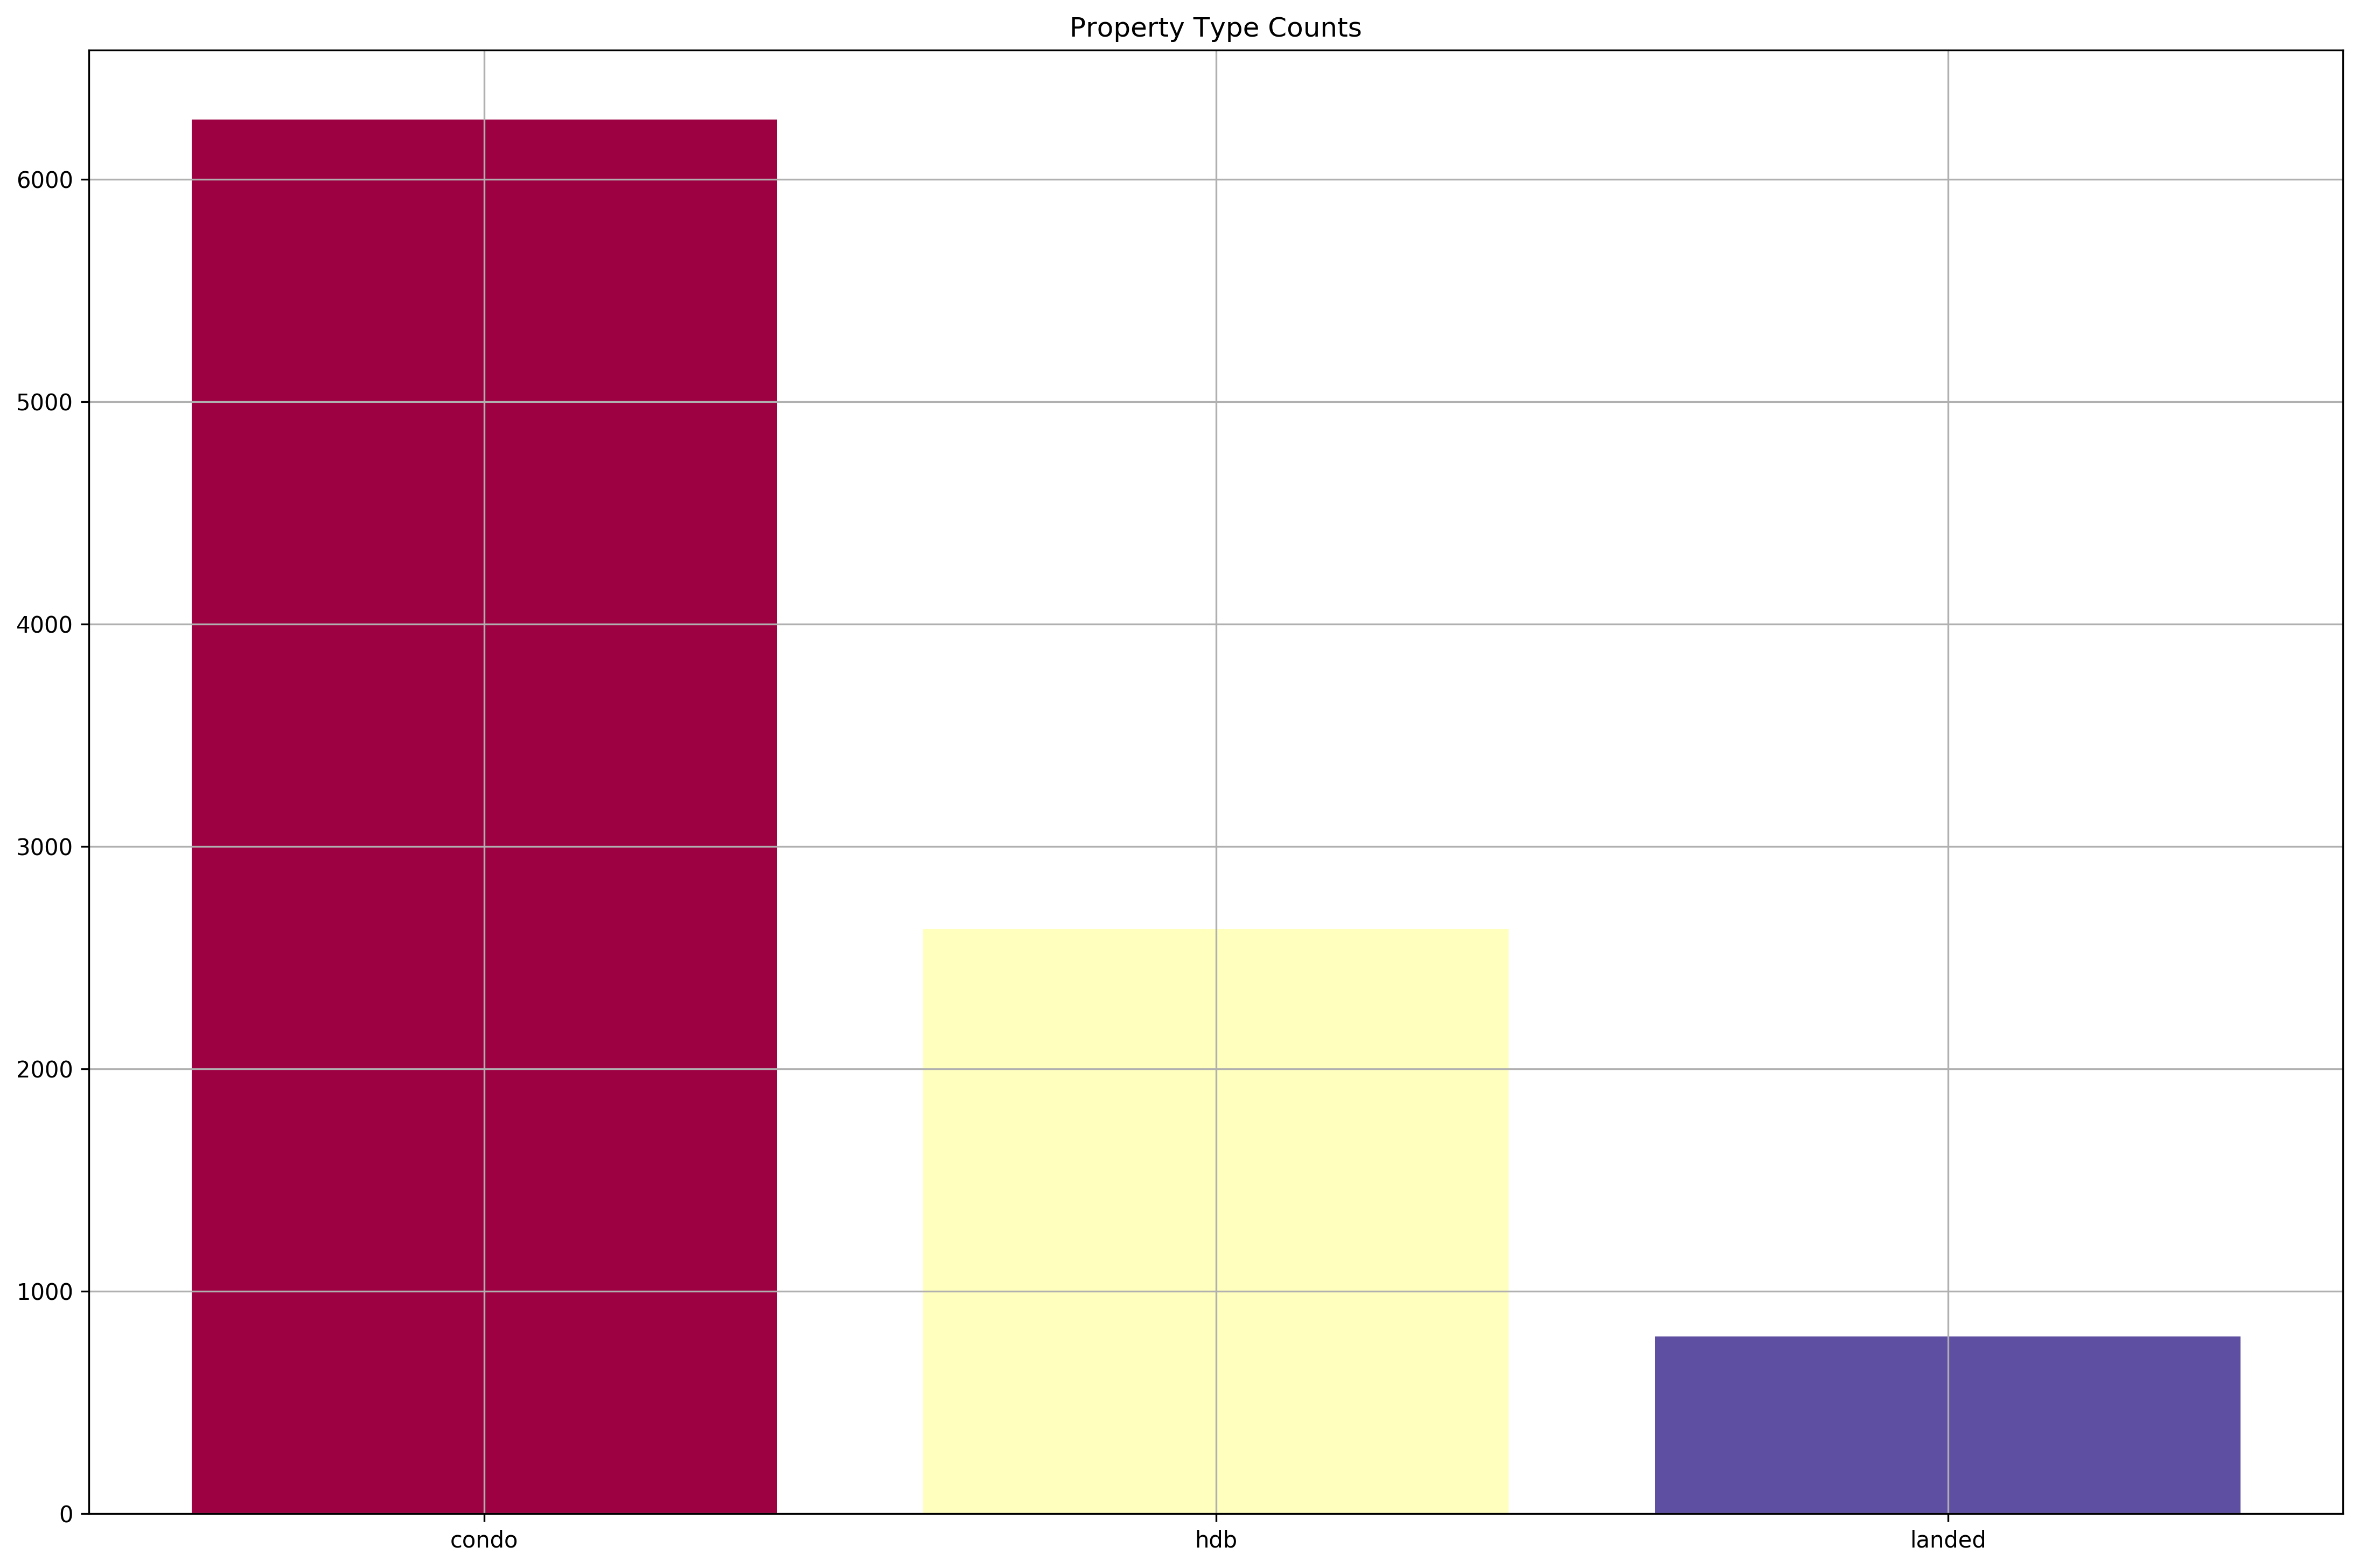

In [5]:
property_type_counts = cleaned_dataset['type'].value_counts()
plt.bar(property_type_counts.index, property_type_counts, color=get_colors(len(property_type_counts)))
plt.grid()
plt.title('Property Type Counts');

How about the district breakdown?

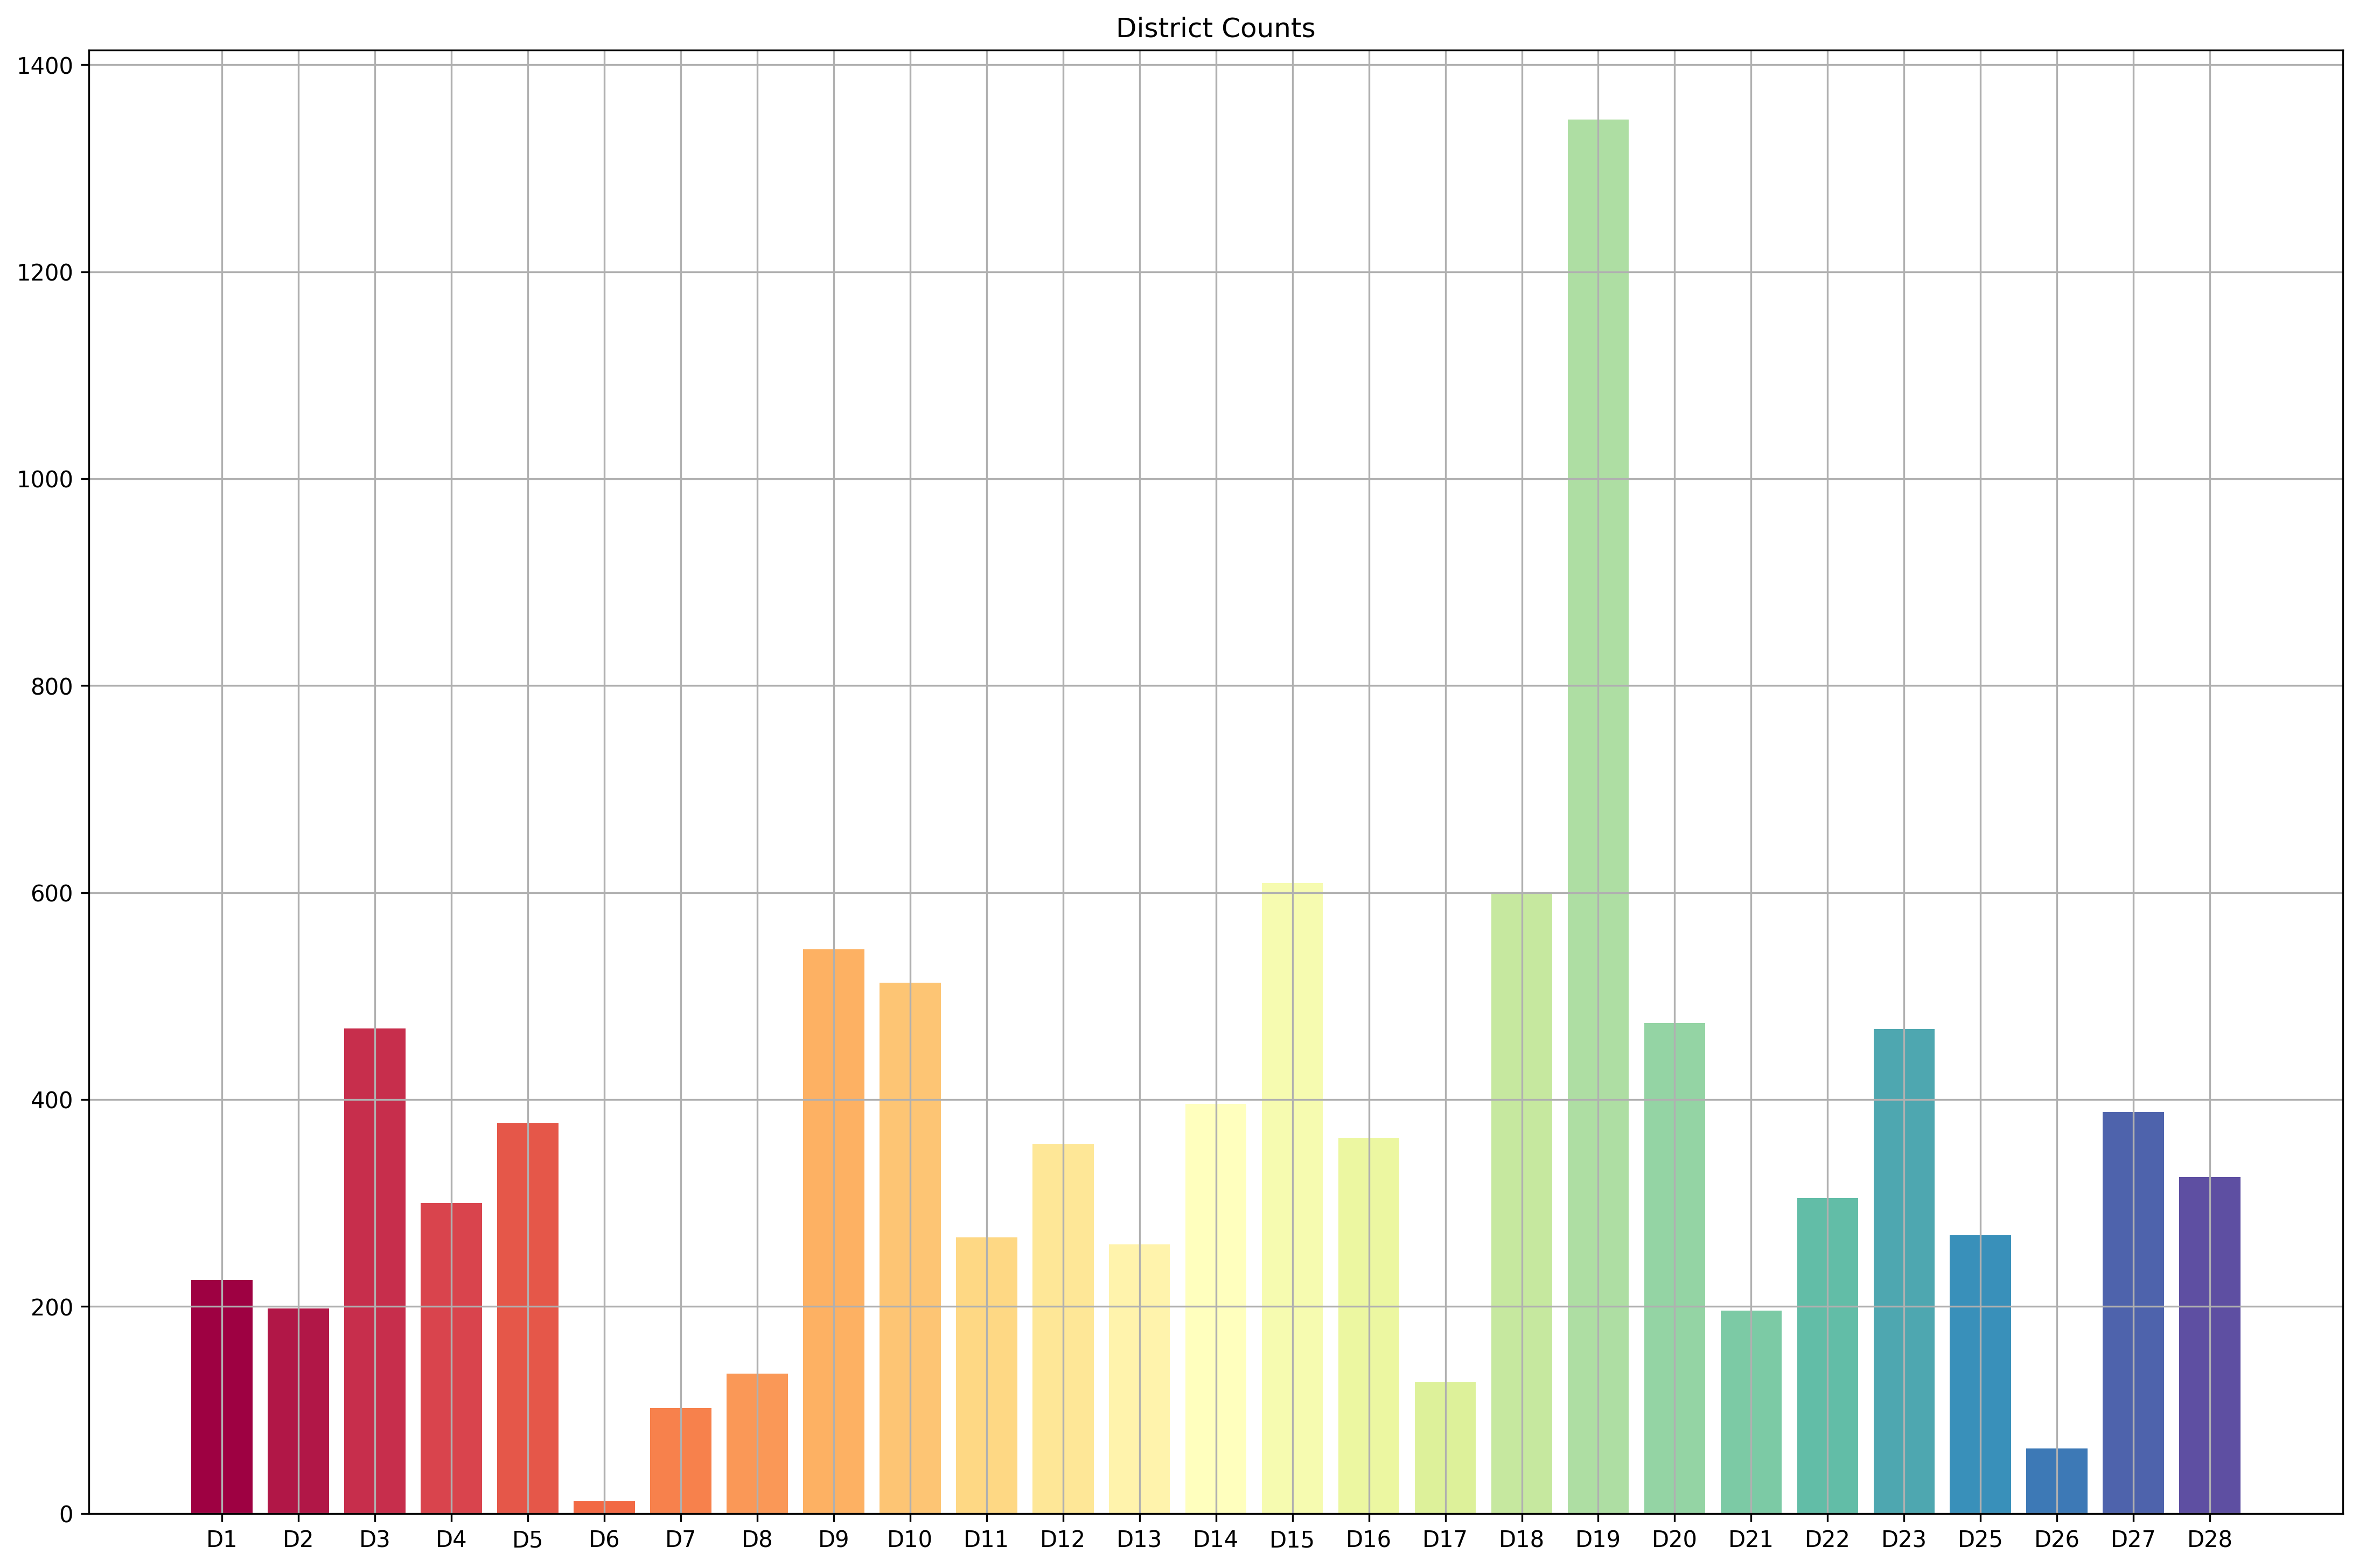

In [6]:
property_district_counts = sorted(cleaned_dataset['District'].value_counts().items(), key=lambda kv: int(kv[0][1:]))
districts, counts = list(zip(*property_district_counts))
plt.bar(districts, counts, color=get_colors(len(property_district_counts)))
plt.grid()
plt.title('District Counts');

We are missing `D24`, and it appears that we have a highly imbalanced dataset - we have really few `D6` and `D26` properties, and a ton of `D19` properties. Let's see the property type breakdown by district.

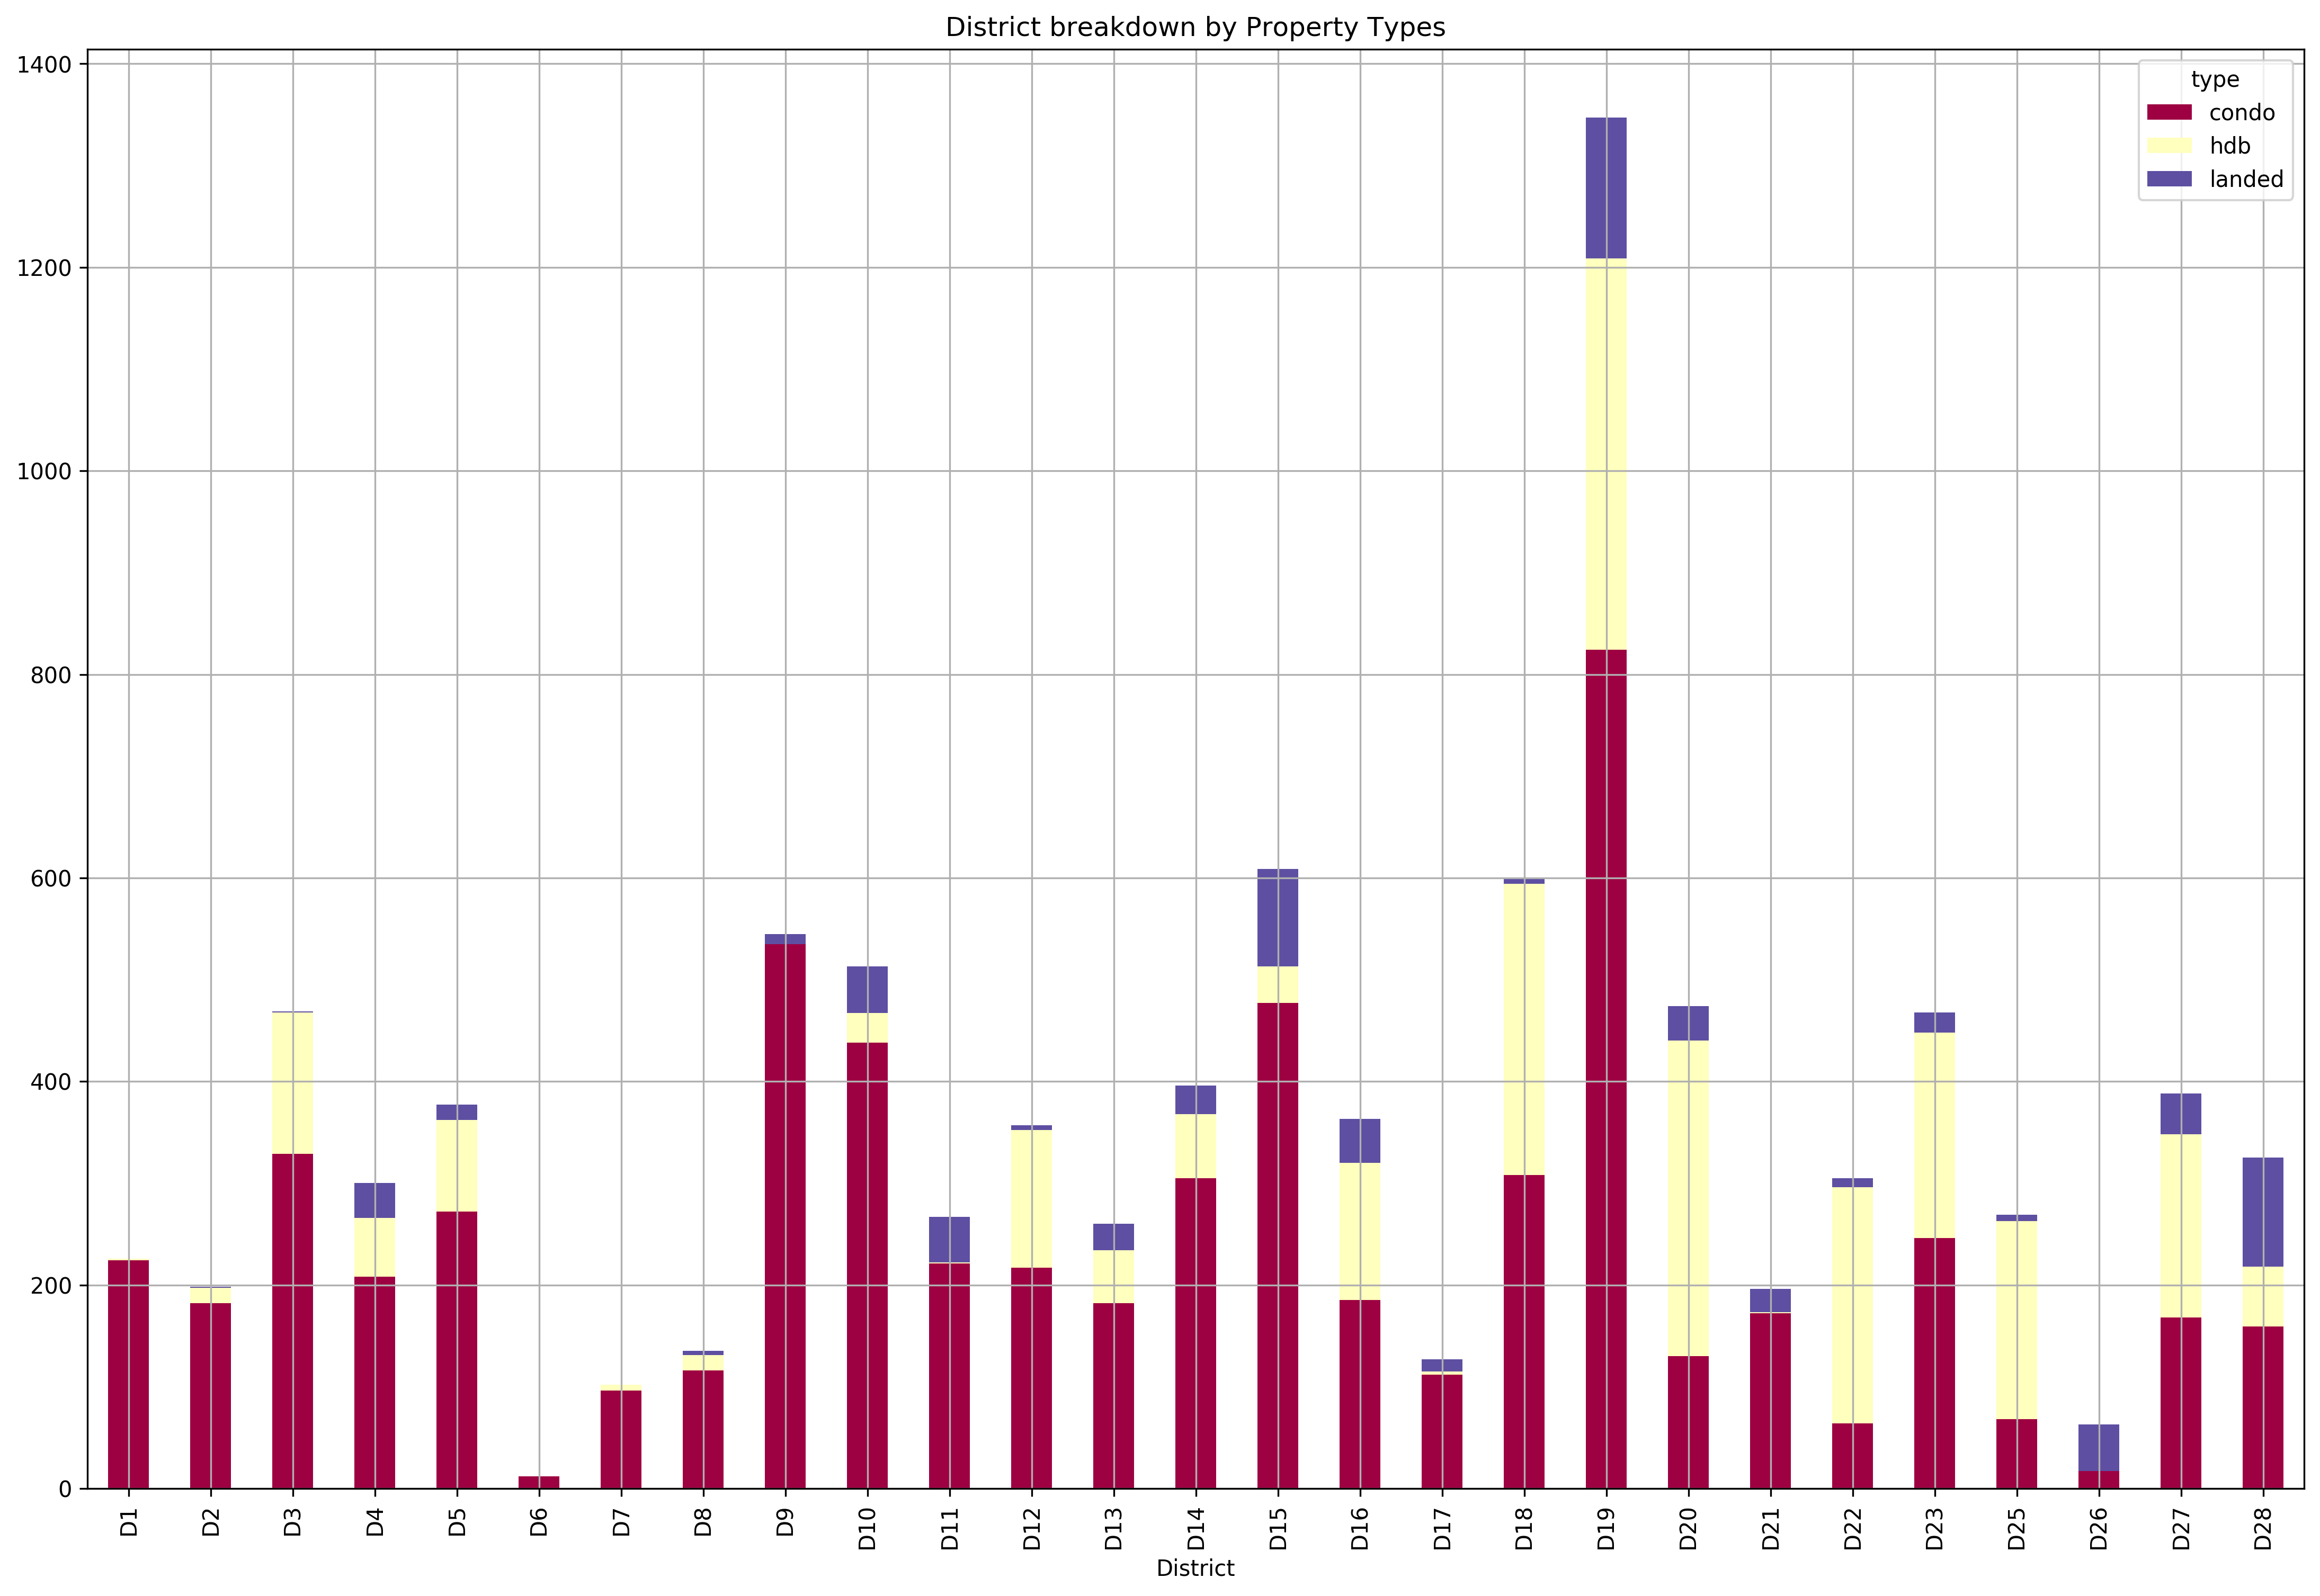

In [7]:
unstacked_district_counts_df = cleaned_dataset.groupby(['District', 'type']).count().iloc[:,0].unstack().loc[[*districts], :]
unstacked_district_counts_df.plot(
    kind='bar', 
    title='District breakdown by Property Types',
    colormap='Spectral', 
    stacked=True).grid();

We do seem to have an overwhelmingly larger portion of condominium observations compared to HDBs or Landed properties. Hence, we'll focus the analysis on condominiums.

## Condominiums

In [8]:
condo_X = cleaned_dataset[cleaned_dataset['type'] == 'condo']

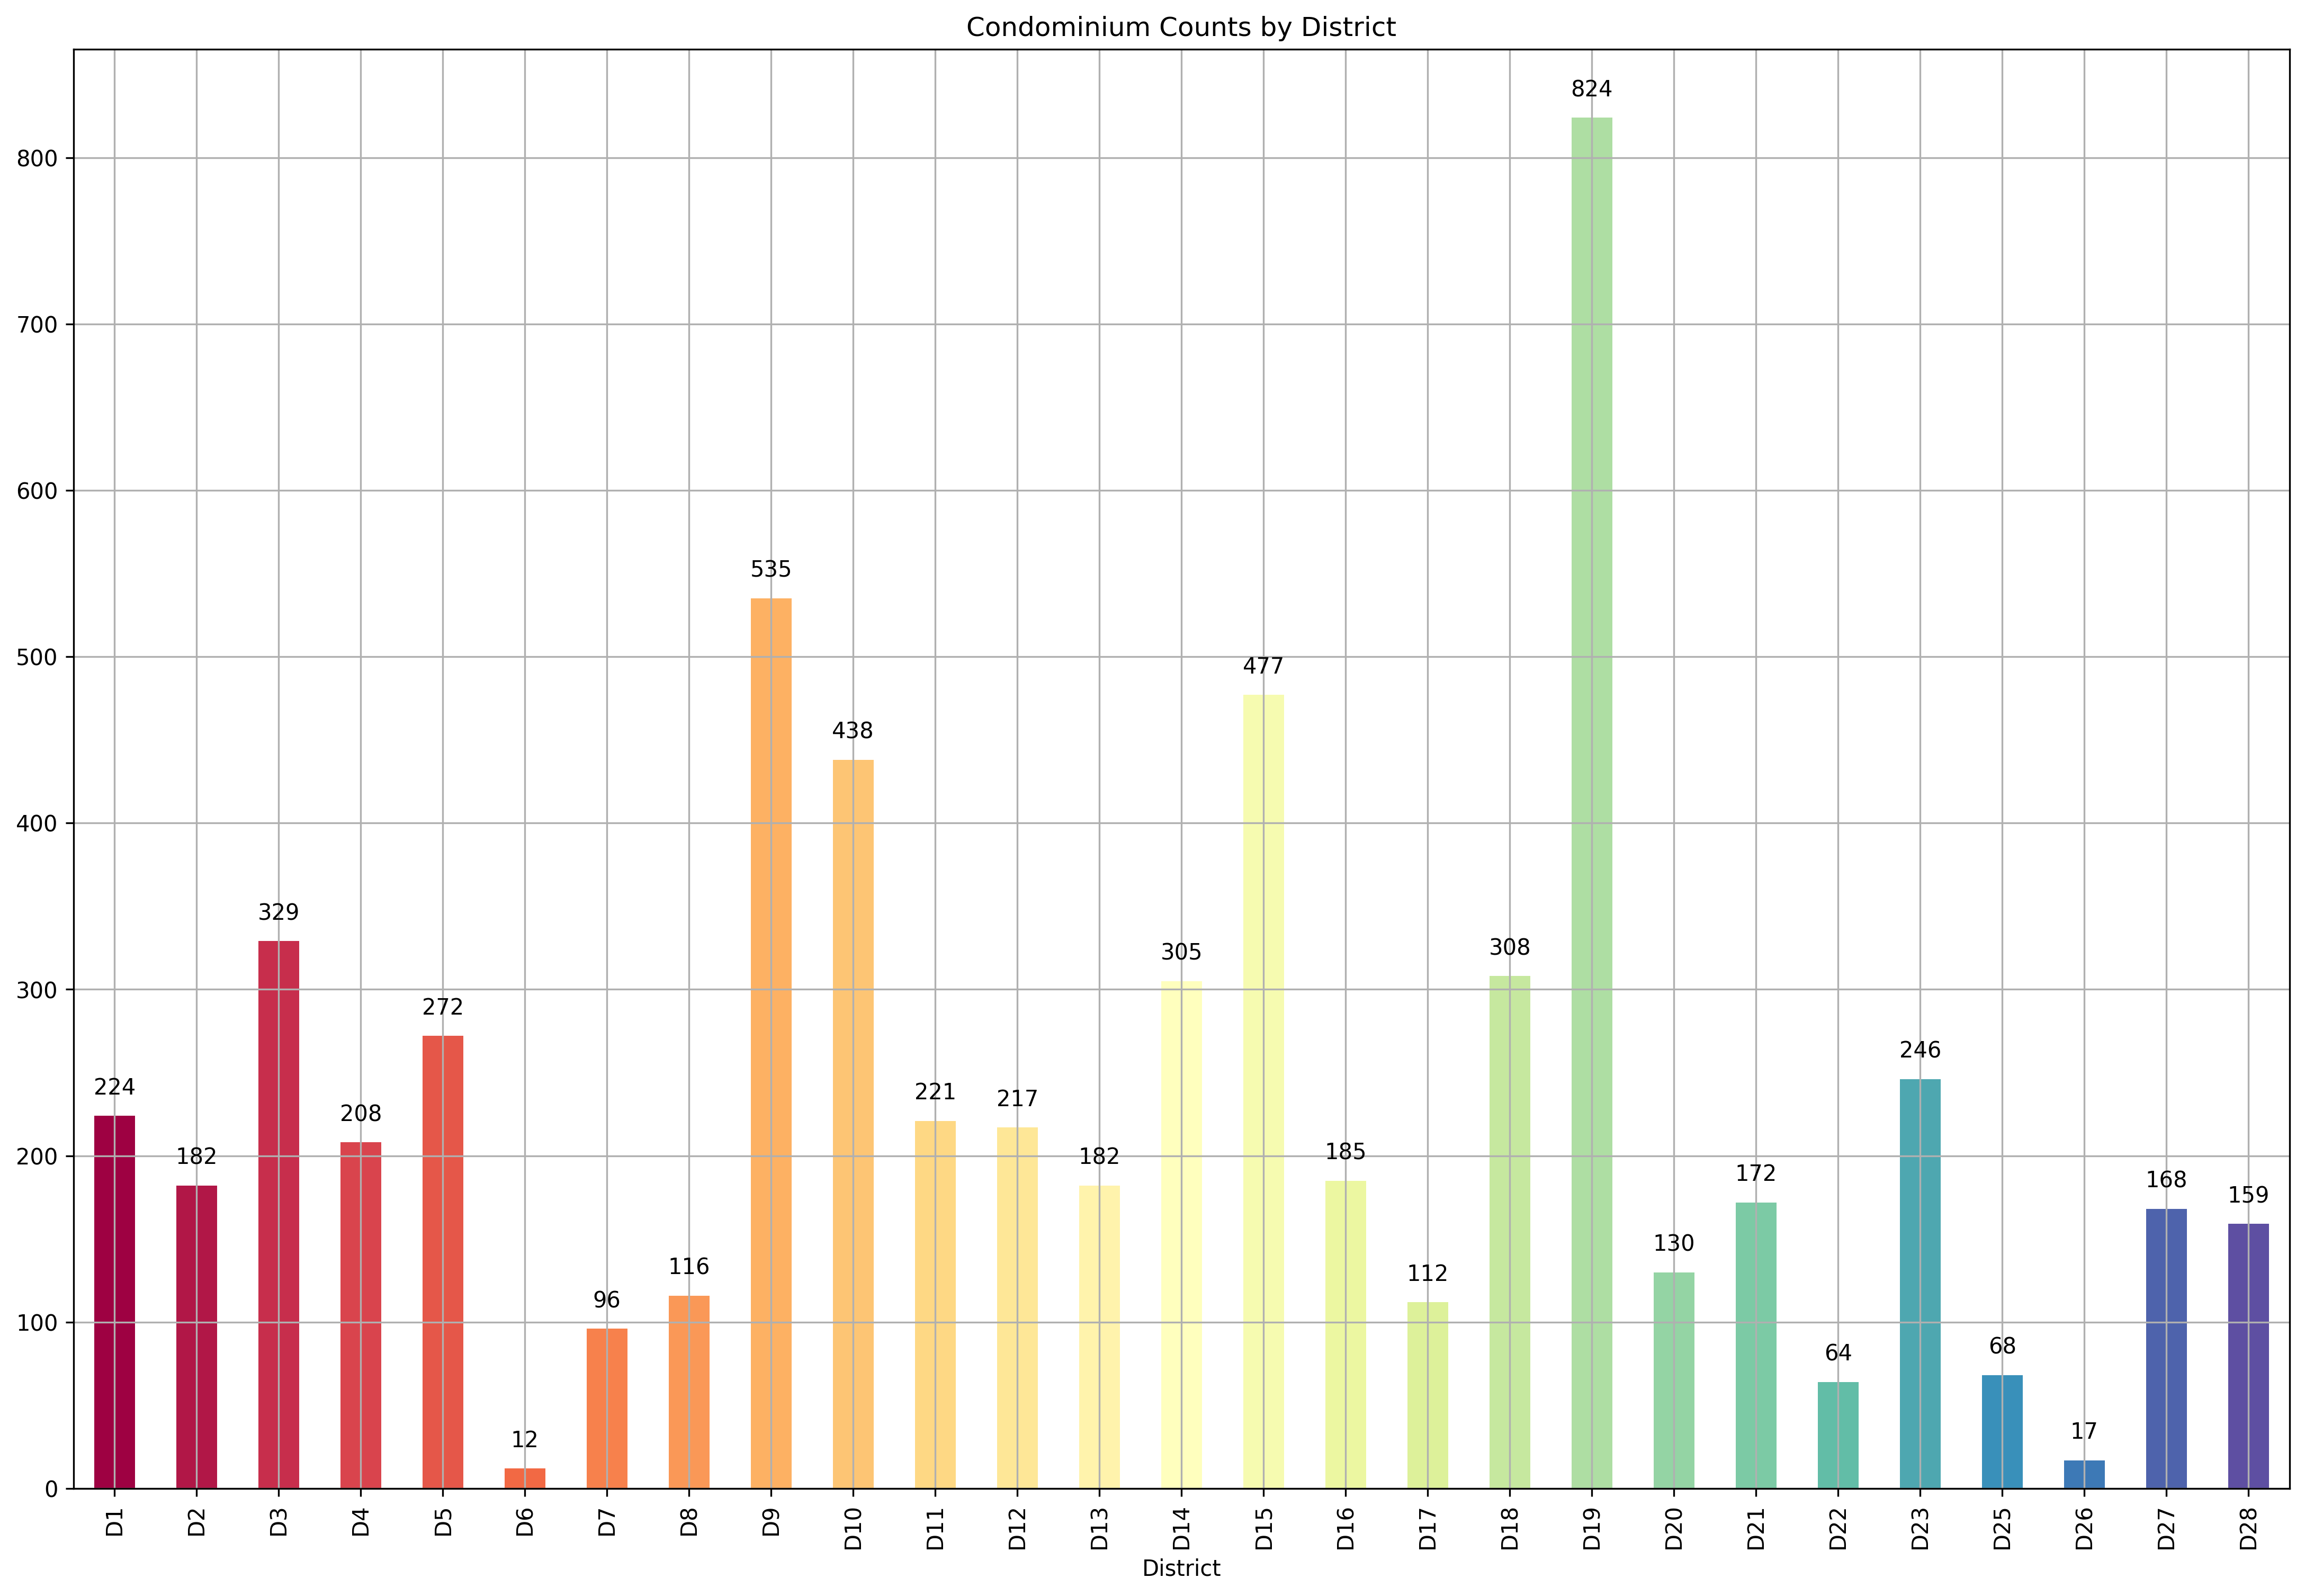

In [9]:
ax = plt.subplot()

condo_X.groupby(['District']).count().loc[[*districts], 'price'].plot(
    kind='bar', 
    title='Condominium Counts by District', 
    color=get_colors(len(districts)),
    ax=ax
).grid()

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.25, p.get_height()+10), 
                va='bottom', 
                ha='center',
                fontsize=10)

Let's take a look at the heat map of the features of our condominiums to get a sense of which features might be helpful in helping explain the `price` of a condo.

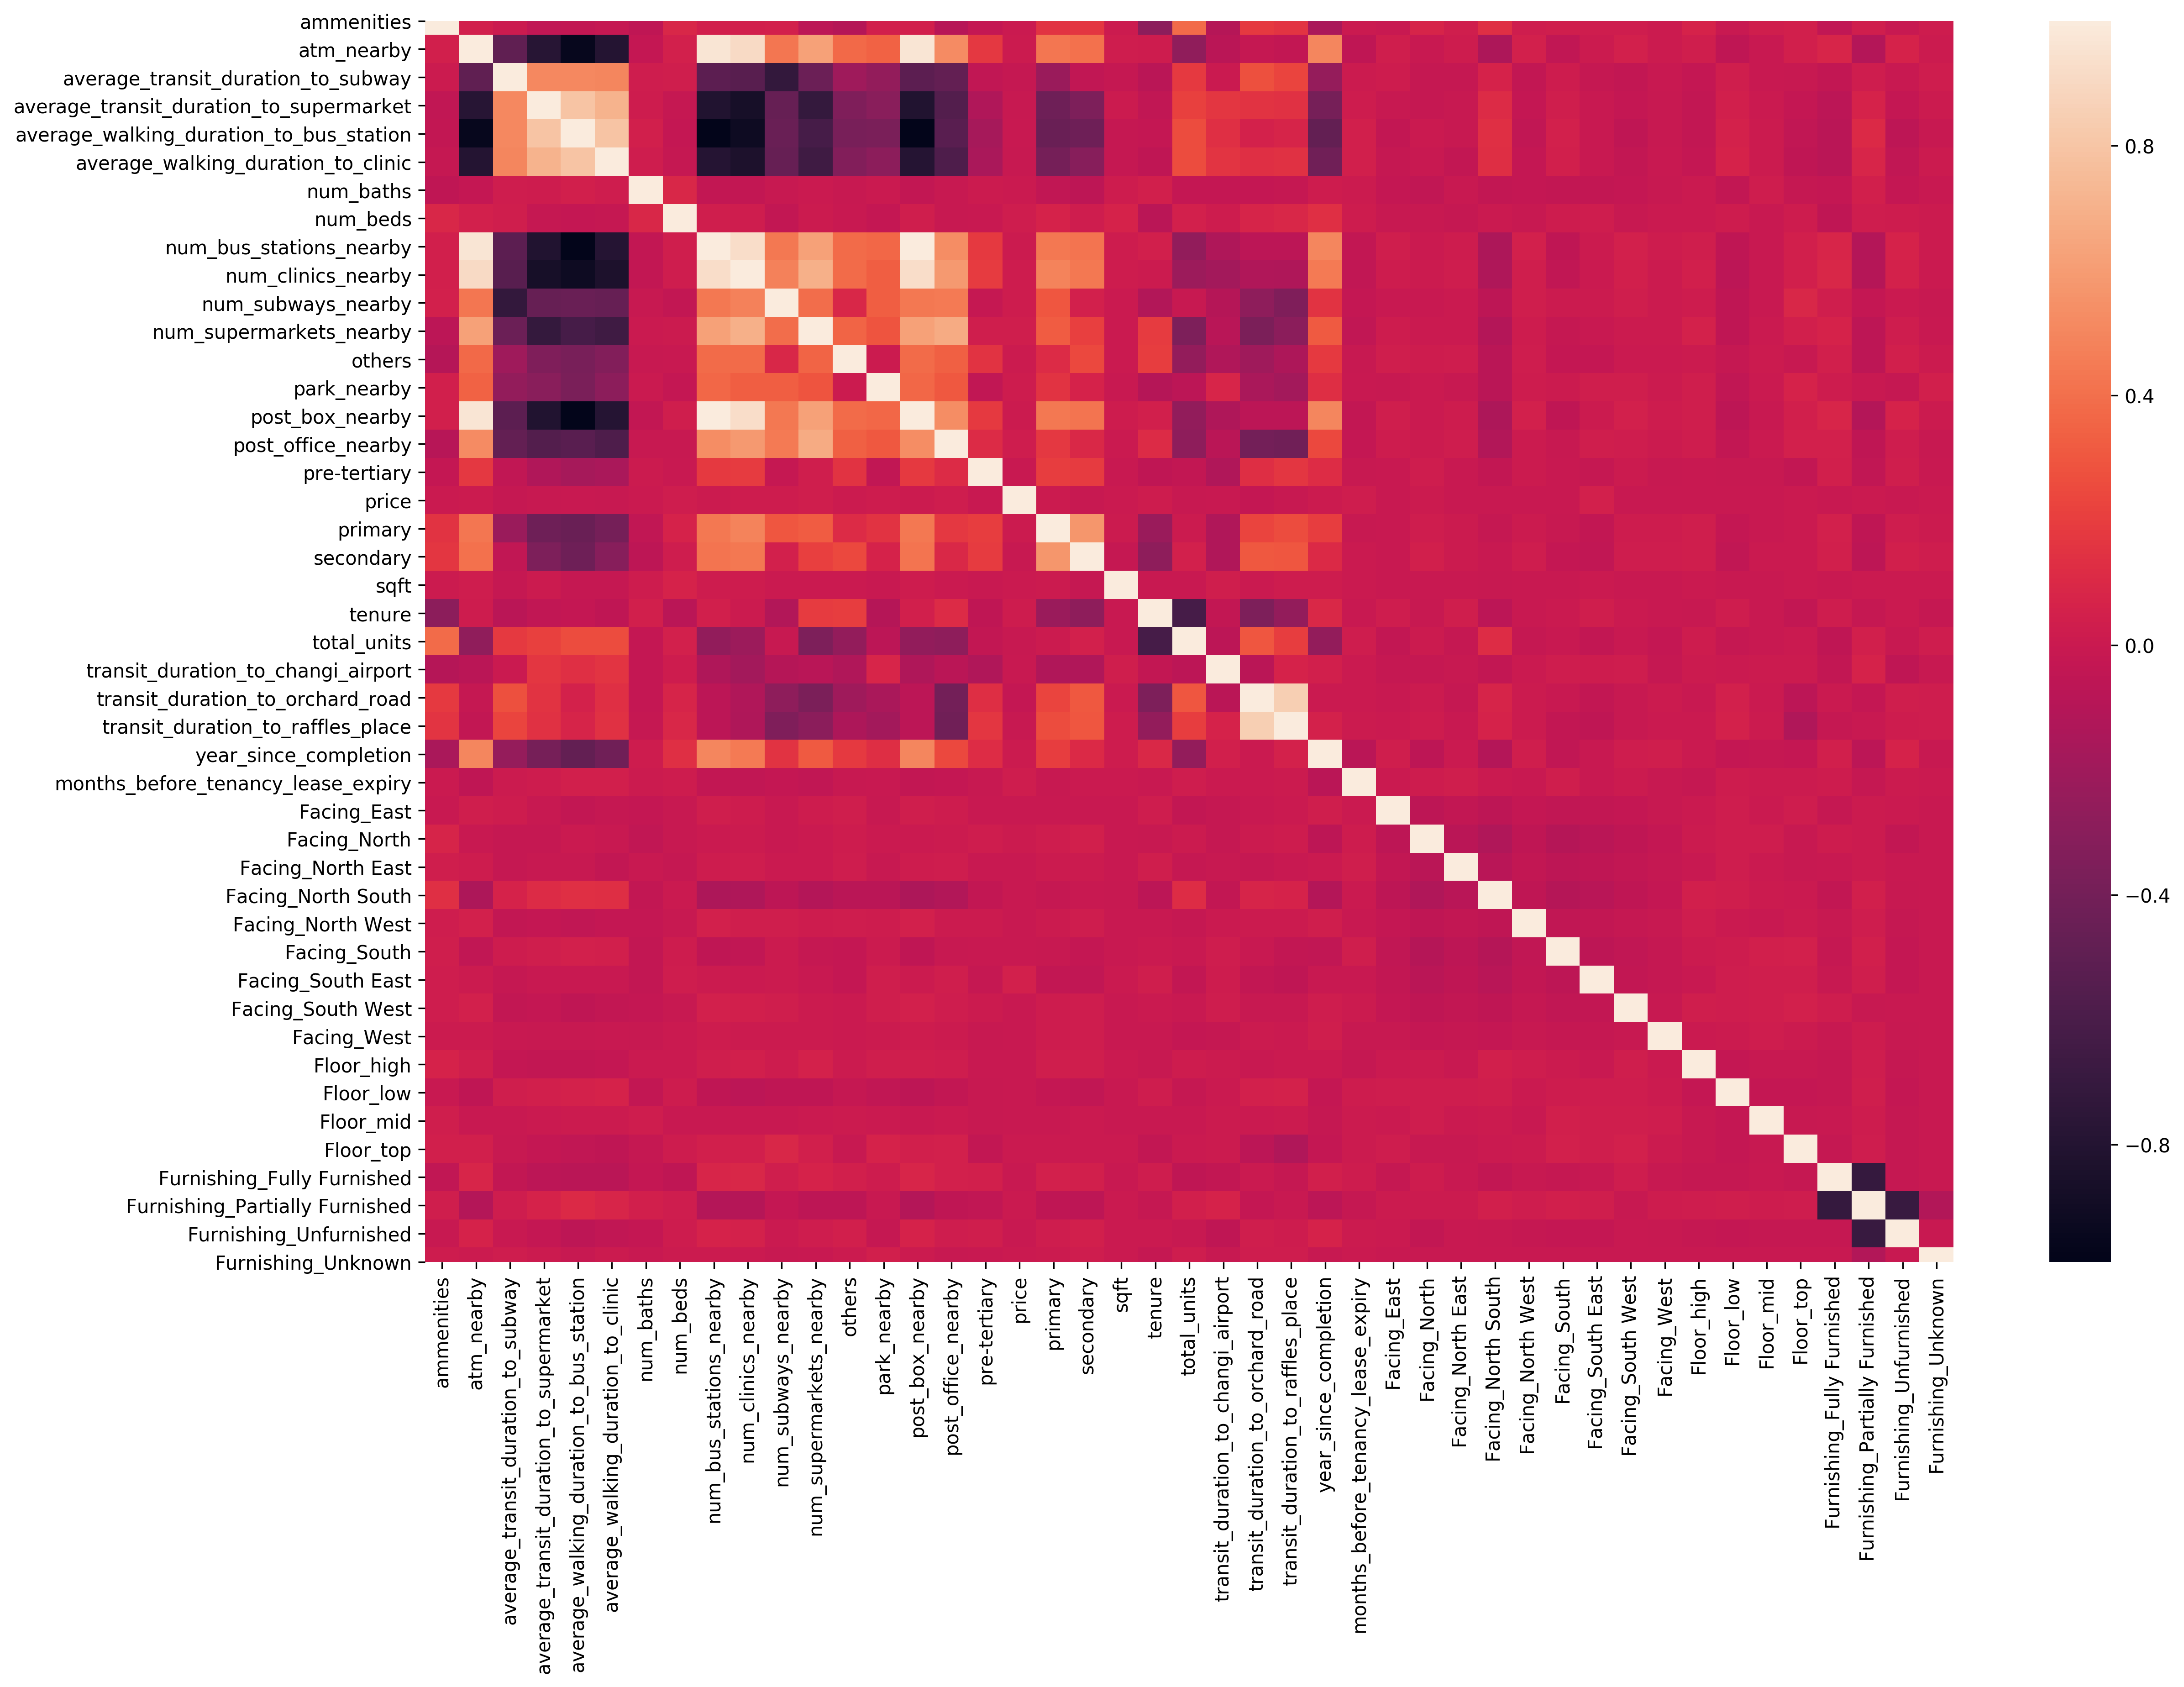

In [10]:
sns.heatmap(condo_X.drop(landed_specific_feats + special_feats + availability_feats, axis=1).corr());

Seems like there are no features that are correlated with `price`, but there are quite a few features that are either highly positively and negatively correlated with each other. For example, `average_transit_duration_to_subway`, `average_transit_duration_to_supermarket`, `average_walking_duration_to_bus_station`, `average_walking_duration_to_clinic` are highly positively correlated with each other, while they are highly negatively correlated with `atm_nearby`, a binary variable. Intuitively, this makes a lot of sense since places that are very accessible (near various transportation modes, clinics, and supermarkets) would likely be very near to atms. Let's take a closer look at those correlated features.

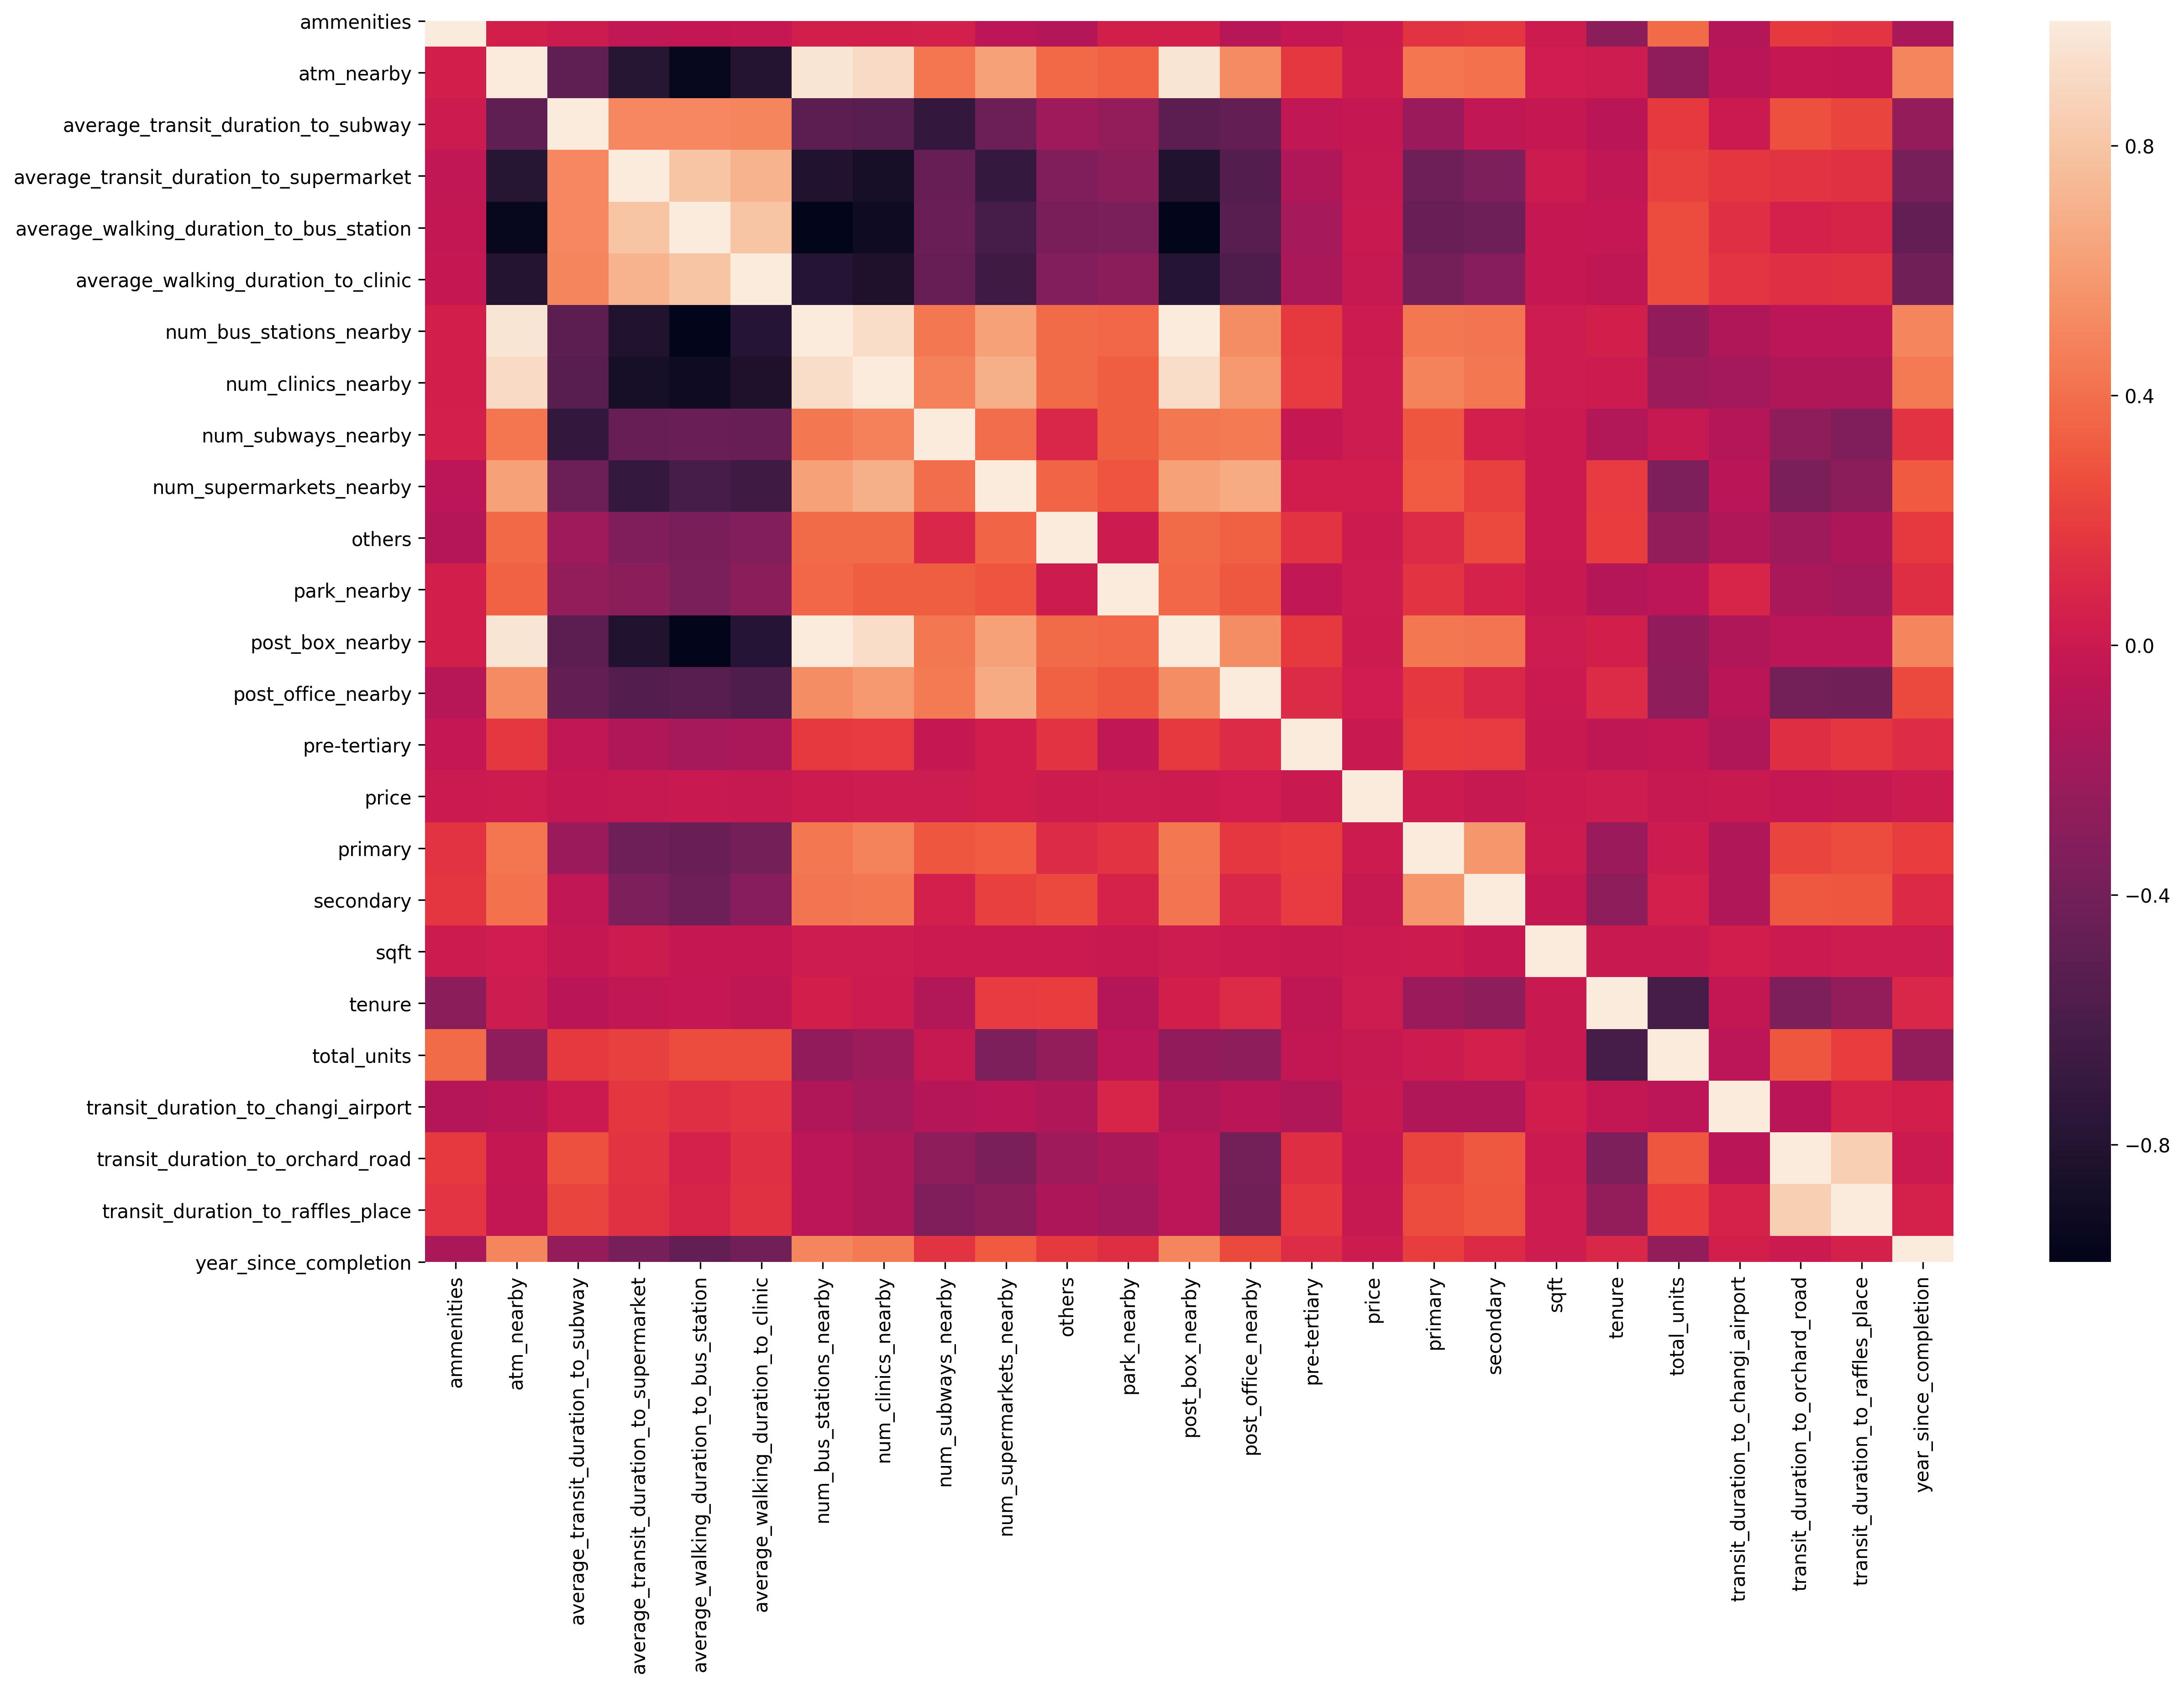

In [11]:
sns.heatmap(condo_X.drop([
    'num_baths', 
    'num_beds',
    'months_before_tenancy_lease_expiry',
    *[c for c in condo_X.columns if 
      c.lower()[:len('facing')] == 'facing' or 
      c.lower()[:len('condition')] == 'condition' or 
      c.lower()[:len('floor')] == 'floor' or 
      c.lower()[:len('furnishing')] == 'furnishing']] + landed_specific_feats + special_feats + availability_feats, axis=1).corr());

<a id='data-prep'></a>

---
# Data Preparation

## Scaling

In [12]:
X_scaler, y_scaler = StandardScaler(), StandardScaler()

X = condo_X.drop([
    'num_baths', 
    'num_beds',
    'months_before_tenancy_lease_expiry',
    *[c for c in condo_X.columns if 
      c.lower()[:len('facing')] == 'facing' or 
      c.lower()[:len('condition')] == 'condition' or 
      c.lower()[:len('floor')] == 'floor' or 
      c.lower()[:len('furnishing')] == 'furnishing']] + landed_specific_feats + special_feats + availability_feats, axis=1)

X_scaled = pd.DataFrame(X_scaler.fit_transform(X), columns=X.columns) # This still includes the price
y_scaled = y_scaler.fit_transform(np.array(cleaned_dataset[cleaned_dataset['type'] == 'condo']['price']).reshape(-1, 1)).ravel()

## Dimensionality Reduction

We do still have quite a few features even after dropping a bunch above, can we reduce them?

Total variance explained by 1 components: 37.34659499688612%
Total variance explained by 2 components: 50.358513904798066%
Total variance explained by 3 components: 58.033680956609665%
Total variance explained by 4 components: 63.305334376521614%
Total variance explained by 5 components: 67.4793006718298%
Total variance explained by 6 components: 71.489854965848%
Total variance explained by 7 components: 75.2644337176184%
Total variance explained by 8 components: 78.74400142729047%
Total variance explained by 9 components: 81.9463140577213%
Total variance explained by 10 components: 84.9529632119417%
Total variance explained by 11 components: 87.63074281670745%
Total variance explained by 12 components: 89.91244366906056%
Total variance explained by 13 components: 92.12908279690906%
Total variance explained by 14 components: 93.69694949592017%
Total variance explained by 15 components: 95.05568824841252%
Total variance explained by 16 components: 96.25719888373614%
Total variance expla

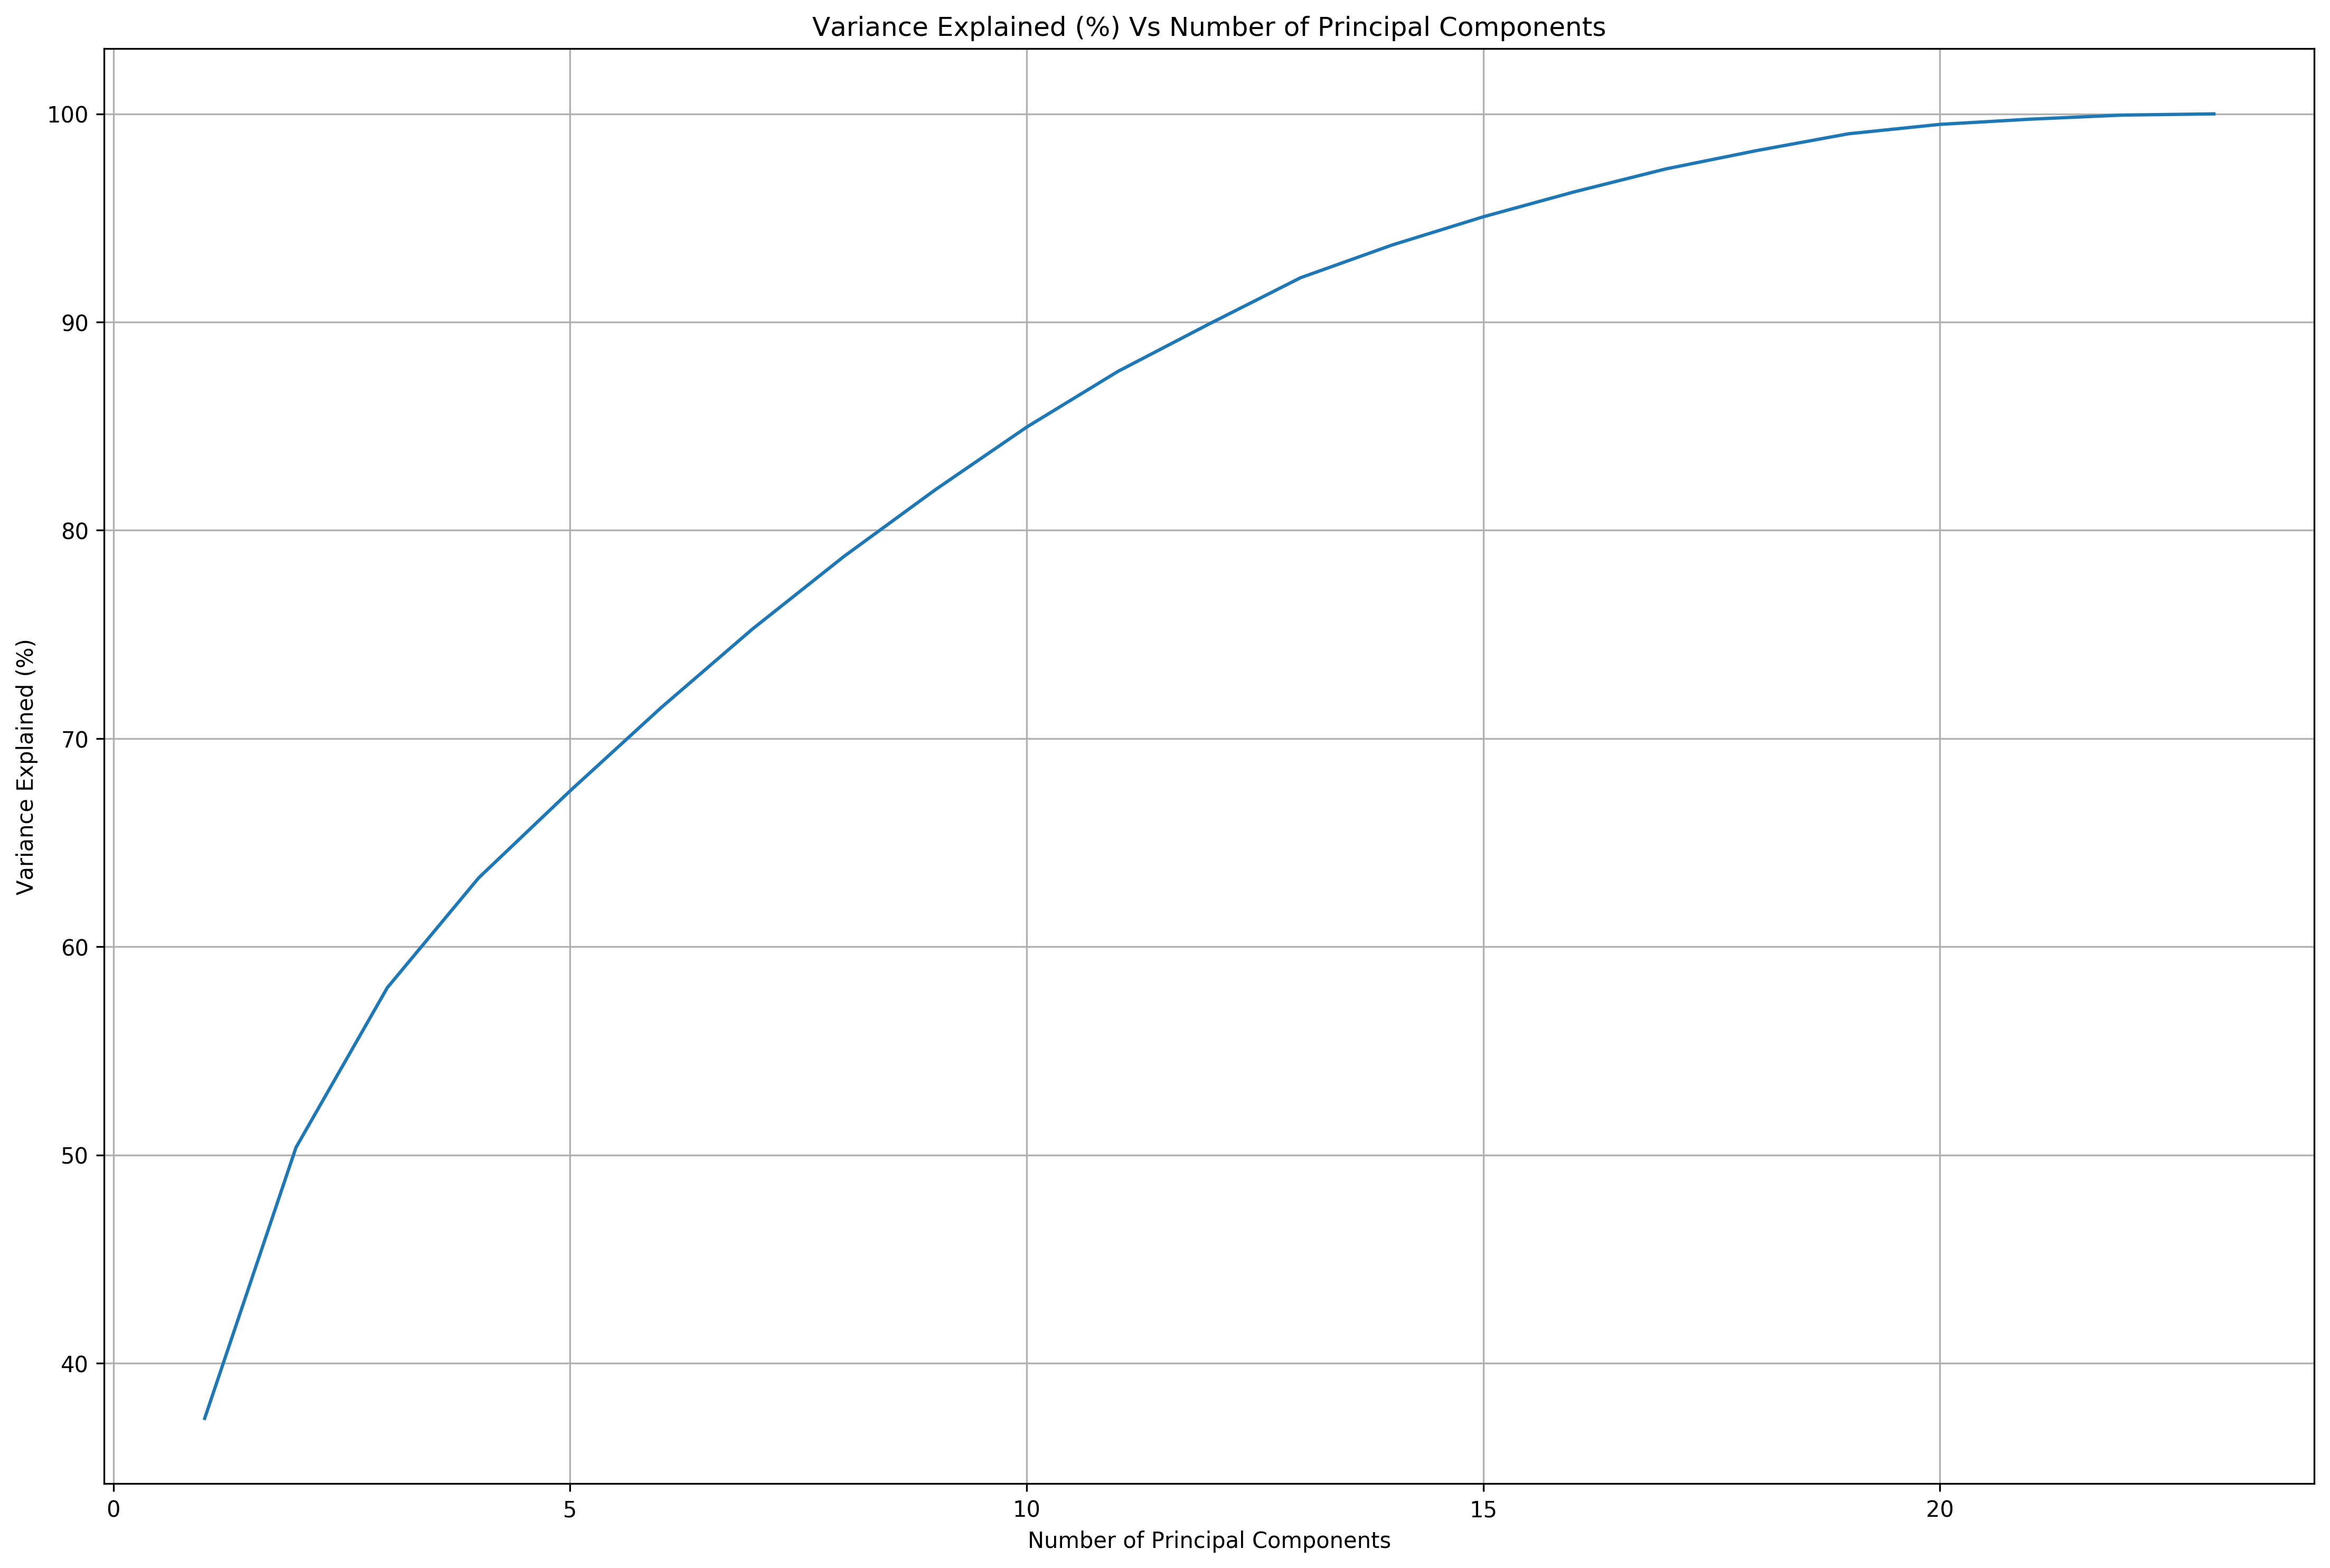

In [13]:
pca = {}
X_pca = {}
total_variance_explained = []
for n in range(1, len(X_scaled.drop(['price'], axis=1).columns)):    
    pca[n] = PCA(n_components=n)
    X_pca[n] = pca[n].fit_transform(X_scaled.drop(['price'], axis=1))
    total_variance_explained.append(np.sum(pca[n].explained_variance_ratio_))
    print('Total variance explained by {} components: {}%'.format(n, np.sum(pca[n].explained_variance_ratio_ * 100)))
    
plt.plot(list(pca.keys()), np.dot(total_variance_explained, 100))
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Explained (%)')
plt.title('Variance Explained (%) Vs Number of Principal Components')
plt.grid();

Total variance explained by 13 components: 92.12908279690906%


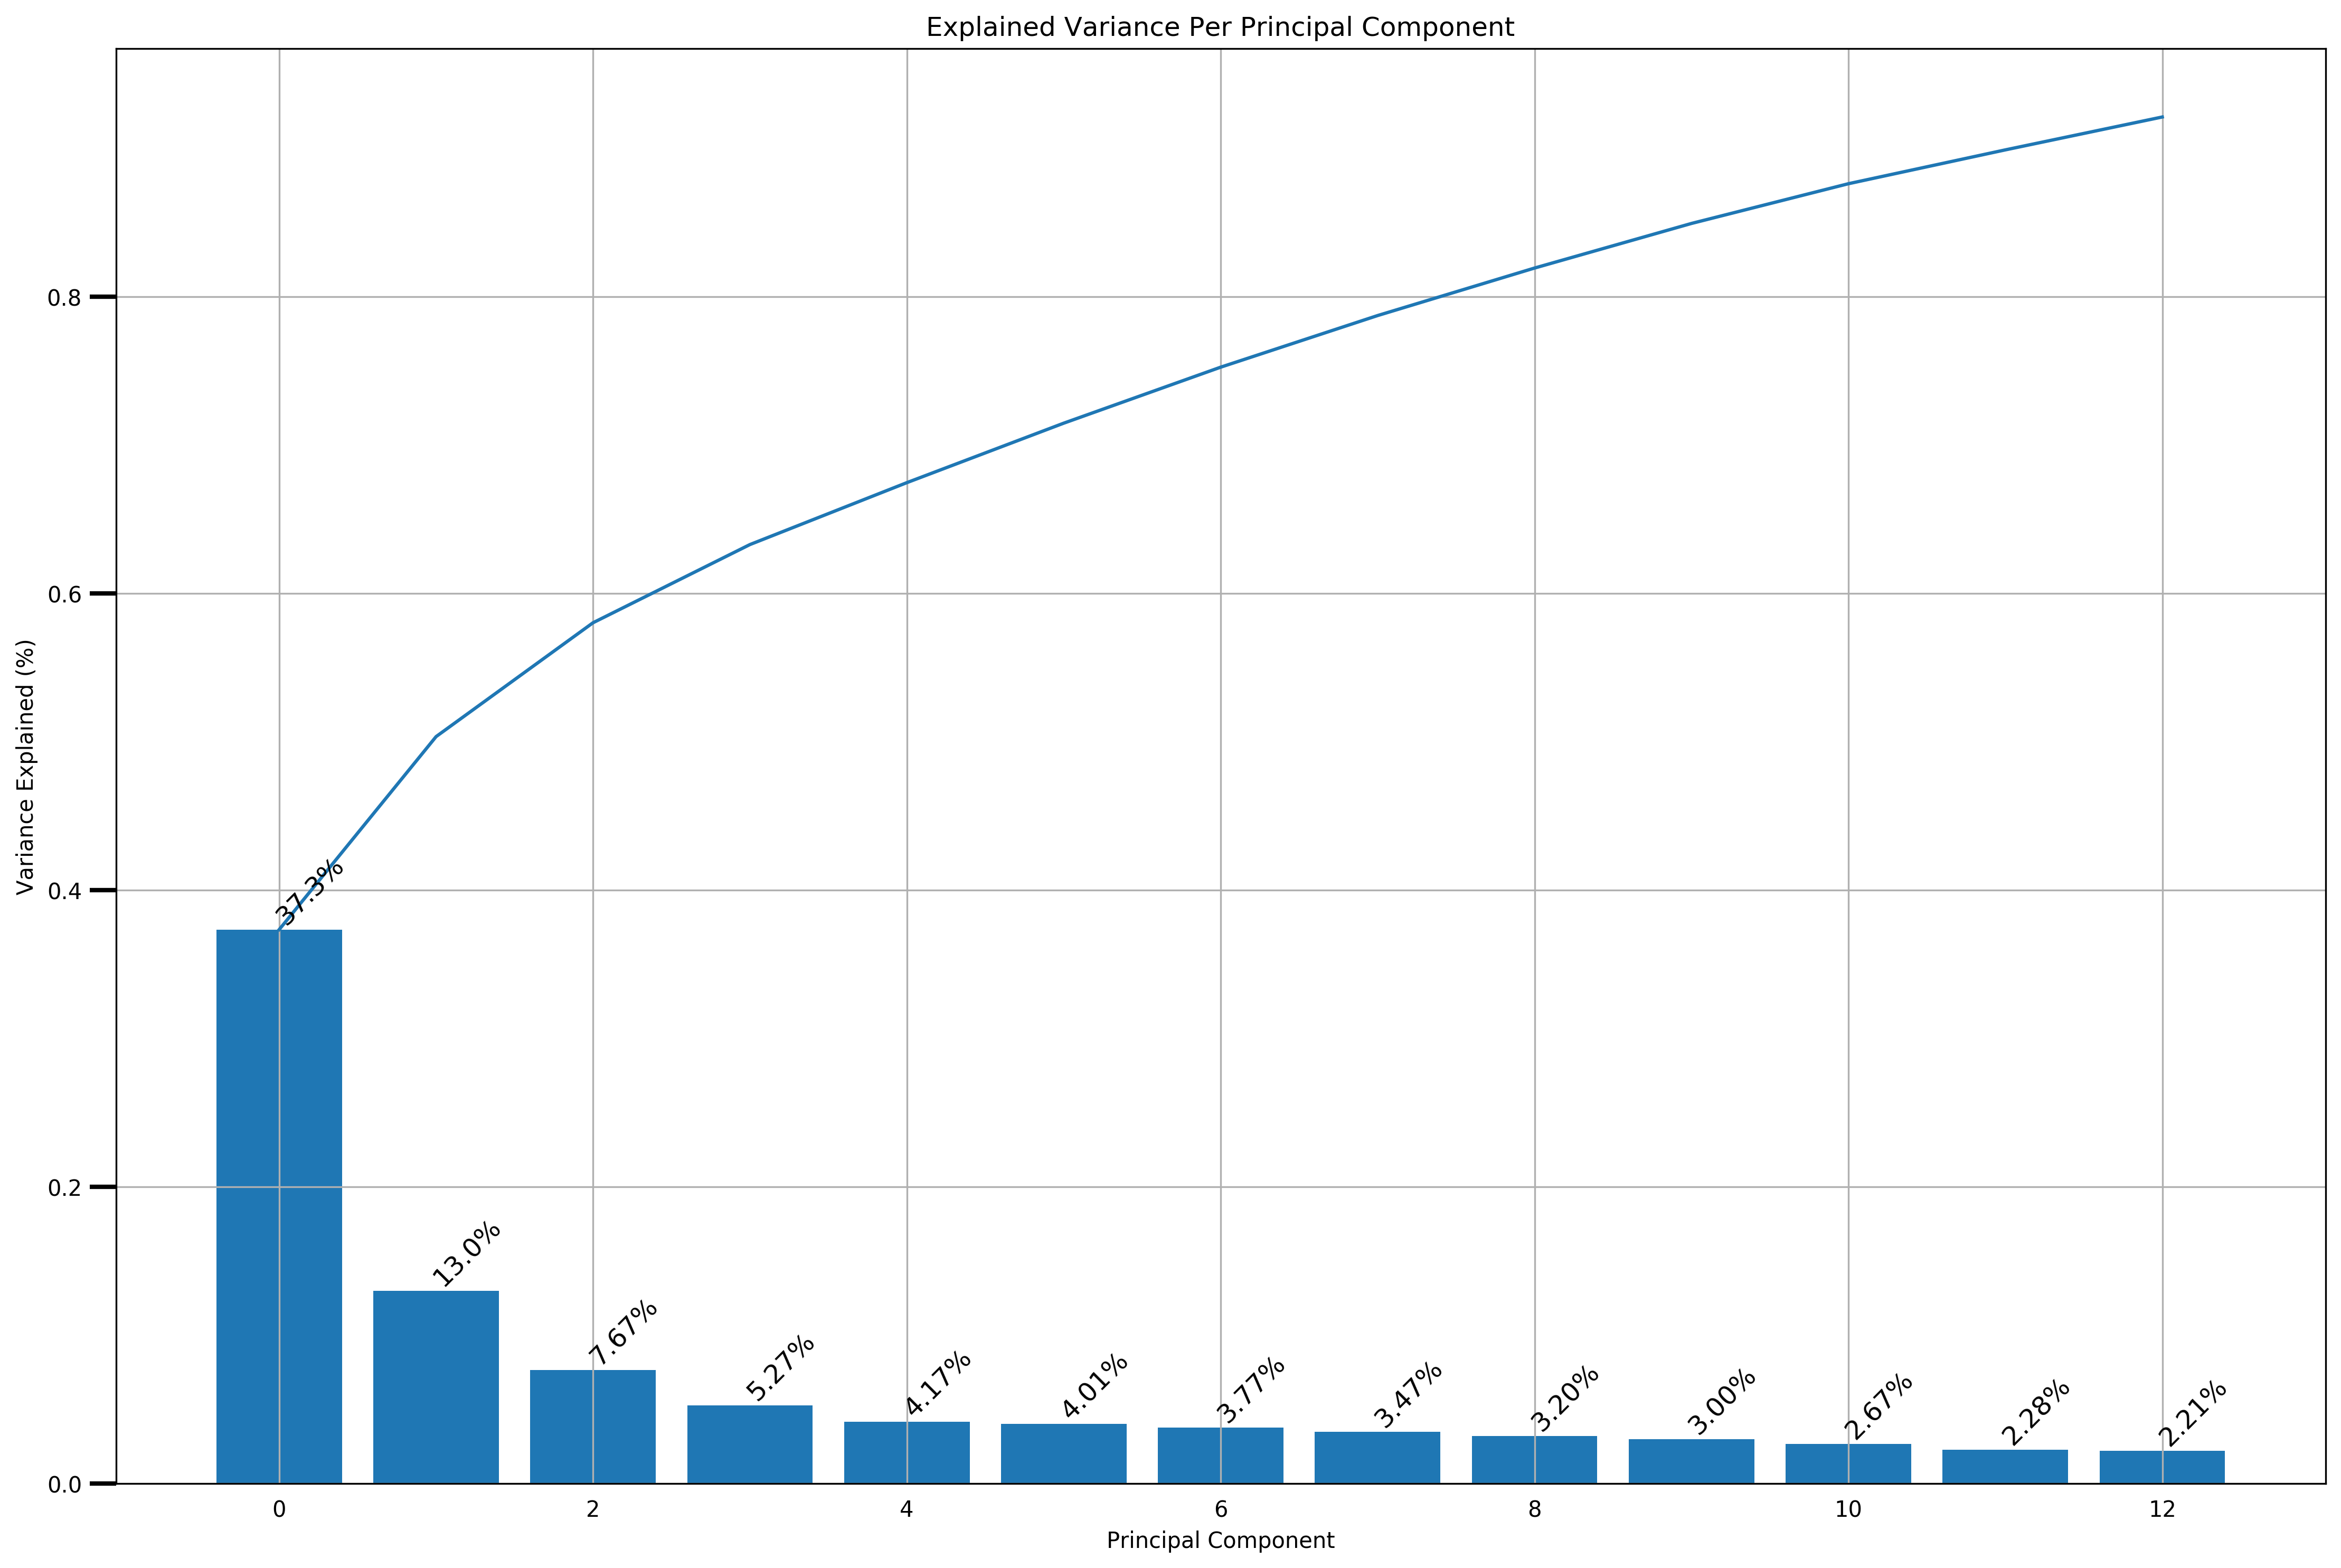

In [14]:
def scree_plot(pca):
    '''
    Function:
    ---------
    Creates a scree plot associated with the principal components 
    
    Parameters:
    -----------
    pca: the result of instantiation of PCA in scikit learn
            
    Returns:
    --------
    None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    print('Total variance explained by {} components: {}%'.format(num_components, np.sum(vals) * 100))
    
    ax = plt.subplot()
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va='bottom', ha='center', fontsize=12, rotation=45)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Variance Explained (%)')
    plt.title('Explained Variance Per Principal Component')
    plt.grid()
    plt.show();
    
for n_components, pca_obj in pca.items():
    if np.sum(pca_obj.explained_variance_ratio_ * 100) > 90:
        scree_plot(pca_obj)
        break

Because we want more intepretability of the features we use for the subsequent analyses, we'll use the original scaled features rather than any of the dimensionality reduced features using PCA. Furthermore, according to [this](http://blog.explainmydata.com/2012/07/should-you-apply-pca-to-your-data.html), PCA is highly sensitive to scale of the data, which makes me doubt whether we should really use PCA in this situation when we don't have a well-justified reason to use it.

<a id='model'></a>

---
# Modeling

## 1. Cluster Analysis

Currently, there are [28 designated districts](https://www.singaporeexpats.com/housing-in-singapore/singapore-district-guide.htm) in Singapore. After clustering our data, could we discern these 28 districts well, or is there a different clustering of the data?

We want to visualize the clusters created using the KMeans clustering algorithm which assigns data points to the cluster that the data point has the shortest euclidean distance to. In order 

In [ ]:
def visualize_clusters(X, silhouette_avg, cluster_labels, clusterer):
    """
    Function:
    ---------
    Visualize the number of clusters predicted according to the model
    
    Parameters:
    -----------
    X: The dataset to discover the clusters from
    silhouette_avg: The average silhouette score for all the samples
    cluster_labels: The predicted cluster labels by model
    clusterer: The fitted Kmeans model on X
    
    Returns:
    --------
    None.
    """
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # --------------------------------------------
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -0.2, 1
    ax1.set_xlim([-0.2, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (clusterer.n_clusters + 1) * 10])

    y_lower = 10
    colors = get_colors(clusterer.n_clusters)
    for i in range(clusterer.n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=colors[i], edgecolor=colors[i], alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([round(val, 2) for val in np.arange(-0.2, 1.1, 0.2)])
    ax1.grid()

    # --------------------------------------------
    # 2nd Plot showing the actual clusters formed using TSNE embedding
    labels_to_colors = [colors[label] for label in cluster_labels]
    
    # Create TSNE Embeddings
    X_embedded = TSNE(n_components=2).fit_transform(X)
    
    ax2.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=labels_to_colors, edgecolor='k')

    # Labeling the clusters
    # Get the indices of the data points that are closest to the cluster centers 
    closest_data_points_indices, _ = pairwise_distances_argmin_min(clusterer.cluster_centers_, X)
    closest_data_points = np.array([X_embedded[idx] for idx in closest_data_points_indices])
    
    # Draw white circles at those approximate cluster centers
    ax2.scatter(closest_data_points[:, 0], closest_data_points[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(closest_data_points):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st TSNE Embedding")
    ax2.set_ylabel("Feature space for the 2nd TSNE Embedding")
    ax2.grid()

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % clusterer.n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show();

In [ ]:
def plot_pareto_frontier(X, Y, n_clusters, ax, maxX=True, maxY=True):
    """
    Function:
    ---------
    Plots the pareto frontier given costs X and Y for choosing
    number of clusters
    
    Parameters:
    -----------
    X: list of WCSS scores for each of the number of clusters
    Y: list of Silhouette scores for each of the number of clusters
    n_clusters: list of number of clusters 
    ax: axis to plot the pareto frontier
    maxX: Bool, True if we are trying to maximize X, false if minimize X
    maxY: Bool, True if we are trying to maximize Y, false if minimize Y
    
    Returns:
    --------
    pareto_front: The pareto frontier tuples containing number
                  of clusters, wcss score, and silhouette score
                  (wcss score, silhouette score, n_clusters)
    """
    # Start with all elements in pareto front,
    # then remove all the non-dominating elements in outer for loop
    X_scaler, Y_scaler = MinMaxScaler(), MinMaxScaler()
    X_scaled, Y_scaled = X_scaler.fit_transform(np.array(X).reshape(-1, 1)), Y_scaler.fit_transform(np.array(Y).reshape(-1, 1))
    pareto_front = sorted(list(zip(X_scaled, Y_scaled, n_clusters)), key=lambda val: val[1], reverse=maxY)

    # idx - index of last added dominating element in our pareto front
    for idx in range(len(pareto_front)):
        # Remove all elements that have X larger than the last dominating element
        # of the pareto frontier
        for xy in pareto_front[idx+1:]:
            # Maximize X
            if maxX:
                if pareto_front[idx][0] > xy[0]:
                    pareto_front.remove(xy)
            # Minimize X
            else:
                if pareto_front[idx][0] < xy[0]:
                    pareto_front.remove(xy)

        # Now our search space has been confined to elements
        # that have a smaller X (good), but not so good Y,
        # so we can move to idx+1
    
    '''Plotting process'''
    normalized_wcss_scores, normalized_silhouette_avg_scores = list(zip(*pareto_front))[:2]
    ax.scatter(X_scaled, Y_scaled, c='g', marker='s')
    ax.plot(normalized_wcss_scores, normalized_silhouette_avg_scores, linestyle=':', linewidth=2, marker='s', color='g', markersize=12)
    ax.set_xlabel('Normalized WCSS (Minimization Objective)');
    ax.set_ylabel('Normalized Silhouette Score (Maximization Objective)');
    ax.set_title('Pareto Frontier')
    ax.grid()
    
    return [(X_scaler.inverse_transform(np.array(normalized_wcss_score).reshape(-1, 1)), 
             Y_scaler.inverse_transform(np.array(normalized_silhouette_avg_score).reshape(-1, 1)), 
             k) for normalized_wcss_score, normalized_silhouette_avg_score, k in pareto_front]

In [15]:
def find_best_n_clusters(X, range_n_clusters, actual_clusters, property_links):
    """
    Function:
    ---------
    Visualize the number of clusters predicted according to the model
    
    Parameters:
    -----------
    X: The dataset to discover the clusters from
    range_n_clusters: list of the different number of clusters to fit Kmeans on
    actual_clusters: pandas series of the actual clusters designated by the Singapore government
    property_links: pandas series of the web urls for each condominium in our dataset
    
    Returns:
    --------
    pandas dataframe with the cluster predictions for model with subjectively best WCSS and
    Silhouette score tradeoff on pareto frontier
    """
    # Silhouette scores for different number of clusters
    silhouette_avg_scores = []
    # Inertia / Within-cluster Sum of Squares scores for different number of clusters
    wcss_scores = []
    # Dictionary of the Kmeans models fitted on different number of clusters
    clusterers = {}
    # Dictionary of the predicted cluster labels for each sample by the fitted Kmeans models
    cluster_labels = {}
    
    for n_clusters in range_n_clusters:

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterers[n_clusters] = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels[n_clusters] = clusterers[n_clusters].fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels[n_clusters])
        silhouette_avg_scores.append((n_clusters, silhouette_avg))
        
        # Save the WCSS
        wcss_scores.append((n_clusters, clusterers[n_clusters].inertia_))
        
        print("For n_clusters=", n_clusters,
              " Average silhouette_score:", silhouette_avg, 
              " WCSS:", clusterers[n_clusters].inertia_)
      
    # Plot how the WCSS and silhouette scores change with n_clusters
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(18, 7)
    
    # 1st: Plot silhouette scores
    ax1.plot(*list(zip(*silhouette_avg_scores)), linestyle='--', marker='o', color='b')
    ax1.set_xlabel('K');
    ax1.set_ylabel('Silhouette Score');
    ax1.set_title('Silhouette Score vs. K')
    ax1.grid()
    
    # 2nd: Plot wcss scores
    ax2.plot(*list(zip(*wcss_scores)), linestyle='--', marker='*', color=get_colors(1)[0]);
    ax2.set_xlabel('K');
    ax2.set_ylabel('WCSS');
    ax2.set_title('WCSS vs. K')
    ax2.grid()
    
    # 3rd: Plot Pareto frontier for multiobjective optimization
    # Minimize WCSS while Maximizing Silhouette score
    pareto_front = plot_pareto_frontier(X=list(zip(*wcss_scores))[1], 
                                        Y=list(zip(*silhouette_avg_scores))[1], 
                                        n_clusters=list(zip(*wcss_scores))[0], 
                                        ax=ax3, 
                                        maxX=False, 
                                        maxY=True)
    
    plt.suptitle(('Scoring metrics against Number of clusters fitted, K'),
                 fontsize=14, fontweight='bold')
    plt.show();
    
    # Visualize the clusters for model with the 
    # silhouette score and wcss score on pareto frontier
    # Select the number of clusters that best minimize the
    # mean squared error and mean absolute error of 
    # silhouette scores of each sample with the average silhouette score
    best_k, best_mae, best_mse = 2, sys.maxsize, sys.maxsize
    for wcss_score, silhouette_avg, k in pareto_front: 
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels[k])
        cluster_mse, cluster_mae = list(zip(*[(np.mean(np.subtract(sample_silhouette_values[cluster_labels[k] == i], silhouette_avg)**2), 
                                               np.mean(np.abs(np.subtract(sample_silhouette_values[cluster_labels[k] == i], silhouette_avg)))) for i in range(k)]))
        total_mse, total_mae = np.mean(cluster_mse), np.mean(cluster_mae)
        print('k:', k,
              'MSE:', total_mse,
              'MAE:', total_mae)
        if best_mse > total_mse and best_mae > total_mae and silhouette_avg > 0:
            best_k, best_mae, best_mse = k, total_mae, total_mse
            
    visualize_clusters(X, silhouette_avg, cluster_labels[best_k], clusterers[best_k])

    return pd.concat([
        pd.DataFrame(X, columns=['pc_{}'.format(idx) for idx in range(1, X.shape[1]+1)]), 
        actual_clusters.apply(lambda val: int(val[1:])).reset_index().drop('index', axis=1), 
        pd.Series(cluster_labels[best_k], name='pred_cluster'),
        property_links.reset_index().drop('index', axis=1)
    ], axis=1)

Cluster Analysis with selected scaled raw features of each condominium
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
For n_clusters= 2  Average silhouette_score: 0.3711632940373868  WCSS: 105367.67669960097
For n_clusters= 3  Average silhouette_score: 0.2539143616803937  WCSS: 91806.72241110622
For n_clusters= 4  Average silhouette_score: 0.26403554305835986  WCSS: 86061.73735531763
For n_clusters= 5  Average silhouette_score: 0.24721857808086983  WCSS: 80265.20876692682
For n_clusters= 6  Average silhouette_score: 0.21941032593843446  WCSS: 74724.53070522861
For n_clusters= 7  Average silhouette_score: 0.22127345069603105  WCSS: 69513.47122122353
For n_clusters= 8  Average silhouette_score: 0.24177206748518854  WCSS: 67074.6934301494
For n_clusters= 9  Average silhouette_score: 0.2407069355583402  WCSS: 61786.09489730363
For n_clus

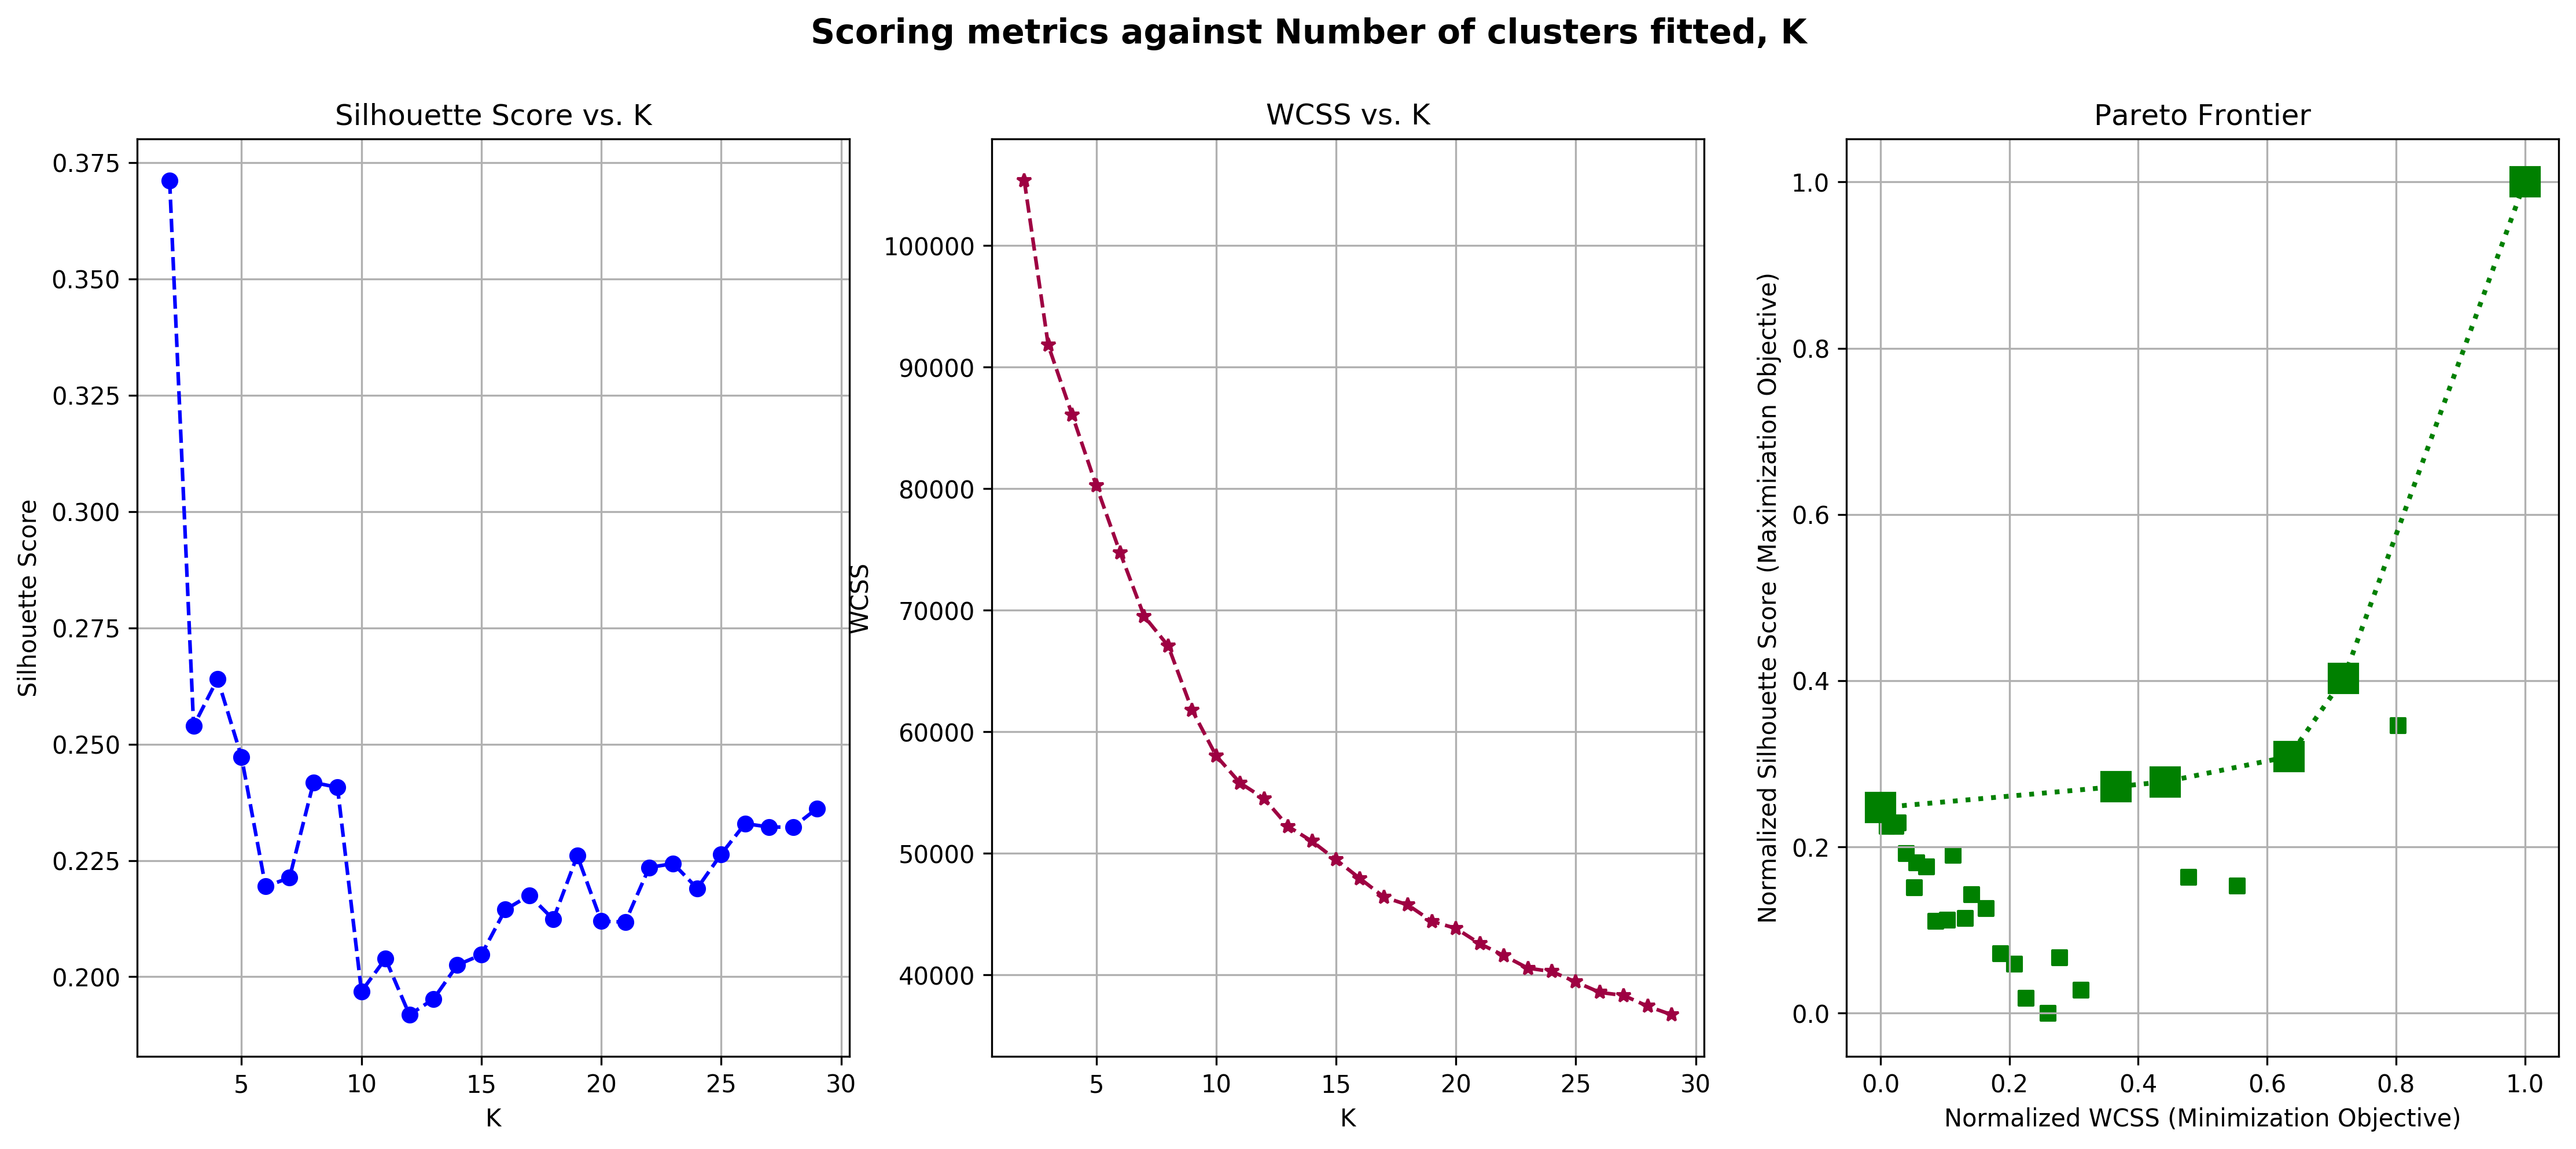

k: 2 MSE: 0.028927981863811878 MAE: 0.14066697060592478
k: 4 MSE: 0.03811063949765235 MAE: 0.16123748227555468
k: 5 MSE: 0.044717133021412184 MAE: 0.18863364829230397
k: 8 MSE: 0.03329319730067452 MAE: 0.15468816882315198
k: 9 MSE: 0.03595714890728242 MAE: 0.16364248757875136
k: 29 MSE: 0.04848855486549388 MAE: 0.1694574470798035


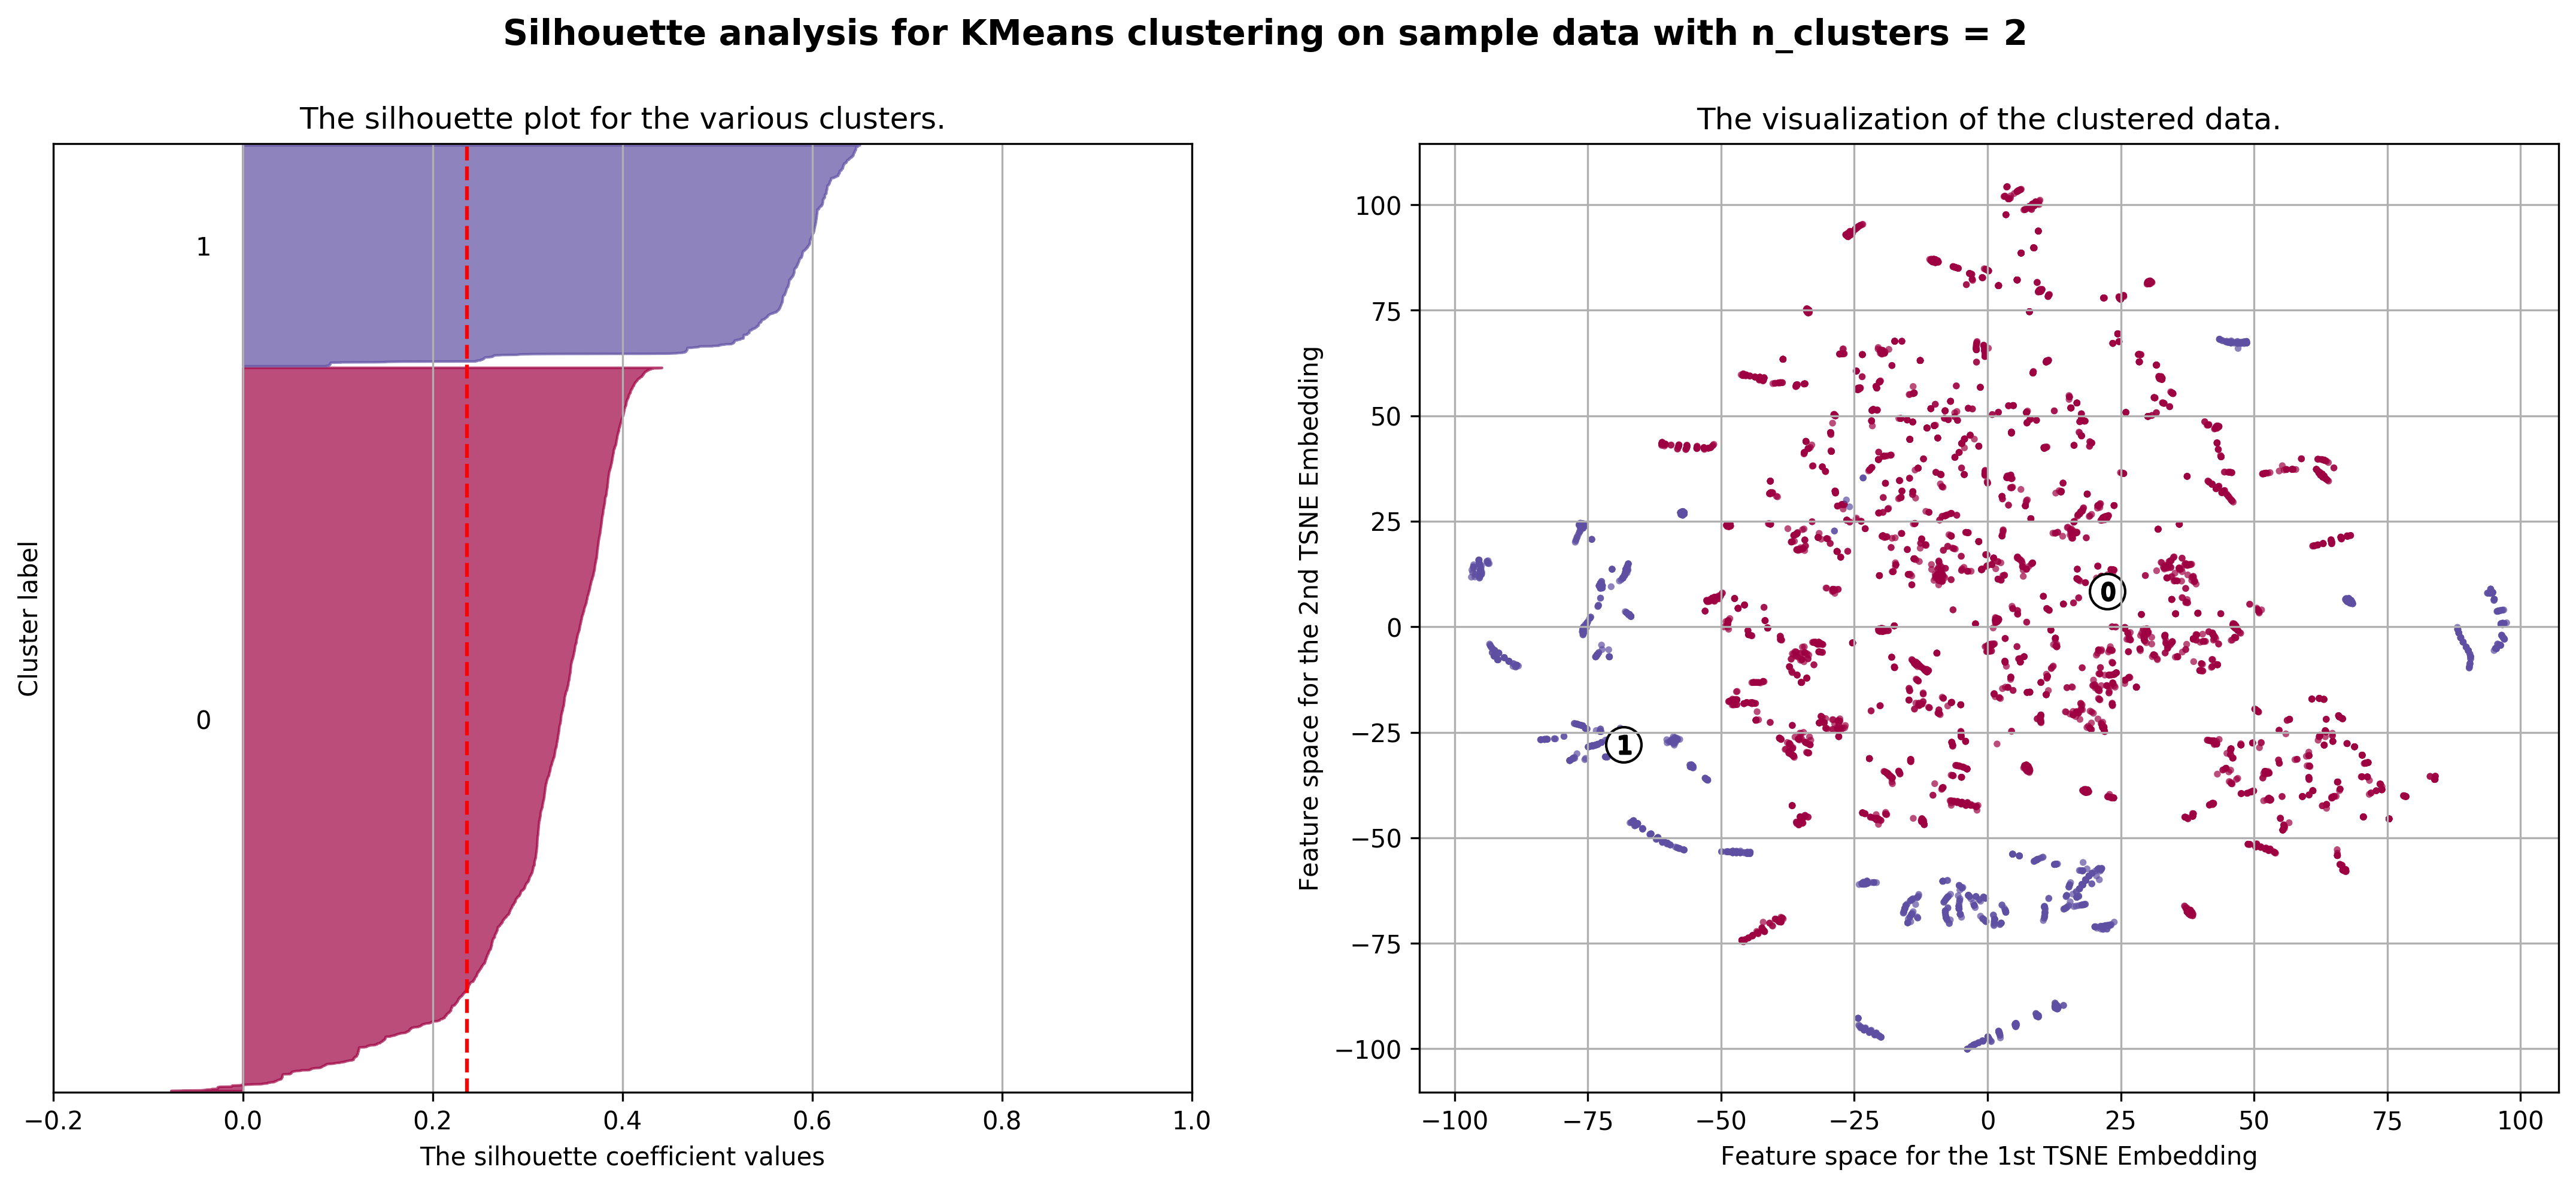

In [16]:
range_n_clusters = list(range(2, 30))
print('Cluster Analysis with selected scaled raw features of each condominium')
print(''.join(['-' for i in range(100)]))
print(''.join(['-' for i in range(100)]))
clustered_df = find_best_n_clusters(X_scaled, range_n_clusters, condo_X['District'], condo_X['link'])

In [17]:
def top_k_districts(condo_cluster, condo_counts_by_district, cluster, k=5):
    """
    Function:
    ---------
    Prints the top K highest frequency districts obtained from
    our cluster analysis
    
    Parameters:
    -----------
    condo_cluster: pandas series of index as the districts in singapore and values 
                   as the frequency of that district in the cluster predicted by the model
    condo_counts_by_district: pandas series of the counts of each district 
    cluster: the predicted cluster (int)
    k: top k highest frequency districts as a percentage of the total number of 
       samples of each district we have in predicted cluster
    
    Returns:
    --------
    None.
    """
    top_k_districts = [(district, sg_districts[district]) for district in condo_cluster.divide(condo_counts_by_district).sort_values()[-k:][::-1].index]
    print('Top {} districts associated with Predicted Cluster {}:'.format(k, cluster))
    print(''.join(['-' for i in range(50)]))
    for idx, district in enumerate(top_k_districts):
        print('{}. {} -'.format(idx+1, district[0]), district[1][0], '-', district[1][1])

def cluster_district_breakdown(df, condo_X):
    """
    Function:
    ---------
    Plots the breakdown of frequency of each singapore district inside the predicted cluster
    and overlayed over the total frequency of each district in the context of condominiums
    
    Parameters:
    -----------
    df: pandas dataframe returned from find_best_n_clusters
    condo_X: the original raw dataframe with just condos
    
    Returns:
    --------
    None.
    """
    print(''.join(['-' for i in range(100)]))
    print(''.join(['-' for i in range(100)]))
    
    # Plot the breakdown of district frequency for each cluster
    for cluster in range(df.pred_cluster.nunique()):
        
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(18, 7)

        # Plot the breakdown of total condos per district that we have in 
        # our dataset
        condo_counts_by_district = condo_X.groupby(['District']).count().loc[[*districts], 'price']
        condo_counts_by_district.index = condo_counts_by_district.index.map(lambda val: int(val[1:]))
        condo_counts_by_district.plot(
            kind='bar', 
            color=list(map(lambda val: np.append(val[:3], val[3]*0.1), get_colors(len(condo_counts_by_district)))),
            ax=ax
        ).grid()
        
        # Plot the district counts for a predicted cluster
        condo_cluster_counts = df[df['pred_cluster'] == int(cluster)]['District'].value_counts()
        condo_cluster = pd.Series(condo_cluster_counts, index=condo_counts_by_district.index).fillna(0.0).astype(int)
        condo_cluster.plot(
            kind='bar', 
            title='District Frequency for Condominiums in Predicted Cluster {}'.format(cluster), 
            color=get_colors(len(condo_cluster)),
            ax=ax
        ).grid()

        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x()+0.25, p.get_height()+10), 
                        va='bottom', 
                        ha='center',
                        fontsize=10)
            
        plt.tight_layout()
        plt.show()
        
        top_k_districts(condo_cluster, condo_counts_by_district, cluster)
        print(''.join(['-' for i in range(100)]))
        print(''.join(['-' for i in range(100)]))
        

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


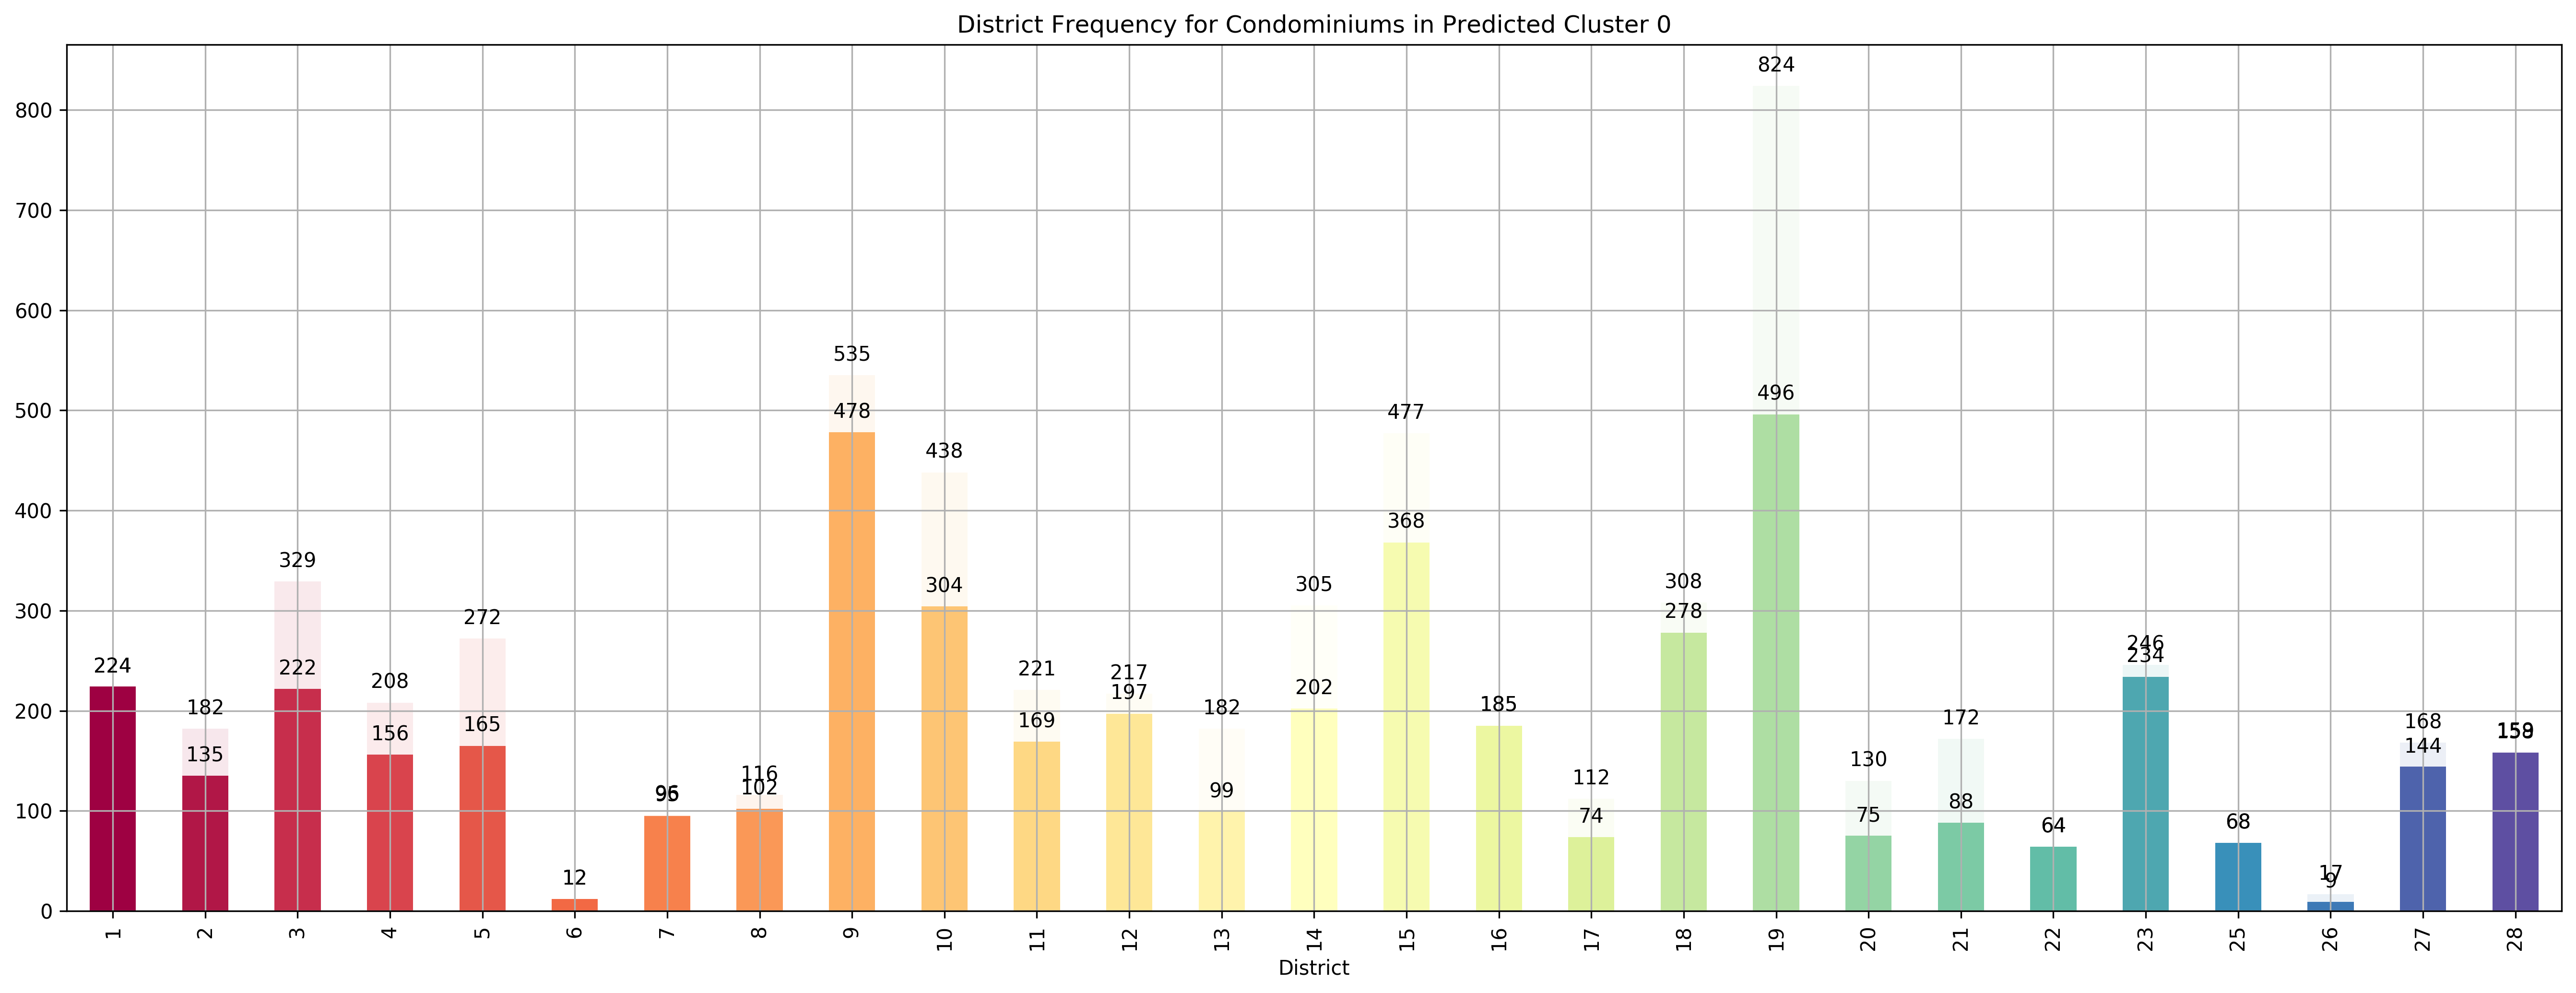

Top 5 districts associated with Predicted Cluster 0:
--------------------------------------------------
1. 1 - City Business District - Boat Quay, Chinatown, Havelock Road, Marina Square, Raffles Place, Suntec City
2. 22 - Far West - Boon Lay, Jurong, Tuas
3. 6 - City Business District - City Hall, High Street, North Bridge Road
4. 25 - Far North - Admiralty, Woodlands
5. 16 - Upper East Coast - Bayshore, Bedok, Chai Chee
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


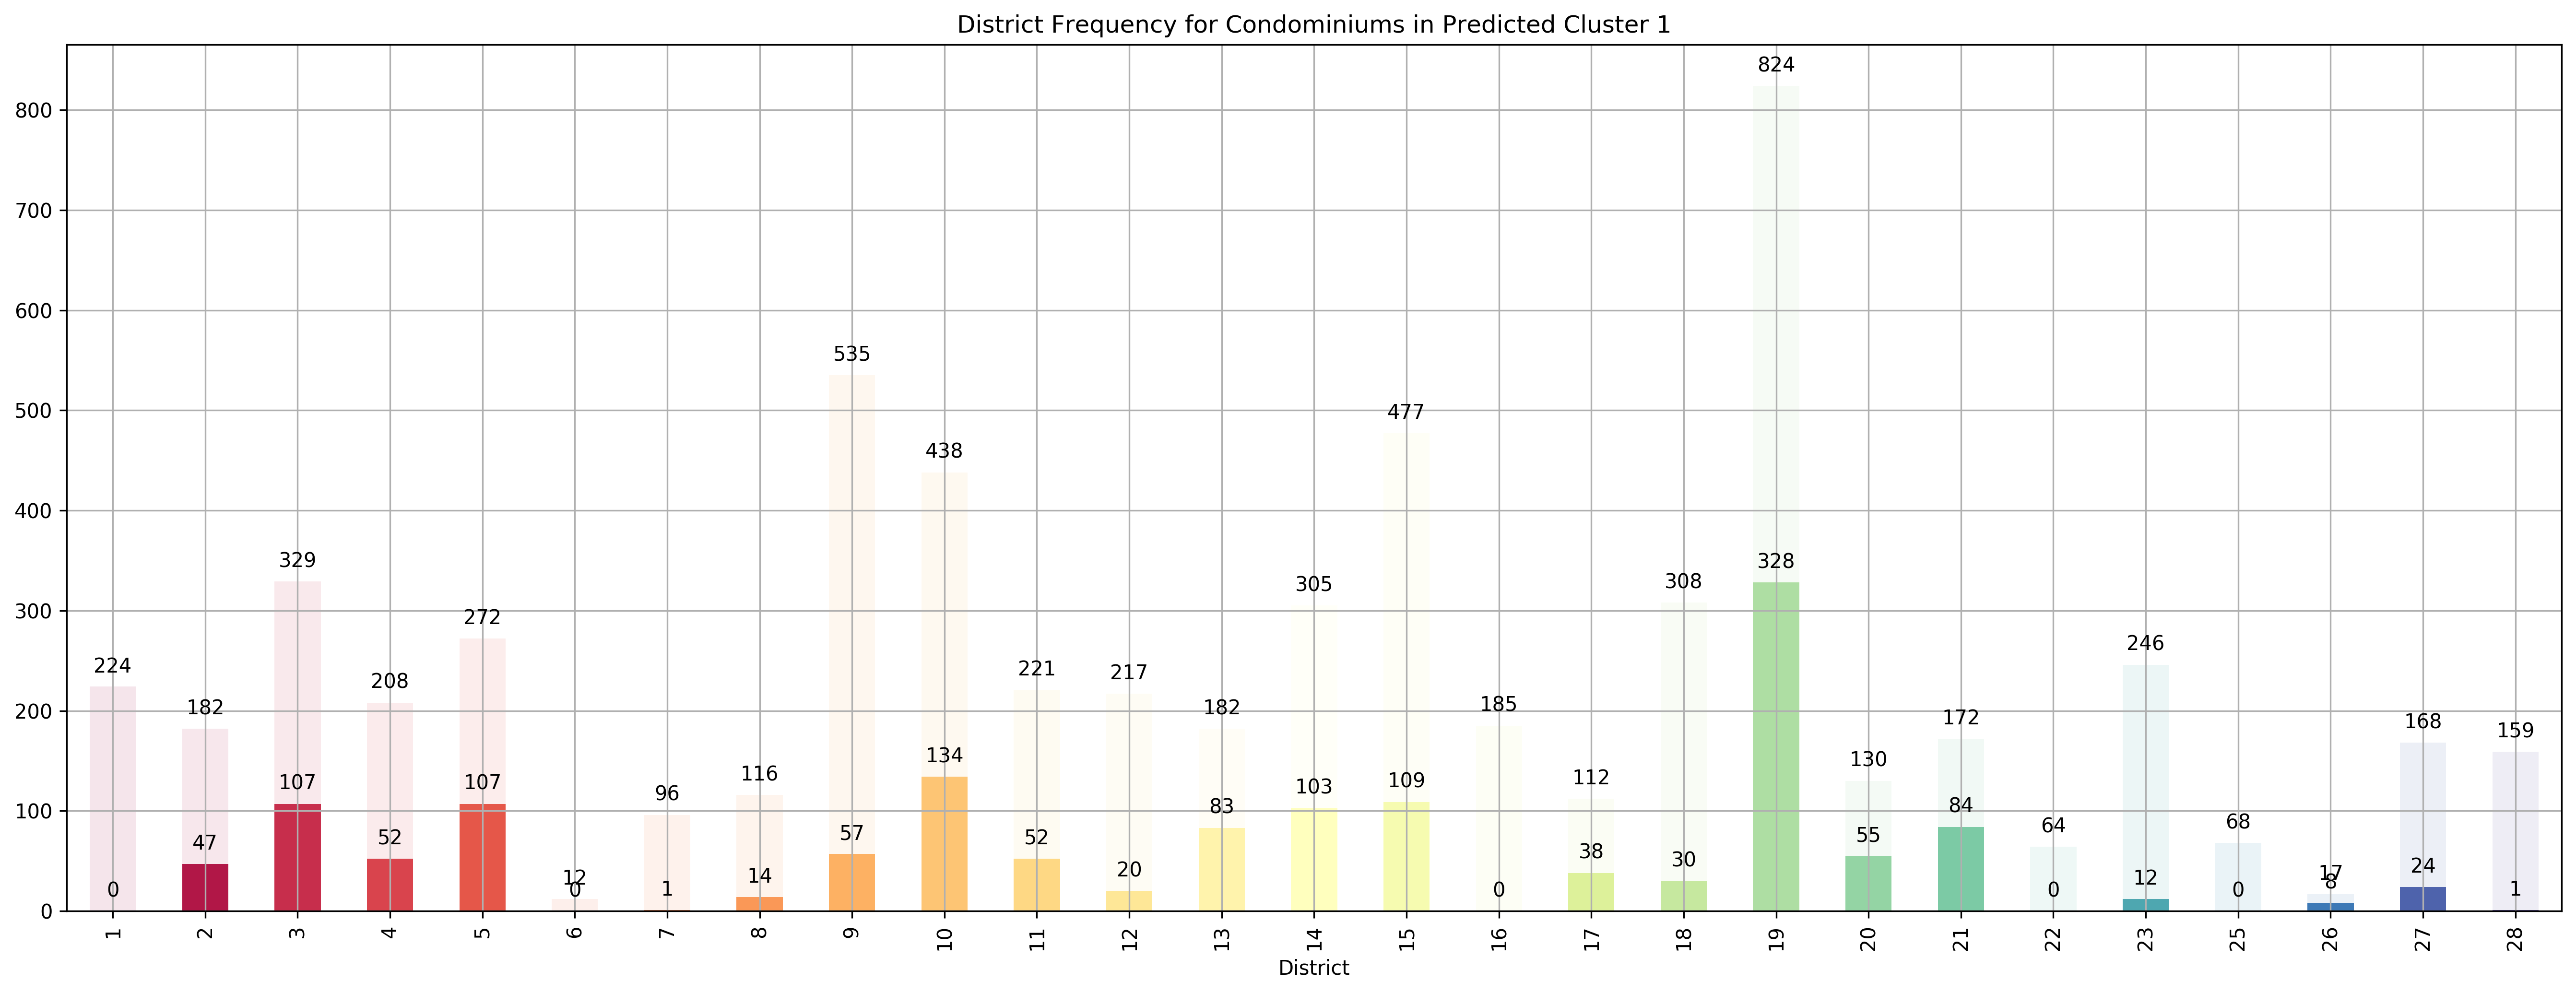

Top 5 districts associated with Predicted Cluster 1:
--------------------------------------------------
1. 21 - Central West - Clementi, Upper Bukit Timah, Hume Avenue
2. 26 - North - Tagore, Yio Chu Kang
3. 13 - Central East - Potong Pasir, Machpherson
4. 20 - Central North - Ang Mo Kio, Bishan, Braddell Road, Thomson
5. 19 - North East - Hougang, Punggol, Sengkang
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


In [18]:
cluster_district_breakdown(clustered_df, condo_X)

## 2. Feature Importance / Regression Analysis 

Out of the physical features of the property we have gathered in our dataset, are there any that are most helpful in predicting the price of the house?

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled.drop(['price'], axis=1), 
                                                    y_scaled, 
                                                    test_size=0.33, random_state=42)

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

In [21]:
y_pred = rf.predict(X_test)
mean_squared_error(y_true=y_scaler.inverse_transform(y_test), 
                   y_pred=y_scaler.inverse_transform(y_pred))**0.5

26352083.88233414

In [22]:
np.mean(np.abs(y_scaler.inverse_transform(y_test)-y_scaler.inverse_transform(y_pred)))

1493282.3772729372

In [23]:
Xy_test_pred = pd.concat([X_test, 
                          pd.Series(y_test, name='y_test', index=X_test.index), 
                          pd.Series(y_pred, name='y_pred', index=X_test.index)], axis=1)

outlier_pred_idxs = Xy_test_pred[Xy_test_pred['y_pred'] > 1][['sqft', 'y_test', 'y_pred']]

In [24]:
y_pred = rf.predict(X_test.drop(outlier_pred_idxs.index, axis=0))
mean_squared_error(y_true=y_scaler.inverse_transform(pd.Series(y_test, index=X_test.index).drop(outlier_pred_idxs.index, axis=0)), 
                   y_pred=y_scaler.inverse_transform(y_pred))**0.5

2657918.142430967

In [25]:
np.mean(np.abs(y_scaler.inverse_transform(pd.Series(y_test, 
                                                    index=X_test.index).drop(outlier_pred_idxs.index, 
                                                                             axis=0))-y_scaler.inverse_transform(y_pred)))

420308.28041881765

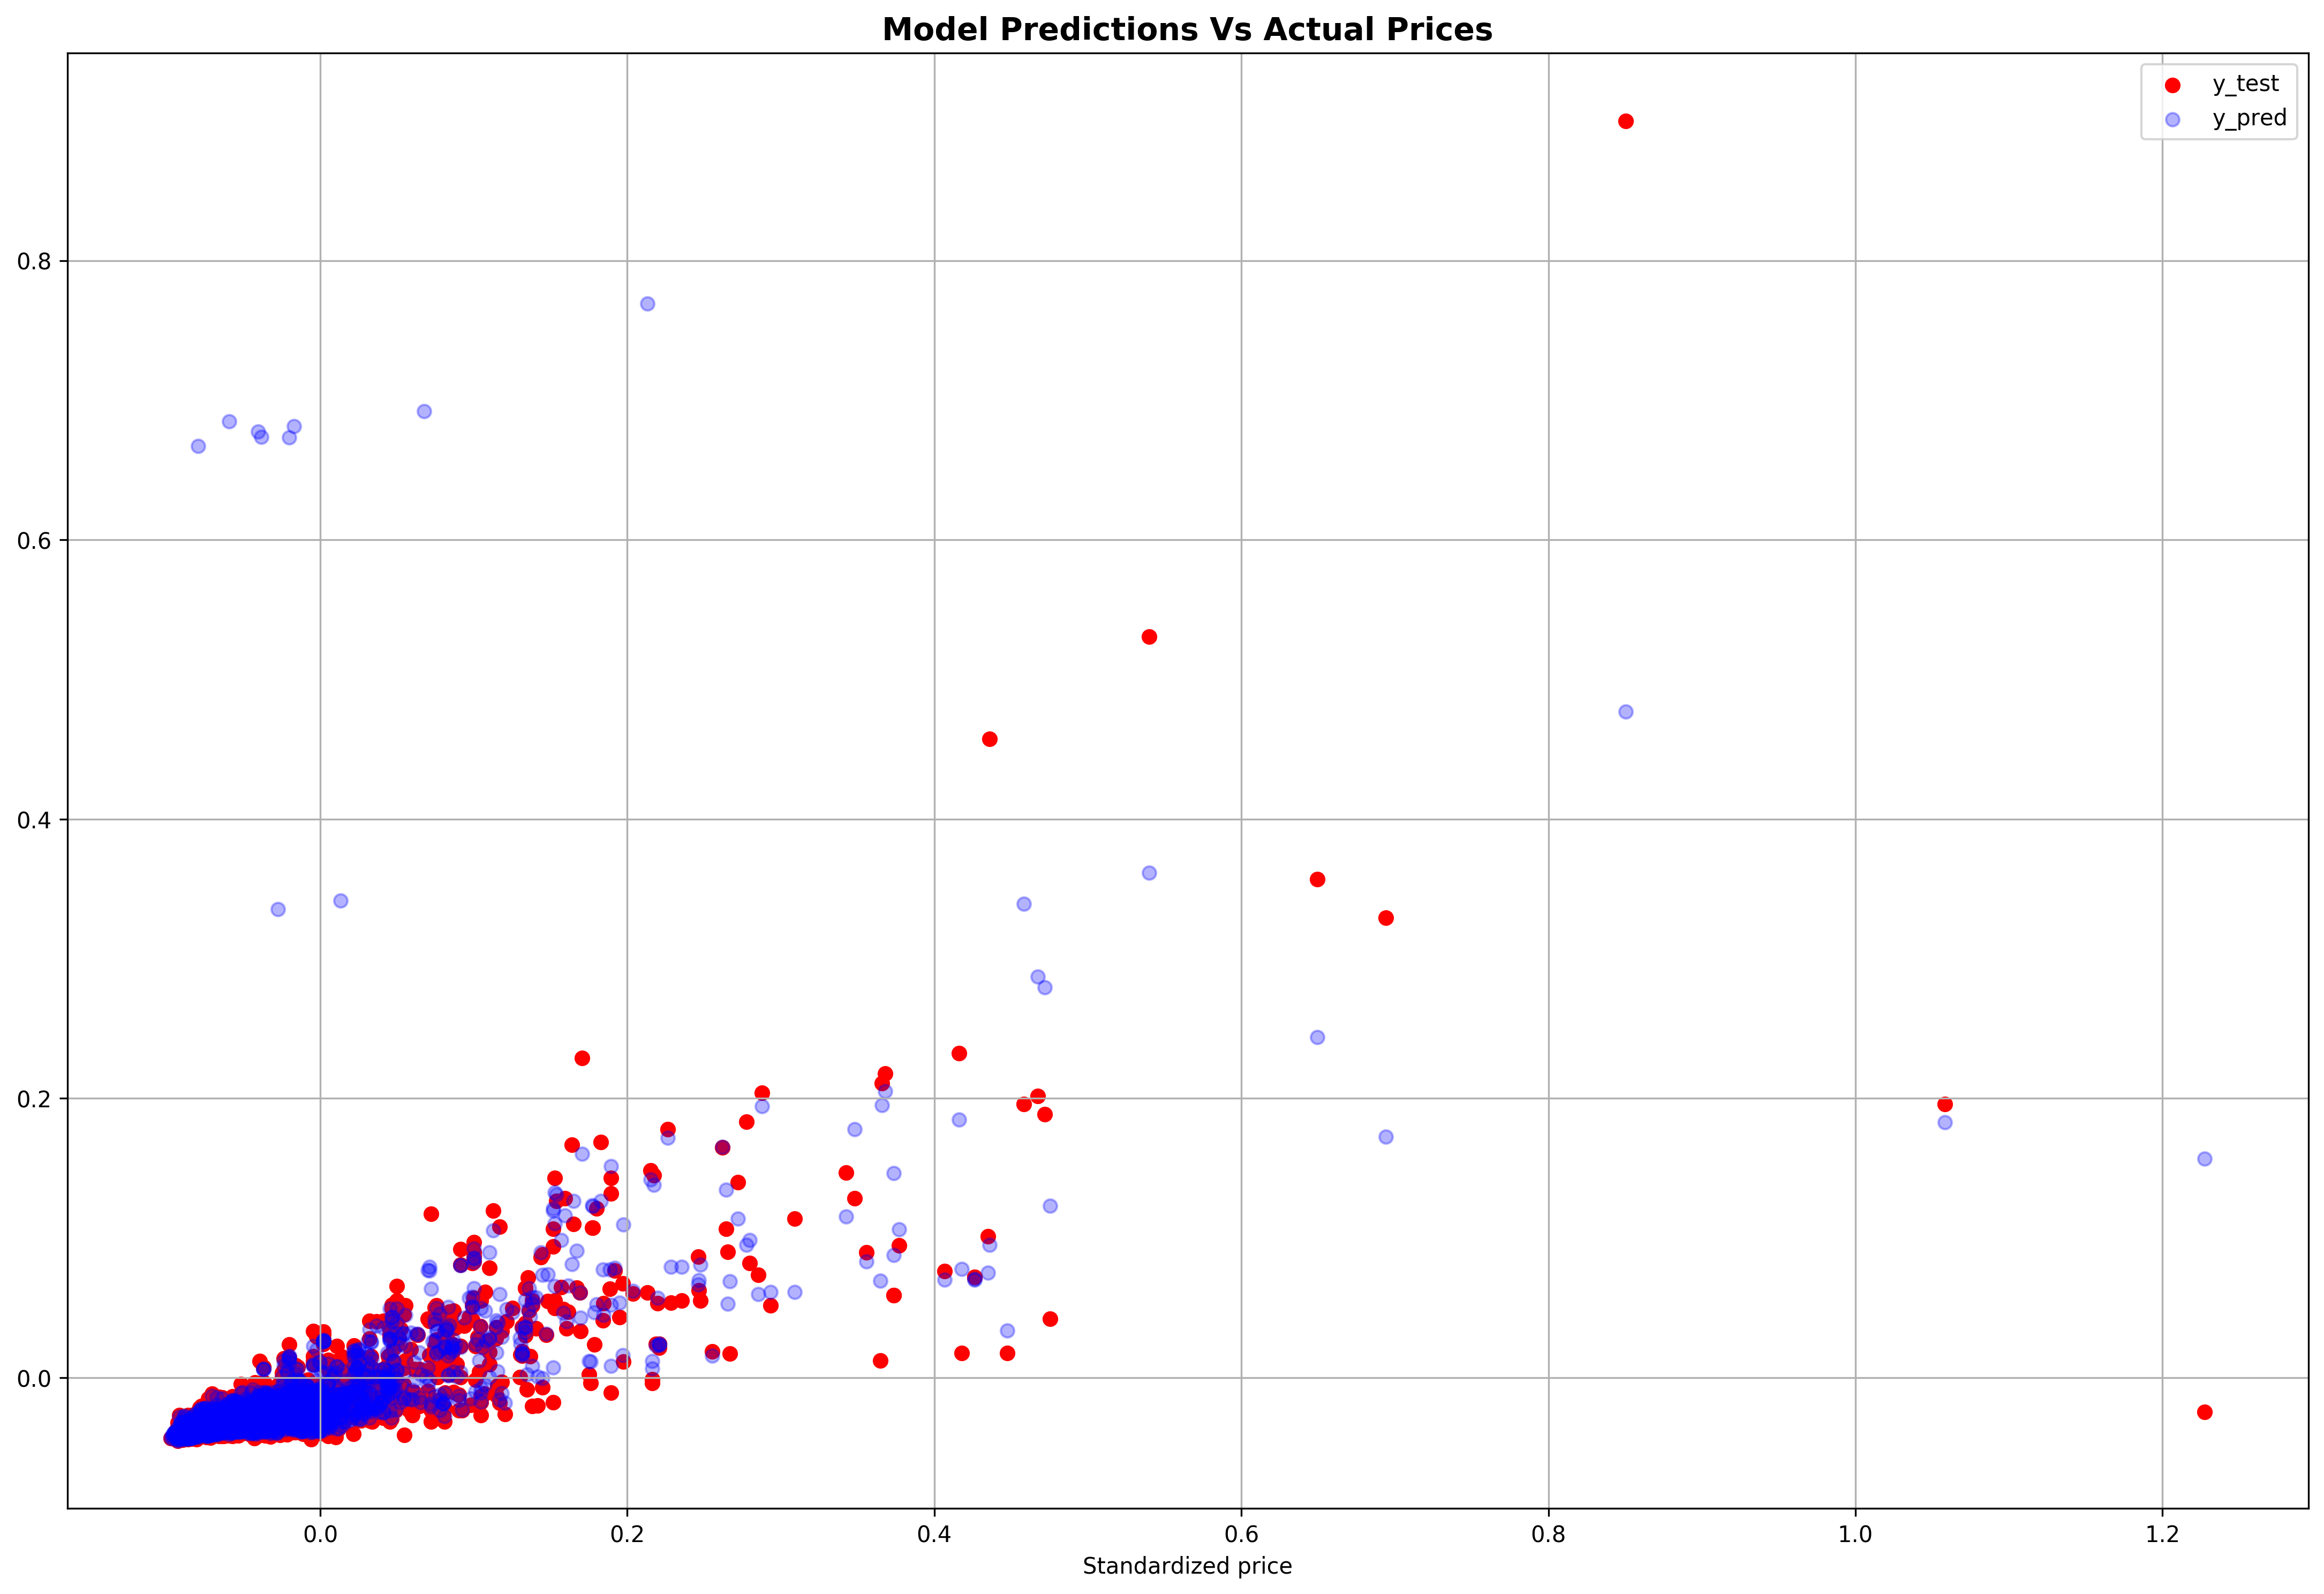

In [26]:
fig, ax = plt.subplots(1, 1)

ax.scatter(X_test.drop(outlier_pred_idxs.index, axis=0)['sqft'], pd.Series(y_test, index=X_test.index).drop(outlier_pred_idxs.index, axis=0), c='r', label='y_test')
ax.scatter(X_test.drop(outlier_pred_idxs.index, axis=0)['sqft'], y_pred, c='b', alpha=0.3, label='y_pred')
ax.set_xlabel('Standardized sqft')
ax.set_xlabel('Standardized price')
ax.grid()
ax.legend()
plt.title('Model Predictions Vs Actual Prices', fontsize=14, fontweight='bold')
plt.show();

In [27]:
def k_feature_plot(importances, columns, k=5):
    ''' 
    Function:
    ---------
    Plots the k most important features
    given a feature_importance_ from an sklearn model
    
    Parameters:
    -----------
    importances: The feature_importances_ from a sklearn model that supports it
    columns: The feature names of those that were used in fitting the model
    k: The top k features that were important in the prediction
    
    Returns:
    --------
    None
    '''
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = columns.values[indices[:k]]
    values = importances[indices][:k]

    # Creat the plot
    fig = plt.figure()
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 15)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns, rotation=45, fontsize = 15)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 15)
    plt.xlabel("Feature", fontsize = 15)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.grid()
    plt.show()

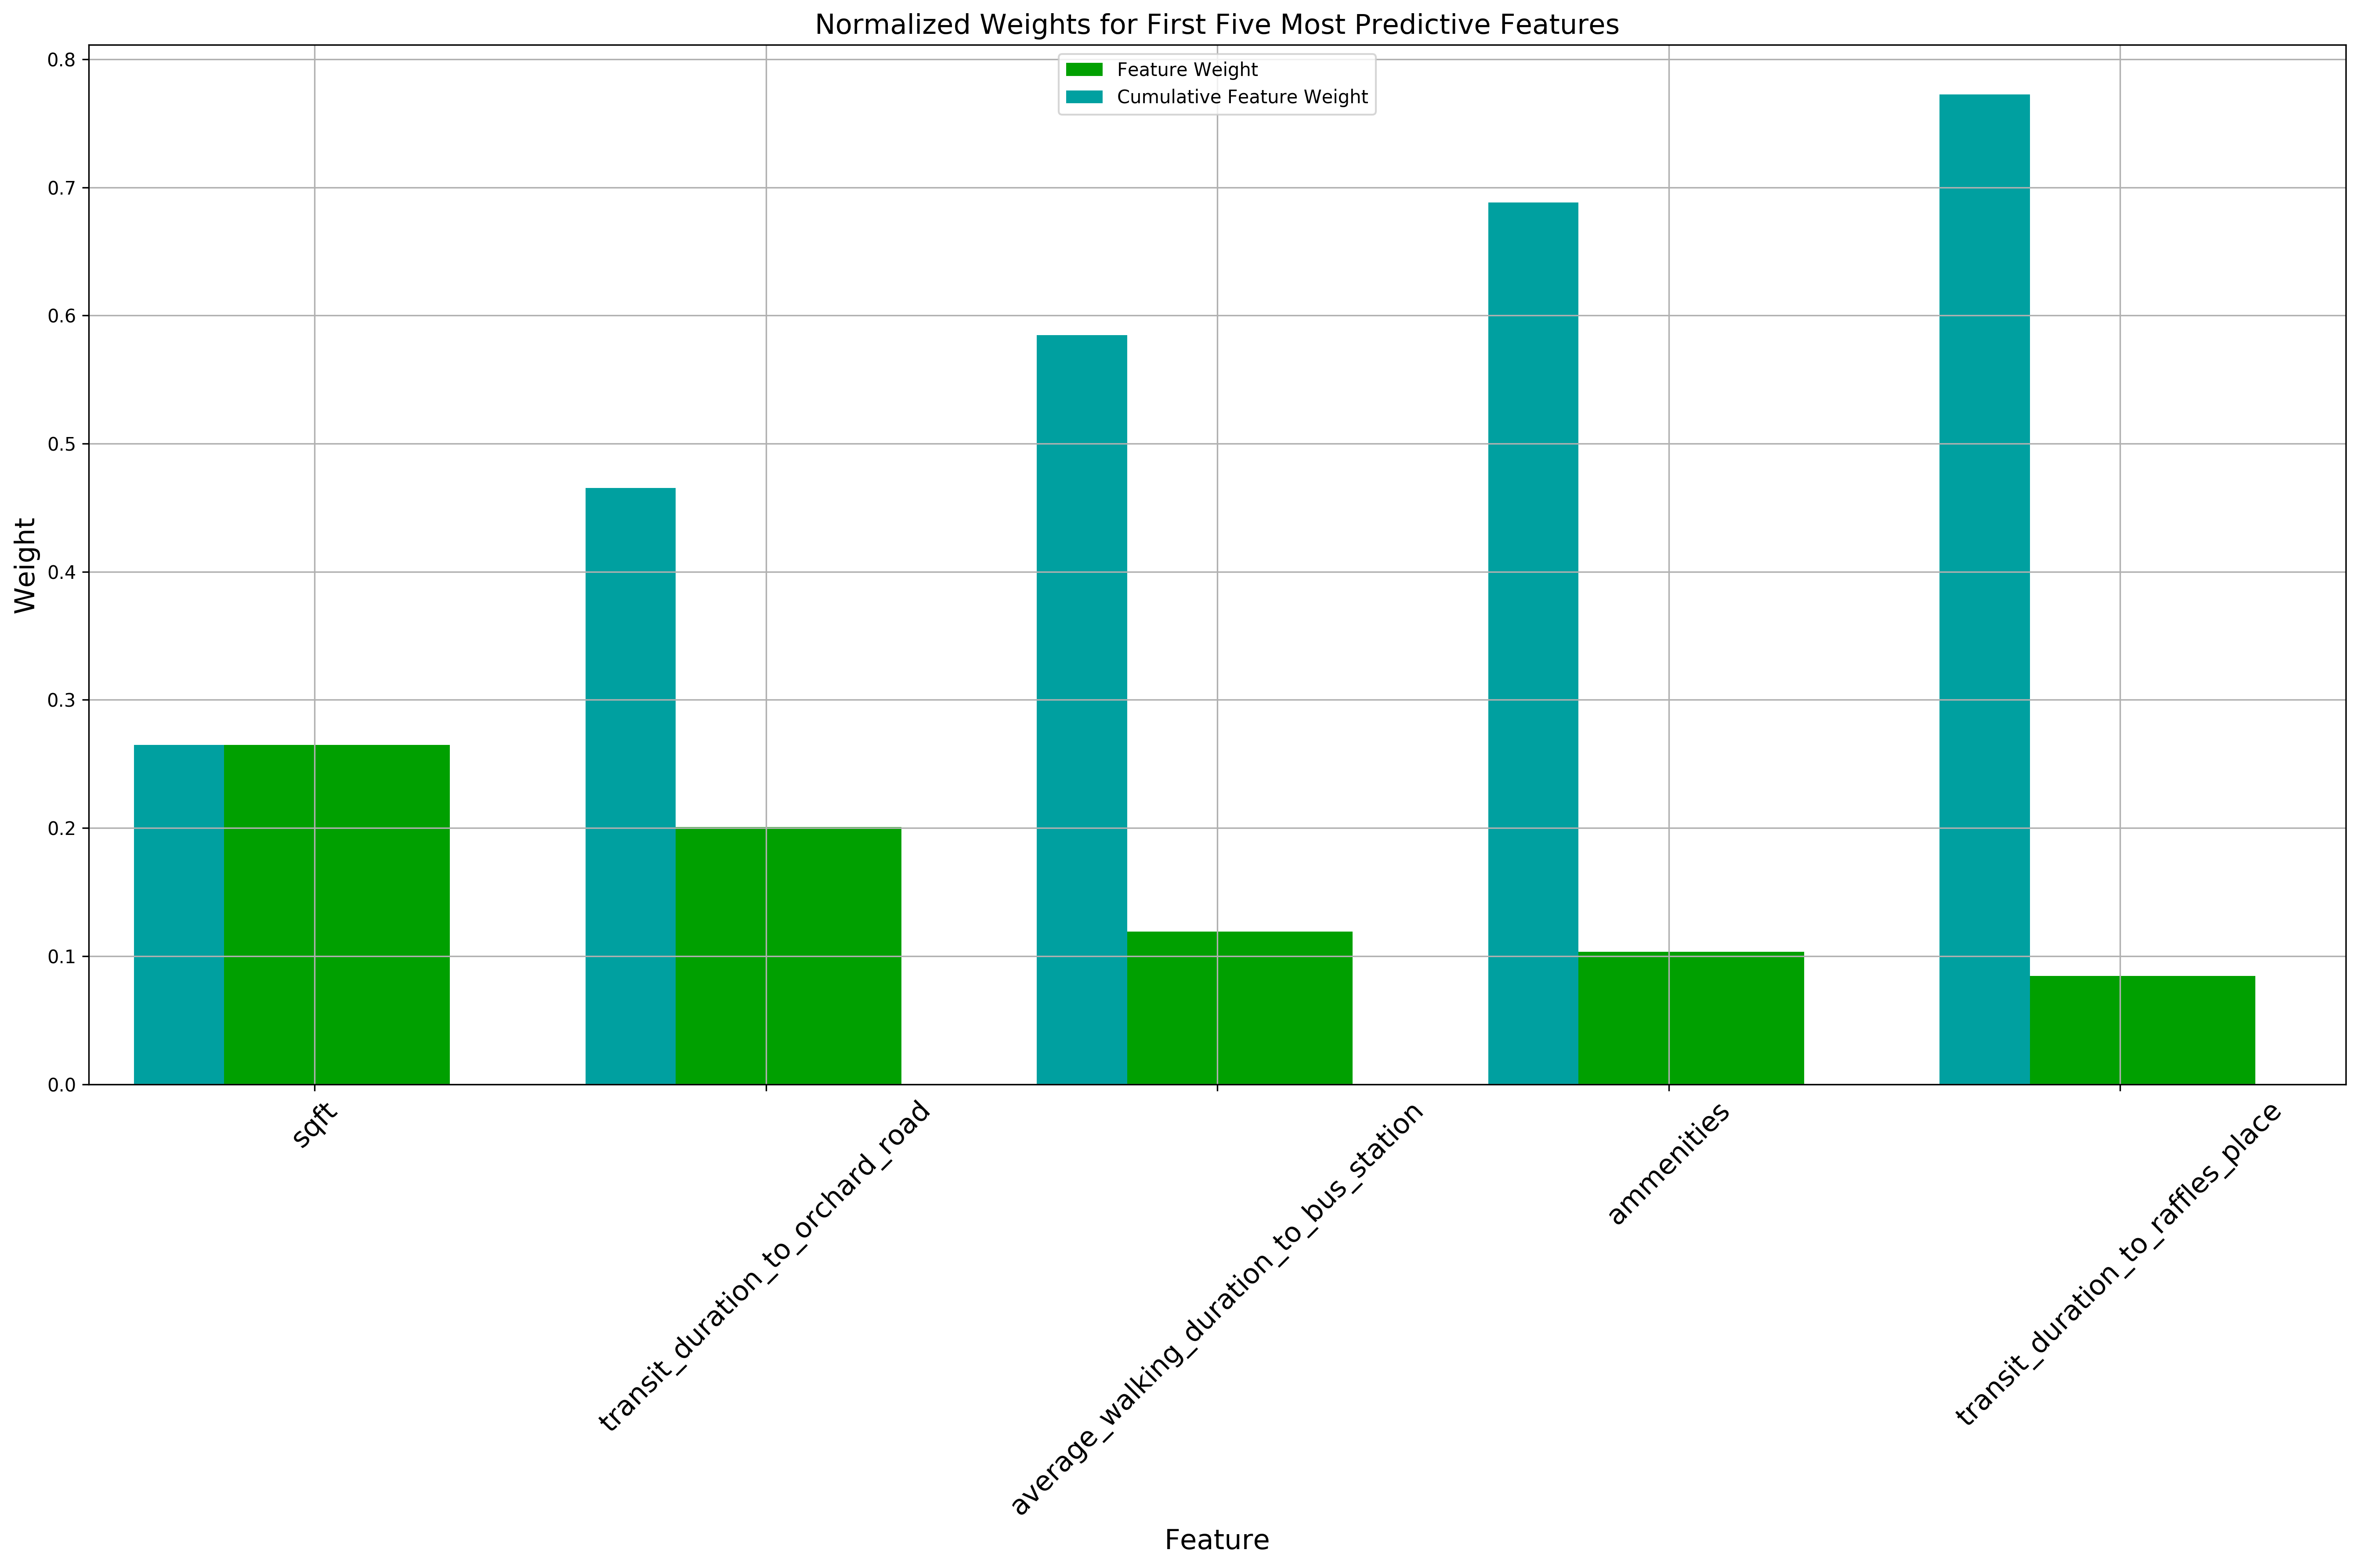

In [28]:
k_feature_plot(rf.feature_importances_, X_scaled.drop(['price'], axis=1).columns)

## 3. Popularity

What are the "hottest" properties now, especially in the District 9 area (Shopping district)?

In [29]:
import re
import urllib
import pickle
from imp import reload
import webscraper_99co
from webscraper_99co import *

reload(webscraper_99co);

In [30]:
class TransactionHistory():
    """
    Purpose:
    --------
    To act as a placeholder for a class' transaction history related
    data

    Parameters:
    -----------
    cluster_id: A str containing the cluster_id of the specific condominium
    rent_df: A pandas dataframe of the rental transaction history returned by get_transact_history
    sale_df: A pandas dataframe of the sale transaction history returned by get_transact_history
    price_trends_dict: Dictionary of the price trend features returned by get_price_trends
    """
    def __init__(self, url, cluster_id, 
                 rent_df, sale_df, price_trends_dict):
        self.url = url
        self.cluster_id = cluster_id
        self.rent = rent_df
        self.sale = sale_df
        self.price_trends = price_trends_dict

def save_object(obj, filename):
    """
    Function:
    ---------
    Pickles an object (Class definition still required to unpickle the object)
    
    Parameters:
    -----------
    obj: object to be pickled
    filename: file to save the object to
    """
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def get_transactions(X, districts=[9, 10]):
    """
    Function:
    ---------
    To retrieve the transaction history related data for all 
    districts interested and save them to a json file
    
    Parameters:
    -----------
    X: The dataframe containing the condo features with links to property page and district label
    districts: A list of the districts of interest in int
    
    Returns:
    --------
    Returns a dictionary of key: cluster_id, val: TransactionHistory object containing 
    data related to the property and also saves the data to a json file
    """
    # The transaction history dictionary that will keep 
    # all the data
    transaction_history = {}
    try:
        for idx in districts:
            for condo_url in tqdm(X[X['District'] == 'D{}'.format(idx)]['link'].values):
                cluster_id = get_cluster_id(condo_url) # Retrieve cluster id from property page
                if cluster_id != None:
                    # Create TransactionHistory object with the data
                    transaction_history[cluster_id] = TransactionHistory(
                        url=condo_url,
                        cluster_id=cluster_id,
                        rent_df=get_transact_history(cluster_id=cluster_id, 
                                                     transaction_type='rent').set_index(['Date']),
                        sale_df=get_transact_history(cluster_id=cluster_id,
                                                     transaction_type='sale').set_index(['Date']),
                        price_trends_dict=get_price_trends(cluster_id=cluster_id)
                    )
                else:
                    print('cluster_id for {} could not be found ...'.format(condo_url))
                # Save the TransactionHistory objects acquired after each property scraping
                save_object(transaction_history, './data/99.co/transaction_history.pkl')

    finally:
        save_object(transaction_history, './data/99.co/transaction_history.pkl')
        return transaction_history

In [31]:
condo_transaction_history = get_transactions(condo_X, districts=[9])

 16%|█▌        | 83/535 [46:10<3:53:55, 31.05s/it]

In [32]:
condo_transaction_history_saved = pickle.load(open("./data/99.co/transaction_history.pkl", "rb"))

In [33]:
def get_property_dev_shape(url):
    """
    Function:
    ---------
    Retrieves the latitude and longitude coordinates from 99.co's 
    webpage through the specified url, and get's the coordinates of the master plan
    area from URA
    
    Parameters:
    -----------
    url: The property development webpage from 99.co
    
    Returns:
    --------
    Polygon object of the coordinates of the property development
    """
    res = requests.get(url)
    if res.ok:
        if 'query_coords' in res.text:
            query_coords_pos = res.text.find('query_coords')
            first_occurence = [res.text[match.start():match.end()+100] for match in re.finditer('query_coords', res.text)][0]
            if '=' in first_occurence:
                y, x = urllib.parse.unquote(first_occurence.split('=')[1].split('&')[0]).split(',')
            else:
                y, x = first_occurence.split(':')[1].replace('\"', '').split(',')[:2]
            
            params = {
                'returnGeometry': 'true', 
                'where': '1=1',
                'outSr': '4326', 
                'outFields': 'name,lu_desc,lu_dt_cd,gpr_num,region_n,pln_area_n,subzone_n',
                'inSr': '4326',
                'geometry': str({'x': float(x), 'y': float(y), 'spatialReference': {'wkid': 4326} }),
                'geometryType': 'esriGeometryPoint',
                'spatialRel': 'esriSpatialRelWithin', 
                'f':'json'
            }

            # Get the Shape of the property development from
            # the URA website
            ura_res = requests.get('https://www.ura.gov.sg/arcgis/rest/services/maps2/Updated_Gaz_MP14_Land_Use_Maps/MapServer/55/query', 
                                   params=params)
            
            if ura_res.ok:
                return Polygon(json.loads(ura_res.text)['features'][0]['geometry']['rings'][0])
            else:
                print('Failed to request coordinates from URA ...')
        else:
            print('Failed to find query_coords from {} source ...'.format(url))
    else:
        print('Failed to request {} ...'.format(url))
        
def get_development_gdf(condo_transaction_history_saved):
    """
    Function:
    ---------
    Retrieve the 
    """
    property_development_info = []
    for idx, (condo_cluster_id, transaction_history_data) in tqdm(enumerate(condo_transaction_history_saved.items())):
        property_development_info.append((condo_cluster_id, 
                                          transaction_history_data.url.split('/')[-1], 
                                          get_property_dev_shape(transaction_history_data.url)))
            
    # Unzip the data
    ids, names, shapes = list(zip(*property_development_info))  
    
    # Create the Geodataframe
    development_gdf = gpd.GeoDataFrame(data=list(zip(names, shapes)),
                                       columns=['name', 'geometry'],
                                       geometry='geometry',
                                       index=ids)

    # Initialize which Coordinate Reference System
    # the Polygons are from
    development_gdf.crs = {'init': 'epsg:4326'}

    # Convert to Singapore's Coordinate Reference System
    development_gdf.to_crs({'init': 'epsg:3414'}, inplace=True)
    
    # Add the areas of each property to the dataframe and return it
    return gpd.pd.concat([development_gdf, 
                          pd.Series([shape.area for shape in development_gdf['geometry']],
                                    name='area',
                                    index=development_gdf.index)], axis=1)

In [34]:
development_gdf = get_development_gdf(condo_transaction_history_saved)


0it [00:00, ?it/s]
1it [00:01,  1.67s/it]
2it [00:02,  1.41s/it]
3it [00:05,  1.81s/it]
4it [00:07,  1.85s/it]
5it [00:08,  1.75s/it]
6it [00:10,  1.76s/it]
7it [00:12,  1.79s/it]
8it [00:13,  1.73s/it]
9it [00:15,  1.65s/it]
10it [00:16,  1.55s/it]
11it [00:18,  1.61s/it]
12it [00:19,  1.52s/it]
13it [00:20,  1.36s/it]
14it [00:23,  1.65s/it]
15it [00:24,  1.60s/it]
16it [00:26,  1.58s/it]
17it [00:27,  1.64s/it]
18it [00:28,  1.37s/it]
19it [00:29,  1.32s/it]
20it [00:31,  1.43s/it]
21it [00:32,  1.26s/it]
22it [00:34,  1.49s/it]
23it [00:35,  1.39s/it]
24it [00:36,  1.21s/it]
25it [00:38,  1.34s/it]
26it [00:39,  1.34s/it]
27it [00:40,  1.34s/it]
28it [00:42,  1.35s/it]
29it [00:47,  2.52s/it]
30it [00:48,  2.07s/it]
31it [00:49,  1.82s/it]
32it [00:50,  1.66s/it]
33it [00:51,  1.43s/it]
34it [00:53,  1.40s/it]
35it [00:55,  1.86s/it]
36it [00:57,  1.78s/it]
37it [00:59,  1.78s/it]
38it [01:01,  1.76s/it]
39it [01:01,  1.50s/it]
40it [01:02,  1.32s/it]
41it [01:03,  1.21s/it]
42it 

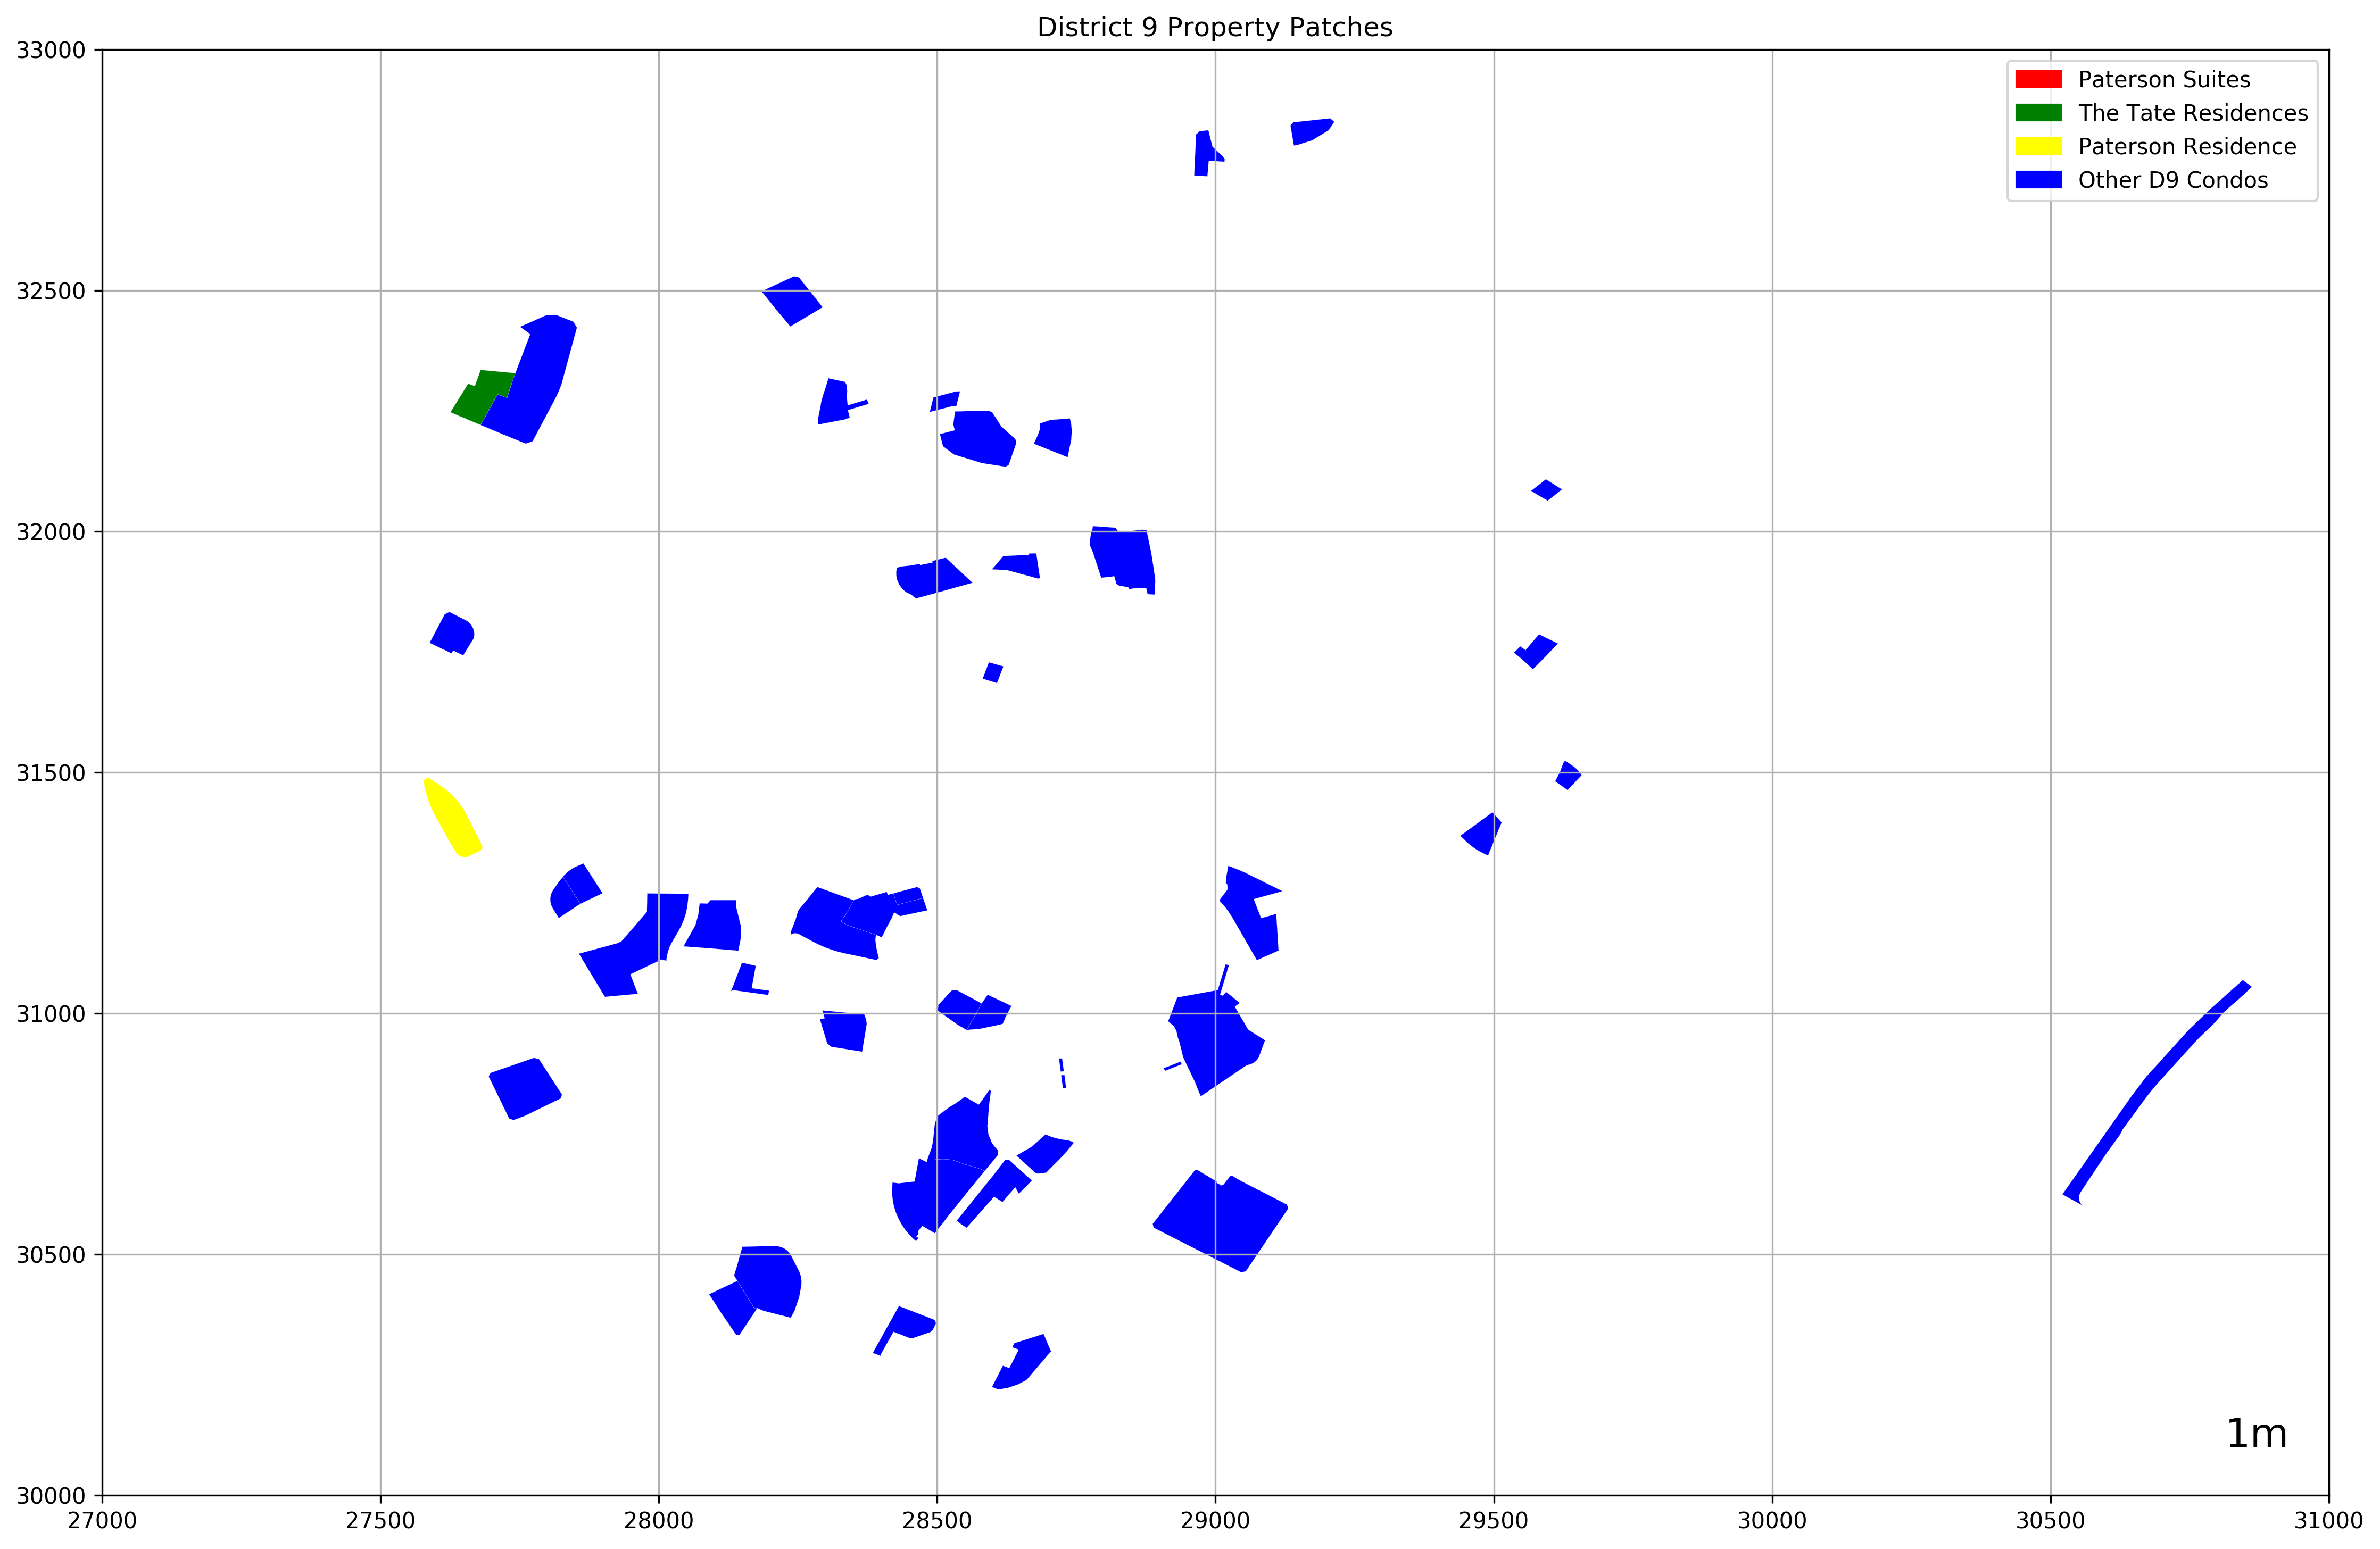

In [35]:
fontprops = fm.FontProperties(size=18)
fig, ax = plt.subplots(1, 1, sharex=True)

for cluster_id, row in development_gdf[['name', 'geometry']].iterrows():
    if row['name'] == 'paterson-suites':
        ax.add_patch(PolygonPatch(row['geometry'], fc='red', ec=[1,1,1], linewidth=0.05))
    elif row['name'] == 'the-tate-residences':
        ax.add_patch(PolygonPatch(row['geometry'], fc='green', ec=[1,1,1], linewidth=0.05))
    elif row['name'] == 'paterson-residence':
        ax.add_patch(PolygonPatch(row['geometry'], fc='yellow', ec=[1,1,1], linewidth=0.05))
    else:
        ax.add_patch(PolygonPatch(row['geometry'], fc='blue', ec=[1,1,1], linewidth=0.05))
        
bar = AnchoredSizeBar(transform=ax.transData, 
                      size=1, 
                      label='1m', 
                      loc=4, 
                      pad=0.5, 
                      sep=5, 
                      borderpad=0.5, 
                      frameon=False, 
                      size_vertical=0.5, 
                      color='black', 
                      fontproperties=fontprops)
ax.add_artist(bar)

red_patch = mpatches.Patch(color='red', label='Paterson Suites')
green_patch = mpatches.Patch(color='green', label='The Tate Residences')
yellow_patch = mpatches.Patch(color='yellow', label='Paterson Residence')
blue_patch = mpatches.Patch(color='blue', label='Other D9 Condos')
plt.legend(handles=[red_patch, green_patch, yellow_patch, blue_patch])

ax.set_xlim(left=27e3, right=31e3)
ax.set_ylim(bottom=30e3, top=33e3)
ax.set_title('District 9 Property Patches')
plt.grid(True)
plt.show();

In [36]:
condo_of_interest = 'paterson-suites'
condo_of_interest_transaction_history = None
for condo_cluster_id, transaction_history_data in condo_transaction_history_saved.items():
    if transaction_history_data.url.split('/')[-1] == condo_of_interest:
        condo_of_interest_transaction_history = transaction_history_data

In [37]:
condo_of_interest_transaction_history.sale.index = pd.to_datetime(condo_of_interest_transaction_history.sale.index)

AttributeError: 'NoneType' object has no attribute 'sale'

In [ ]:
condo_of_interest_transaction_history.sale['Price (psf)'].apply(lambda val: float(val[2:-1])).describe()

---
# Boulevard Vue

In [38]:
def get_prices(row):
    if len(re.sub('[^0-9\.]', '', row['Price (psf)'])) > 0 and len(re.sub('[^0-9]', '', row['Unit'])) > 0:
        price = float(re.sub('[^0-9\.]', '', row['Price (psf)']))
        area = float(row['Area'].split()[0].replace(',', ''))
        floor = int(re.sub('[^0-9]', '', row['Unit']))
        if row['Price (psf)'][-1] == 'M':
            return ((price/area)*1e6, 
                    floor,
                    price*1e6, 
                    row['days_since_transaction'])  
        elif row['Price (psf)'][-1] == 'B': 
            return ((price/area)*1e9,
                    floor, 
                    price*1e9, 
                    row['days_since_transaction'])
        else:
            return ((price/area),
                    floor, 
                    price, 
                    row['days_since_transaction'])

In [39]:
condos_of_interest = {
    'boulevard-vue': None, 
    'orchard-view': None, 
    'skyline-orchard-boulevard': None, 
    'twentyone-angullia-park': None,
    'the-paterson-edge': None,
    'paterson-linc': None
}

In [40]:
condos_of_interest_transaction_history = {}

for key in tqdm(condos_of_interest.keys()):
    cluster_id = get_cluster_id('https://www.99.co/singapore/condos-apartments/{}'.format(key))
    condo_of_interest = get_transact_history(
        cluster_id=cluster_id, 
        transaction_type='sale').set_index(['Date'])
    
    condos_of_interest[key] = pd.concat([condo_of_interest, 
                                         pd.Series([(datetime.today() - datetime.strptime(date, '%d/%m/%Y')).days for date in condo_of_interest.index], 
                                                   index=condo_of_interest.index, name='days_since_transaction')], 
                                        axis=1)
    # Create TransactionHistory object with the data
    condos_of_interest_transaction_history[cluster_id] = TransactionHistory(
        url='https://www.99.co/singapore/condos-apartments/{}'.format(key),
        cluster_id=cluster_id,
        rent_df=get_transact_history(cluster_id=cluster_id, 
                                     transaction_type='rent').set_index(['Date']),
        sale_df=condo_of_interest,
        price_trends_dict=get_price_trends(cluster_id=cluster_id)
    )


100%|██████████| 6/6 [02:49<00:00, 28.51s/it]

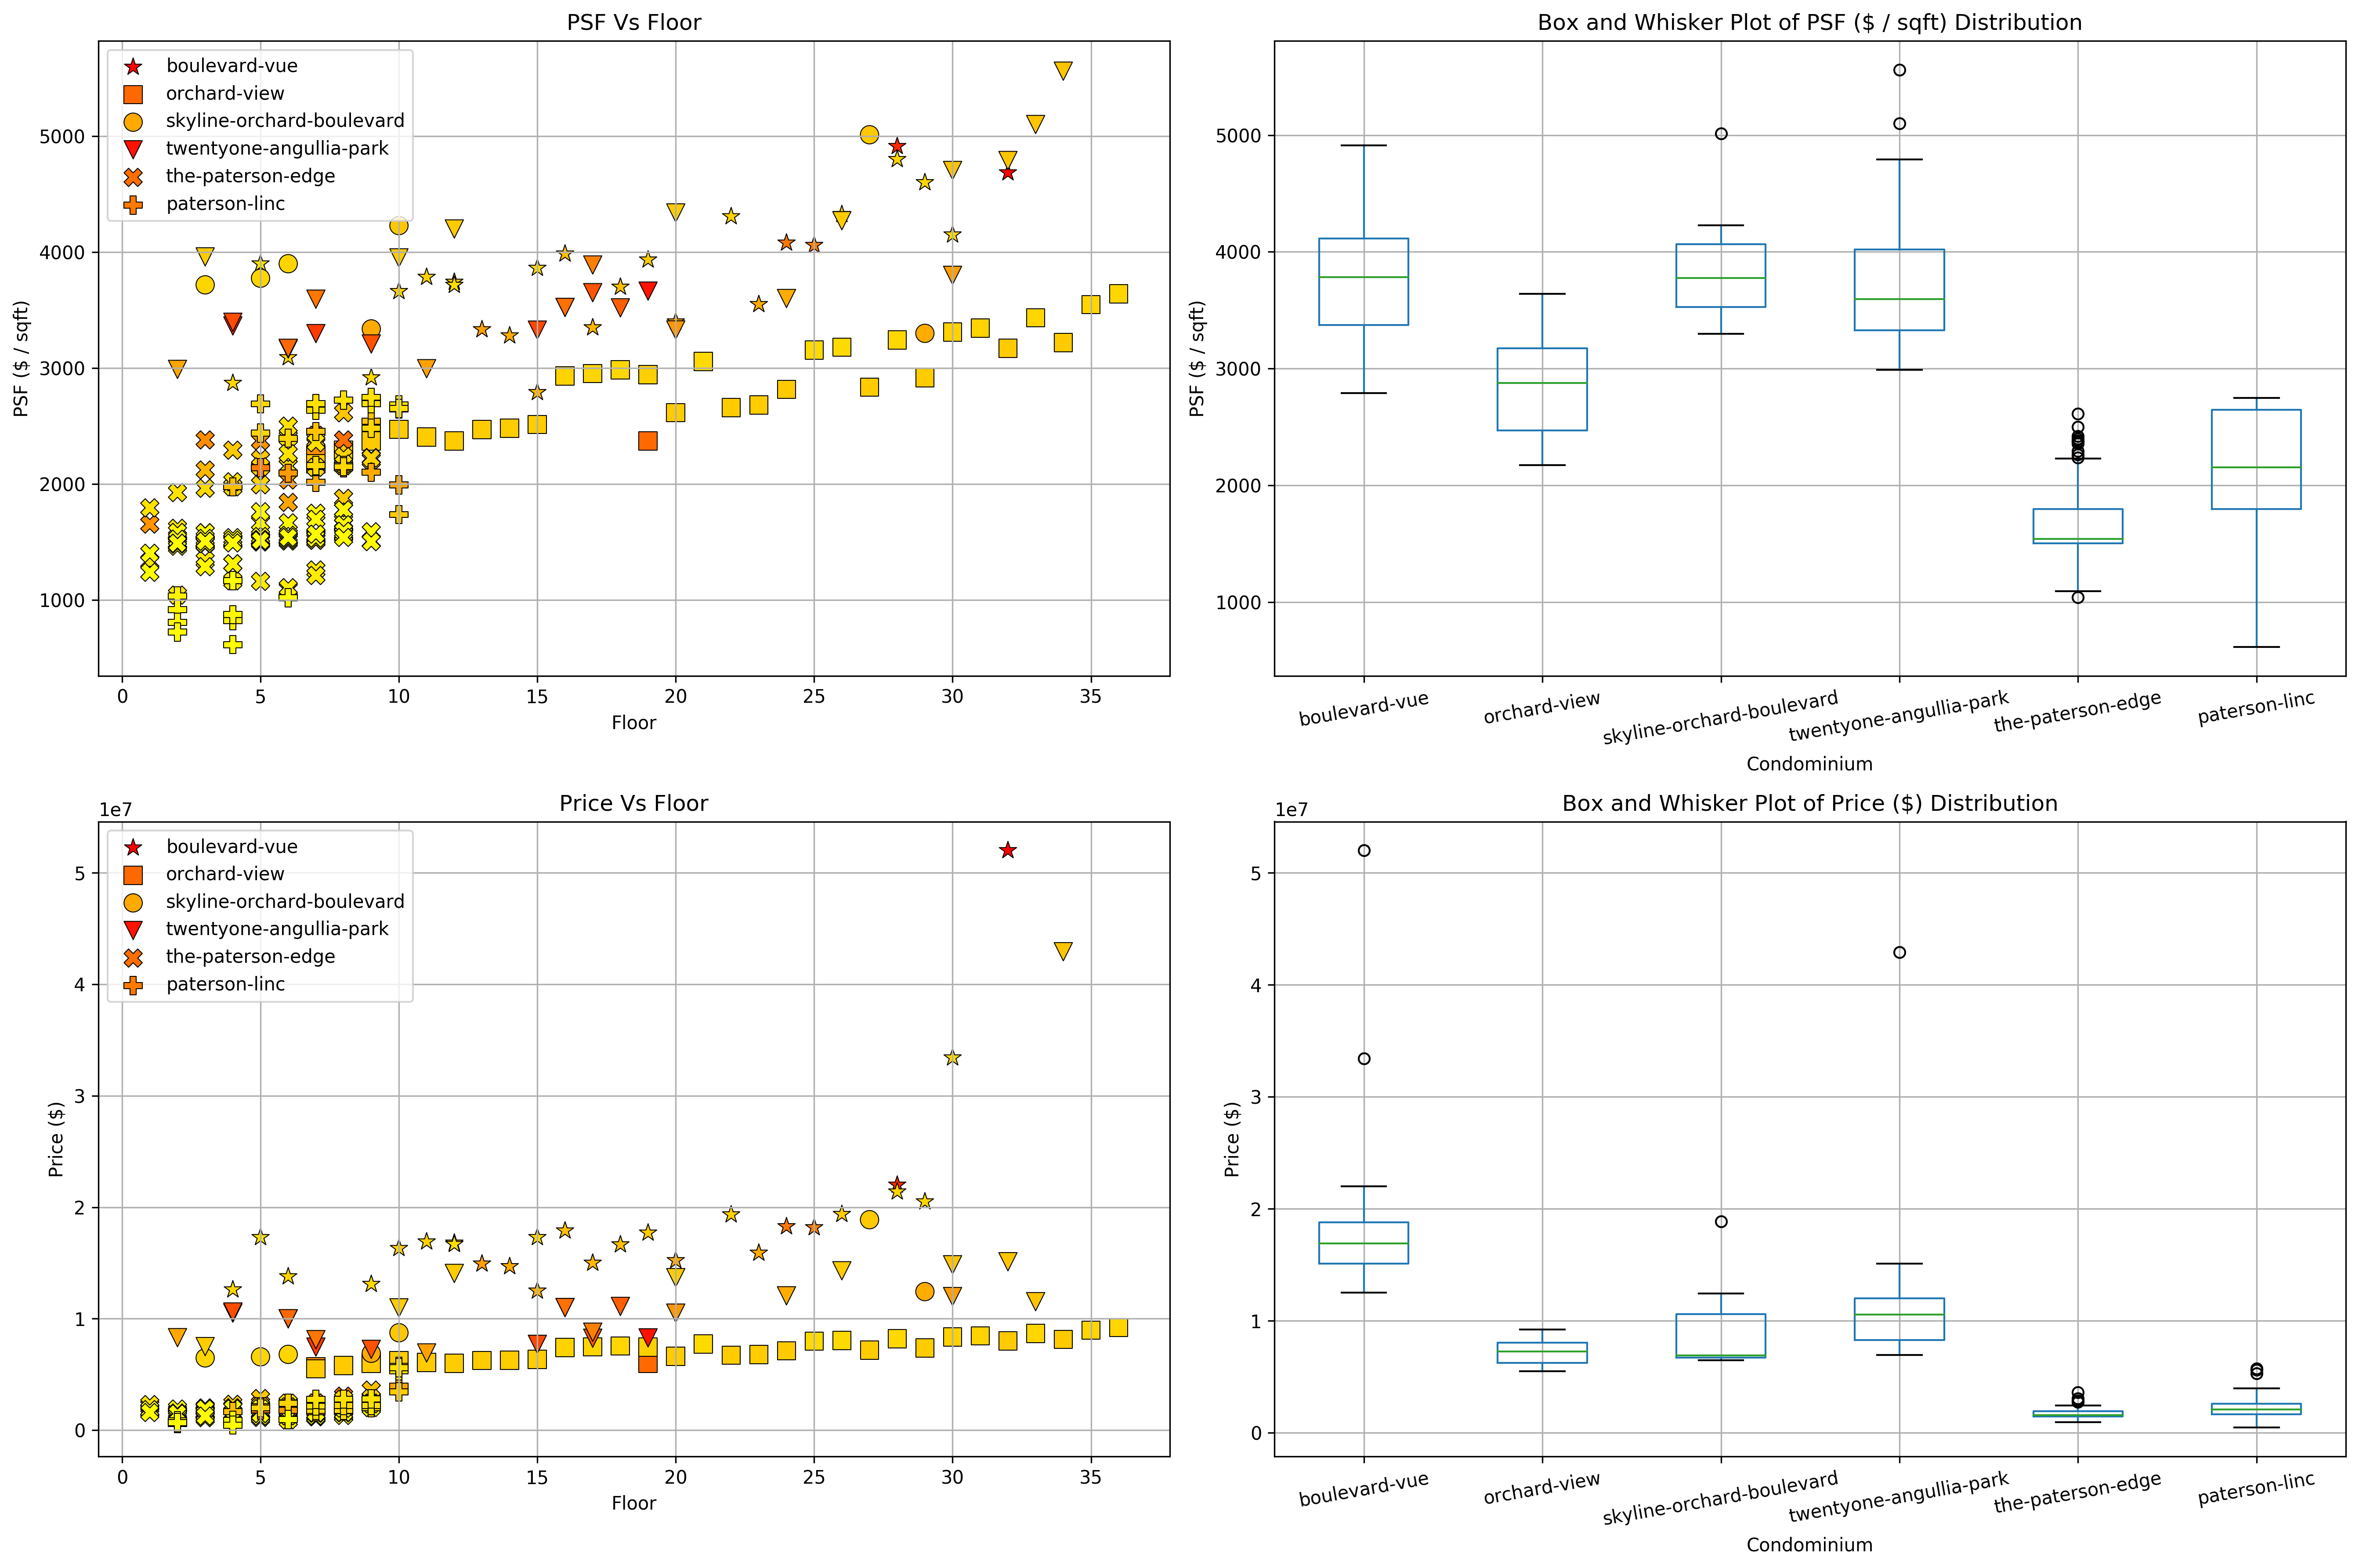

In [41]:
fig, ax = plt.subplots(2, 2)

# Get a set of all the days since transactions for 
# each condo of interest
days_since_transactions = set([days for key, val in condos_of_interest.items() for days in val['days_since_transaction'].values])

# Scaler for the days since transactions so
# we can display older transactions by a 
# diff color to distinguish from newer ones
days_scaler = matplotlib.colors.LogNorm(vmin=min(days_since_transactions),
                                        vmax=max(days_since_transactions))

# Aggregated condo sale psf and prices dataframe
condos_of_interest_all_psf = pd.DataFrame()
condos_of_interest_all_price = pd.DataFrame()

# Plots each transaction of each property
# Deeper colors signify more recent transactions while
# Lighter colors are older transactions
for idx, (condo_name, df) in enumerate(condos_of_interest.items()):
    psf, level, price, days_since_transaction = list(zip(*list(filter(None, df.apply(get_prices, axis=1)))))
    ax[0, 0].scatter(level, psf, 
                     c=[plt.cm.autumn(days_scaler(val)) for val in days_since_transaction], 
                     marker='*sovXPD'[idx], s=100, ec=[0,0,0], linewidth=0.5,
                     label=condo_name)
    
    ax[1, 0].scatter(level, price, 
                     c=[plt.cm.autumn(days_scaler(val)) for val in days_since_transaction], 
                     marker='*sovXPD'[idx], s=100, ec=[0,0,0], linewidth=0.5,
                     label=condo_name)
    condos_of_interest_all_psf = pd.concat([condos_of_interest_all_psf,
                                            pd.Series(psf, name=condo_name)], axis=1)
    condos_of_interest_all_price = pd.concat([condos_of_interest_all_price,
                                            pd.Series(price, name=condo_name)], axis=1)

ax[0, 0].set_ylabel('PSF ($ / sqft)')
ax[0, 0].set_xlabel('Floor')
ax[0, 0].set_title('PSF Vs Floor')
ax[0, 0].legend()
ax[0, 0].grid(True)

ax[1, 0].set_ylabel('Price ($)')
ax[1, 0].set_xlabel('Floor')
ax[1, 0].set_title('Price Vs Floor')
ax[1, 0].legend()
ax[1, 0].grid(True)

condos_of_interest_all_psf.boxplot(column=list(condos_of_interest.keys()), ax=ax[0, 1], rot=10)
ax[0, 1].set_ylabel('PSF ($ / sqft)')
ax[0, 1].set_xlabel('Condominium')
ax[0, 1].set_title('Box and Whisker Plot of PSF ($ / sqft) Distribution')

condos_of_interest_all_price.boxplot(column=list(condos_of_interest.keys()), ax=ax[1, 1], rot=10)
ax[1, 1].set_ylabel('Price ($)')
ax[1, 1].set_xlabel('Condominium')
ax[1, 1].set_title('Box and Whisker Plot of Price ($) Distribution')

plt.tight_layout()
plt.show();

In [42]:
get_development_gdf(condos_of_interest_transaction_history)


0it [00:00, ?it/s]
1it [00:01,  1.40s/it]
2it [00:02,  1.27s/it]
3it [00:03,  1.32s/it]
4it [00:04,  1.23s/it]
5it [00:06,  1.48s/it]
6it [00:08,  1.51s/it]

name  \
de9KYTFKJ4B68yXkPKUnouD3              boulevard-vue   
deRvQGVLRDYZgfWsmpY3Xm44               orchard-view   
deAuZ9ecUBhhZGcyUK7r2cRJ  skyline-orchard-boulevard   
dedxy2cVh9LsnfXCEL25t89G    twentyone-angullia-park   
dewBypwjuk8X7x5tT4crGY2S          the-paterson-edge   
deuA7gFcy2vkGMc235XRUL9n              paterson-linc   

                                                                   geometry  \
de9KYTFKJ4B68yXkPKUnouD3  POLYGON ((27563.08900003277 31748.65499999898,...   
deRvQGVLRDYZgfWsmpY3Xm44  POLYGON ((27656.2420000335 31813.68199999967, ...   
deAuZ9ecUBhhZGcyUK7r2cRJ  POLYGON ((27557.05500003346 31702.2980000001, ...   
dedxy2cVh9LsnfXCEL25t89G  POLYGON ((27656.2420000335 31813.68199999967, ...   
dewBypwjuk8X7x5tT4crGY2S  POLYGON ((27626.00500003414 31700.26009999928,...   
deuA7gFcy2vkGMc235XRUL9n  POLYGON ((27648.63300003501 31742.57899999956,...   

                                 area  
de9KYTFKJ4B68yXkPKUnouD3  4155.607301  
deRvQGVLRDYZgfWsmpY3Xm44  4562.538947  
deAuZ9ecUBhhZGcyUK7r2cRJ  3206.069833  
dedxy2cVh9LsnfXCEL25t89G  4562.538947  
dewBypwjuk8X7x5tT4crGY2S  2053.096945  
deuA7gFcy2vkGMc235XRUL9n   966.437889

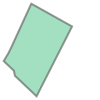

In [43]:
params = {
    'returnGeometry': 'true', 
    'where': '1=1',
    'outSr': '4326', 
    'outFields': 'name,lu_desc,lu_dt_cd,gpr_num,region_n,pln_area_n,subzone_n',
    'inSr': '4326',
    'geometry': str({'x': float(103.82947), 'y': float(1.3027), 'spatialReference': {'wkid': 4326} }),
    'geometryType': 'esriGeometryPoint',
    'spatialRel': 'esriSpatialRelWithin', 
    'f':'json'
}

# Get the Shape of the property development from
# the URA website
ura_res = requests.get('https://www.ura.gov.sg/arcgis/rest/services/maps2/Updated_Gaz_MP14_Land_Use_Maps/MapServer/55/query', 
                       params=params)

Polygon(json.loads(ura_res.text)['features'][0]['geometry']['rings'][0])

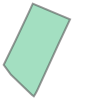

In [44]:
get_property_dev_shape('https://www.99.co/singapore/condos-apartments/boulevard-vue')

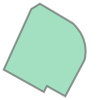

In [45]:
get_property_dev_shape('https://www.99.co/singapore/condos-apartments/twentyone-angullia-park')


0it [00:00, ?it/s]
1it [00:01,  1.25s/it]
2it [00:01,  1.09s/it]
3it [00:03,  1.12s/it]
4it [00:04,  1.22s/it]
5it [00:07,  1.65s/it]
6it [00:08,  1.51s/it]

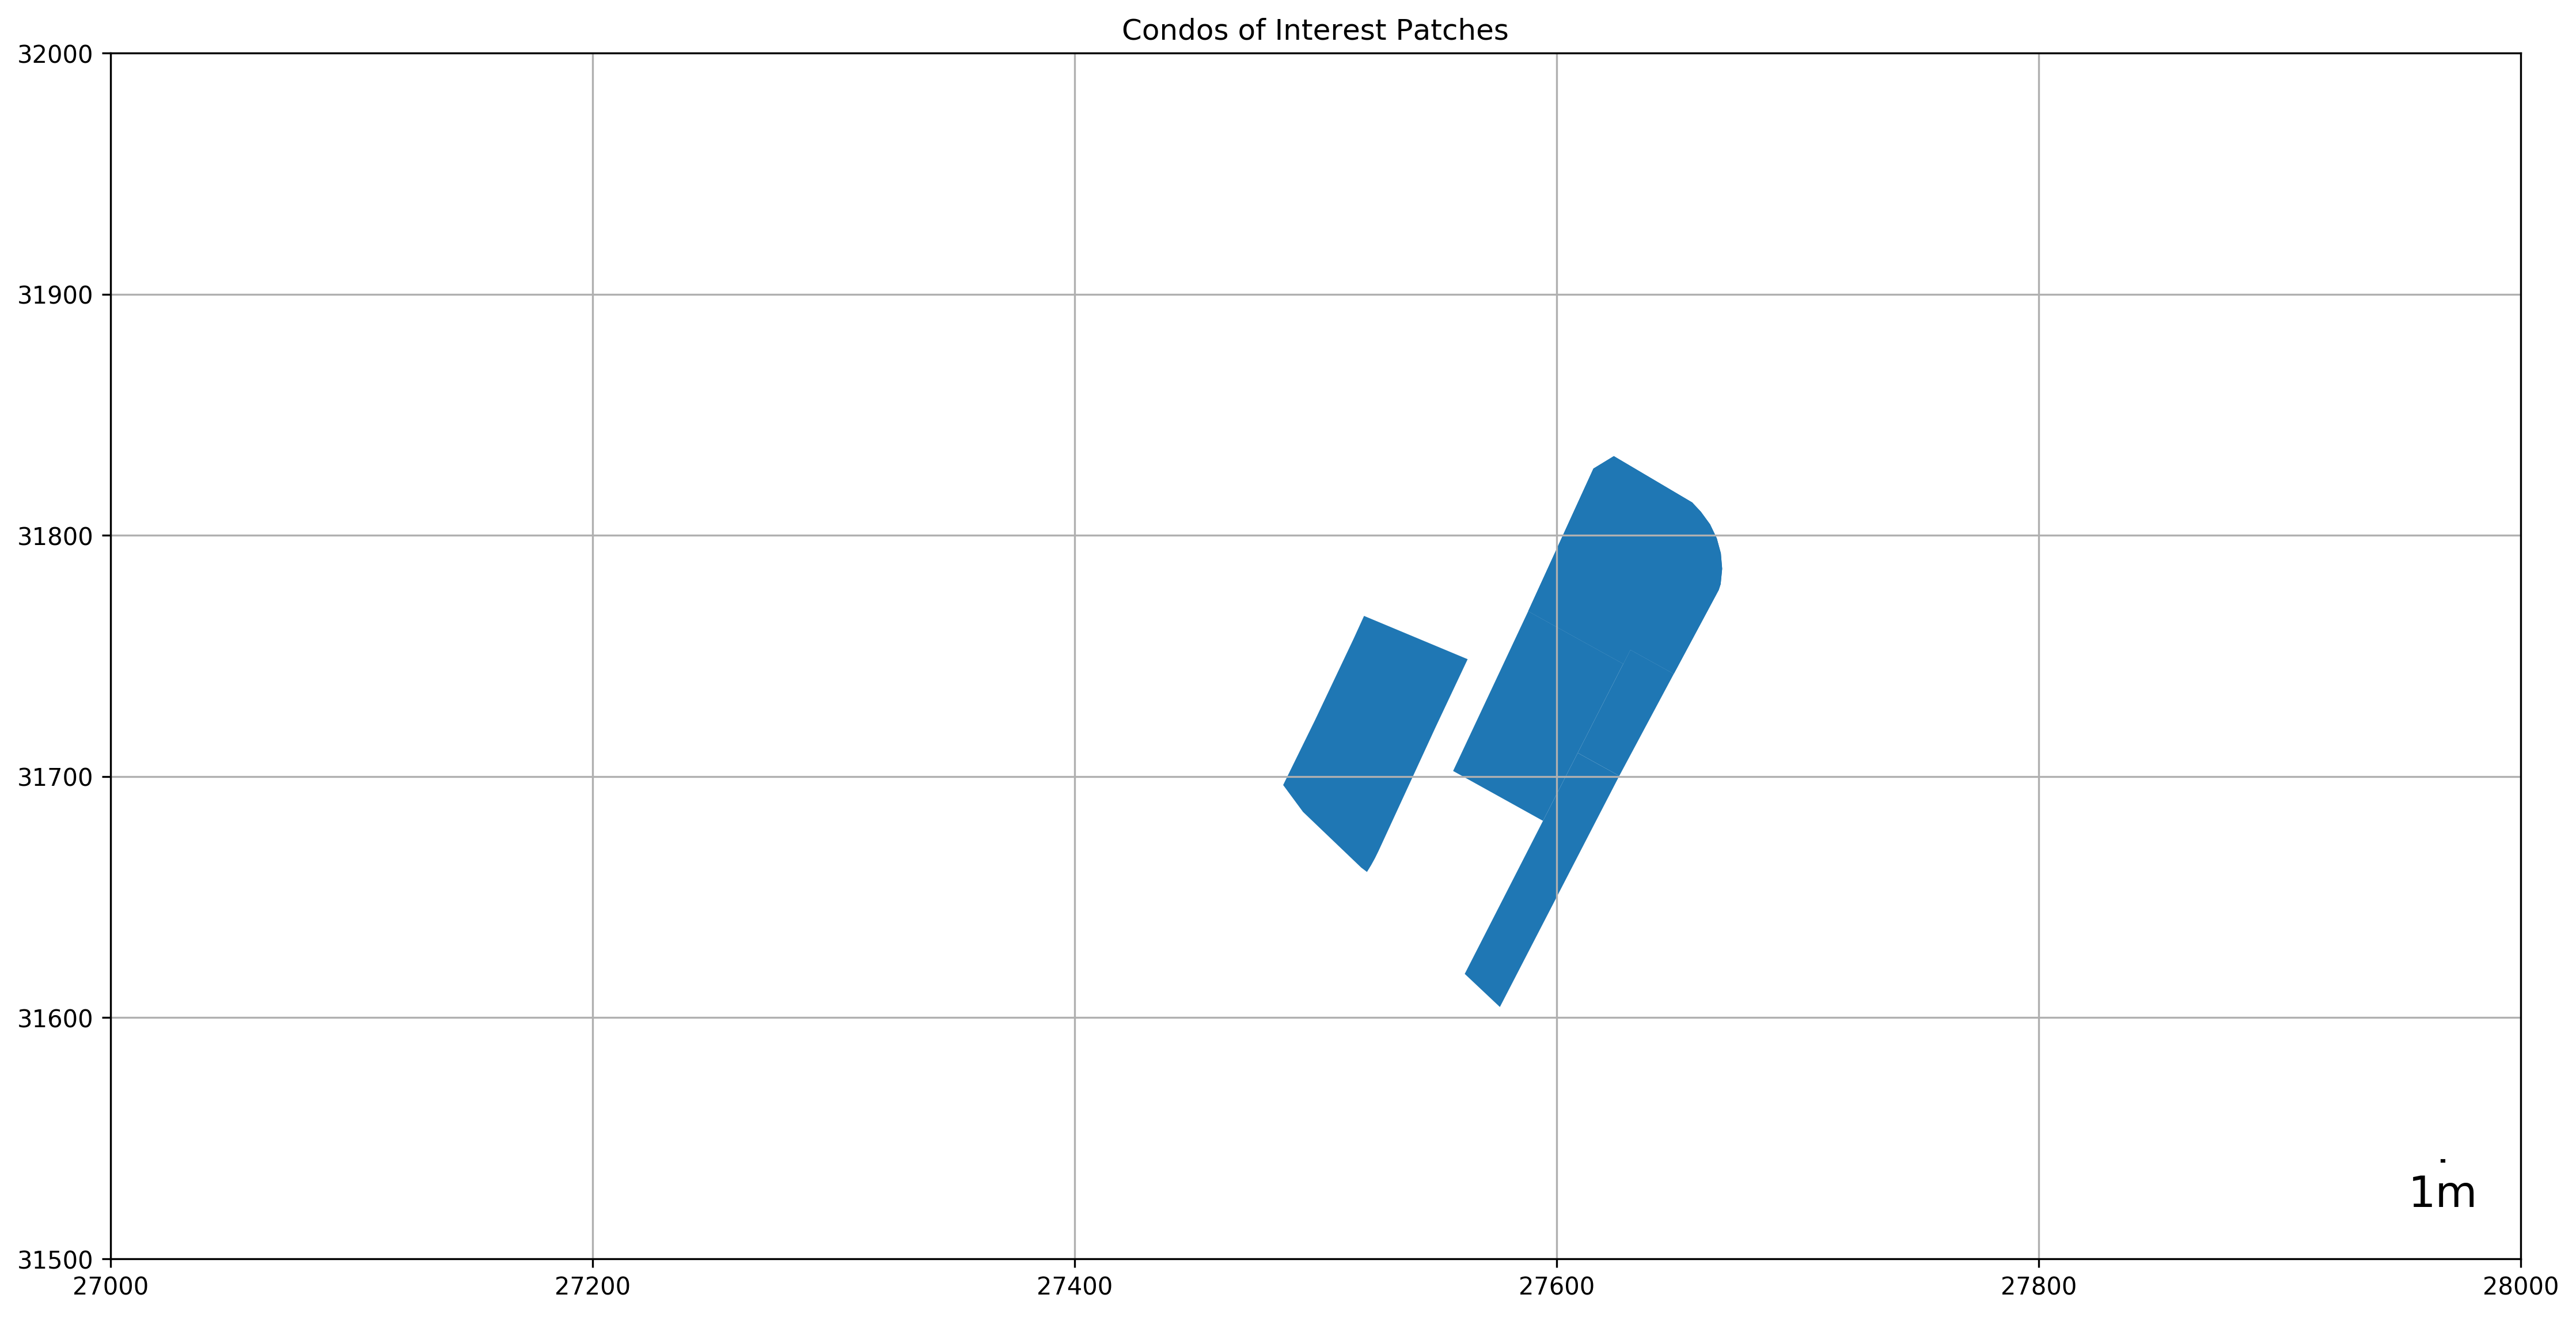

In [46]:
fontprops = fm.FontProperties(size=18)
fig, ax = plt.subplots(1, 1, sharex=True)

get_development_gdf(condos_of_interest_transaction_history)['geometry'].plot(ax=ax)
        
bar = AnchoredSizeBar(transform=ax.transData, 
                      size=1, 
                      label='1m', 
                      loc=4, 
                      pad=0.5, 
                      sep=5, 
                      borderpad=0.5, 
                      frameon=False, 
                      size_vertical=0.5, 
                      color='black', 
                      fontproperties=fontprops)
ax.add_artist(bar)

ax.set_xlim(left=27e3, right=28e3)
ax.set_ylim(bottom=31.5e3, top=32e3)
ax.set_title('Condos of Interest Patches')
plt.grid(True)
plt.show();

<a id='eval'></a>

---
# Evaluation

<a id='deploy'></a>

---
# Deployment

<a id='resources'></a>

---
## Resources
- https://www.99.co/blog/singapore/a-general-guide-to-types-of-housing-in-singapore/
- https://www.99.co/blog/singapore/freehold-vs-leasehold-condos/